In [1]:
import json
import os
import pickle
import matplotlib.pyplot as plt
import numpy as np
import pickle
import pandas as pd

from collections import namedtuple, defaultdict, Counter
from itertools import groupby, chain, count
from operator import itemgetter
from scipy.spatial.distance import cdist
from tqdm import tqdm

In [2]:
MODELS_DIR = '/home/mikhail/bioinformatics/data/sec_struct'

In [3]:
def load_model(pdb_id):
    with open(os.path.join(MODELS_DIR, '{}.pickle'.format(pdb_id)), 'rb') as infile:
        return pickle.load(infile)

In [4]:
with open('/home/mikhail/bioinformatics/data/nonredundant.txt', 'r') as infile:
    nonredundant_chain_ids = {tuple(chain_id.split('.cif1_')) for chain_id in infile.read().splitlines()}

In [5]:
urs_models = {pdb_id: load_model(pdb_id) for pdb_id, _ in nonredundant_chain_ids}

In [6]:
Fragment = namedtuple('Fragment', 'pdb_id ch type index global_index members')

In [7]:
def get_fragment_chains(chain_ids):
    fragment_chains = []
    
    for pdb_id, chain_id in chain_ids:
        fragment_id_res = []
        
        for res in urs_models[pdb_id].chains[chain_id]['RES']:
            assert sum(res[key] is not None for key in ['WING', 'THREAD']) == 1
            type_ = 'WING' if res['THREAD'] is None else 'THREAD'
            fragment_id_res.append(((type_, res[type_]), res))
        
        fragment_chains.append([
            Fragment(pdb_id, chain_id, type_, index, global_index, [res for _, res in group]) 
            for global_index, ((type_, index), group) in enumerate(groupby(fragment_id_res, itemgetter(0)))])
    
    return fragment_chains


def print_fragment_chain(fragment_chain):
    print('meta:', fragment_chain[0].pdb_id, fragment_chain[0].ch)
    for fragment in fragment_chain:
        print(fragment.type, fragment.index)

In [8]:
def get_coords(res):
    return [[atom[key] for key in 'XYZ'] for atom in res['ATOMS']]


def get_fragment_atoms(fragment):
    return list(chain.from_iterable([get_coords(res) for res in fragment.members]))


def fragment_distance(left, right):
    return np.min(cdist(get_fragment_atoms(left), get_fragment_atoms(right), 'euclidean'))


def fragment_sequence_distance(left, right):
    indices = [[urs_models[fragment.pdb_id].dssrnucls[res['DSSR']][2] 
                for res in fragment.members] 
               for fragment in [left, right]]
    
    return min(abs(min(indices[r]) - max(indices[l])) for l, r in [(0, 1), (1, 0)])


def fragment_relation(left, right):
    if left.type == 'WING' and right.type == 'WING' and fragment_sequence_distance(left, right) == 1:
        return 'LC'
    
    return urs_models[left.pdb_id].NuclRelation(left.members[0]['DSSR'], right.members[0]['DSSR'])


def fragment_type(fragment):
    types = urs_models[fragment.pdb_id].NuclSS(fragment.members[0]['DSSR']).split(';')
    
    if types == ['S']:
        return [{'S'}, {}]
    else:
        return [{item[i] for item in types} for i in range(2)]

    
def fragment_length(fragment):
    return len(fragment.members)


def fragment_sequence(fragment, fill_length):
    sequence = []
    
    for res in fragment.members:
        name = res['NAME']
        if len(name) > 1 or name not in 'AUGC':
            name = 'M'
        
        sequence.append(name)
    
    while len(sequence) < fill_length:
        sequence.append('N')
    
    return sequence


def fragment_fragment_distance(left, right):
    return right.global_index - left.global_index

In [9]:
short_chain_ids = [chain_id for chain_id in nonredundant_chain_ids if chain_id[0] not in ['4y4o', '6qzp']]

In [10]:
short_chain_ids

[('2qwy', 'C'),
 ('1l9a', 'B'),
 ('4prf', 'B'),
 ('5kpy', 'A'),
 ('5u3g', 'B'),
 ('4rge', 'C'),
 ('1kh6', 'A'),
 ('3npq', 'A'),
 ('1l2x', 'A'),
 ('5fjc', 'A'),
 ('4p95', 'A'),
 ('6dlr', 'A'),
 ('5btp', 'B'),
 ('3hhn', 'E'),
 ('4far', 'A'),
 ('5x2g', 'B'),
 ('4lvw', 'A'),
 ('6fz0', 'A'),
 ('3d2v', 'A'),
 ('2z75', 'B'),
 ('1u9s', 'A'),
 ('3k1v', 'A'),
 ('3f2q', 'X'),
 ('4enc', 'A'),
 ('3pdr', 'X'),
 ('4yaz', 'R'),
 ('5k7d', 'A'),
 ('3la5', 'A'),
 ('2r8s', 'R'),
 ('3e5c', 'A'),
 ('4frg', 'B'),
 ('6dtd', 'C'),
 ('3rw6', 'H'),
 ('1f1t', 'A'),
 ('4rmo', 'B'),
 ('4jf2', 'A'),
 ('4qlm', 'A'),
 ('4wfl', 'A')]

In [11]:
fragment_chains = get_fragment_chains(short_chain_ids)
len(fragment_chains)

38

In [10]:
chain_lengths = {'{}_{}'.format(fragment_chain[0].pdb_id, fragment_chain[0].ch): len(fragment_chain)
                 for fragment_chain in fragment_chains}

with open('chain_lengths.pickle', 'wb') as outfile:
    pickle.dump(chain_lengths, outfile)

In [11]:
fragments = list(chain.from_iterable(fragment_chains))
len(fragments)

3194

Проверим, что для LR пар фрагментов, таких что пара не (WING, WING), расстояние по сиквенсу между фрагментами не менее 2.

In [10]:
for fragment_chain in fragment_chains:
    for i, left in enumerate(fragment_chain):
        for right in fragment_chain[i + 1:]:
            rel = urs_models[left.pdb_id].NuclRelation(left.members[0]['DSSR'], right.members[0]['DSSR'])
            
            if rel == 'LR' and {left.type, right.type} != {'WING'}:
                assert not fragment_sequence_distance(left, right) <= 2

Посчитаем количество фрагментов с MISS нуклеотидами

In [13]:
sum([any(res['MISS'] for res in fragment.members) for fragment in fragments])

35

In [14]:
sum([all(res['MISS'] for res in fragment.members) for fragment in fragments])

9

Так как таких фрагментов мало, просто выкинем их из выборки

Посчитаем среднее евклидово расстояние между нуклеотидами в цепочках в зависимости от расстояния между нуклеотидами по сиквенсу

In [10]:
def res_fragment_type(res):
    return 'WING' if res['THREAD'] is None else 'THREAD'


def get_distances_on_sequence(sequence_distance, chain_ids):
    distances = defaultdict(list)
    
    for pdb_id, chain_id in chain_ids:
        atoms = [{'coords': get_coords(res), 'dssr': res['DSSR'], 'type': res_fragment_type(res)} 
                 for res in urs_models[pdb_id].chains[chain_id]['RES']]

        for left_i, left in enumerate(atoms):
            right_i = left_i + sequence_distance
            if right_i < len(atoms):
                right = atoms[right_i]
                
                nr = urs_models[pdb_id].NuclRelation(left['dssr'], right['dssr'])
                pair_fragment_type = ' '.join(sorted([left['type'], right['type']]))

                if len(right['coords']) > 0 and len(left['coords']) > 0:
                    d = np.min(cdist(left['coords'], right['coords'], 'euclidean'))
                    
                    distances['{} {}'.format(nr, pair_fragment_type)].append(d)
                    distances[nr].append(d)
                    distances['ALL'].append(d)
    
    return distances

In [38]:
distances = [{}] + [get_distances_on_sequence(i, nonredundant_chain_ids) for i in tqdm(range(1, 51))]

100%|██████████| 50/50 [00:39<00:00,  1.26it/s]


In [47]:
data = []
index = []

for i in range(1, 21):
    mean = np.mean(distances[i]['LR'])
    std = np.std(distances[i]['LR'])
    
    index.append(i)
    data.append([round(mean, 1), round(std, 1)])

In [48]:
pd.DataFrame(data, pd.Index(index, name='sequence distance'), columns=['mean eucledian', 'std eucledian']).transpose()

sequence distance,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20
mean eucledian,1.6,5.9,9.0,11.8,14.4,16.5,18.3,19.9,21.5,23.2,24.8,26.4,27.9,29.3,30.6,31.8,32.9,33.9,34.8,35.6
std eucledian,0.0,1.1,1.8,2.6,3.3,4.0,4.7,5.3,5.8,6.4,7.0,7.8,8.6,9.4,10.2,10.9,11.6,12.3,13.0,13.7


In [19]:
all_keys = list(sorted(set(chain.from_iterable([d.keys() for d in distances]))))

In [20]:
all_keys

['ALL',
 'LC',
 'LC THREAD WING',
 'LR',
 'LR THREAD THREAD',
 'LR THREAD WING',
 'LR WING WING',
 'SM',
 'SM THREAD THREAD',
 'SM WING WING']

In [23]:
all_keys

['ALL',
 'LC',
 'LC THREAD WING',
 'LR',
 'LR THREAD THREAD',
 'LR THREAD WING',
 'LR WING WING',
 'SM',
 'SM THREAD THREAD',
 'SM WING WING']

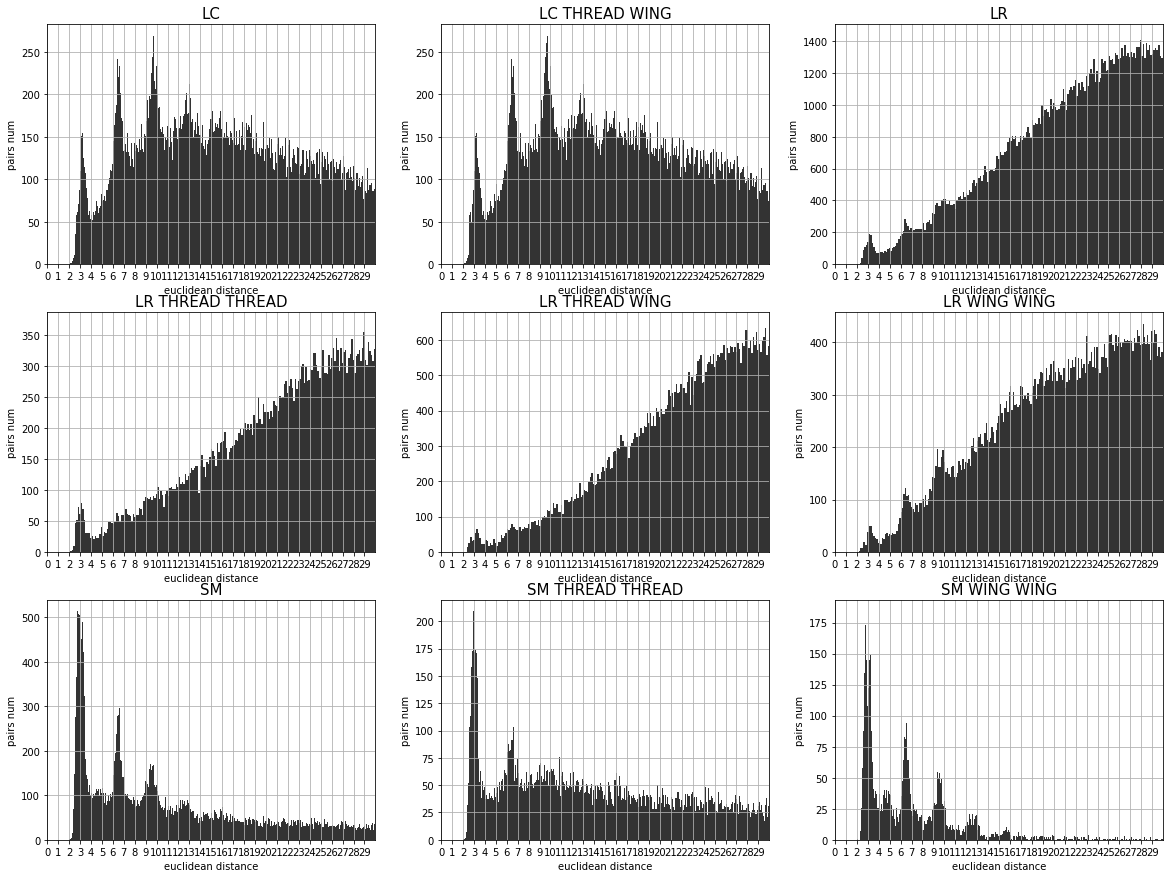

In [36]:
fig, axes = plt.subplots(3, 3, figsize=(20, 15))

for index, ng in enumerate(all_keys[1:]):
    i, j = index // 3, index % 3
    ax = axes[i][j]
    
    ax.set_xlim(0, 30)
    ax.set_xticks(np.arange(30))
    ax.set_ylabel('pairs num', fontsize=10)
    ax.set_xlabel('euclidean distance', fontsize=10)
    ax.set_title(ng, fontsize=15)
    ax.grid()

    ax.hist(list(chain.from_iterable([distances[i].get(ng, []) for i in range(10, 51)])), 
             bins=1000, alpha=0.8, label=f'{i}', color='k')

fig.savefig('/home/mikhail/hist.png')

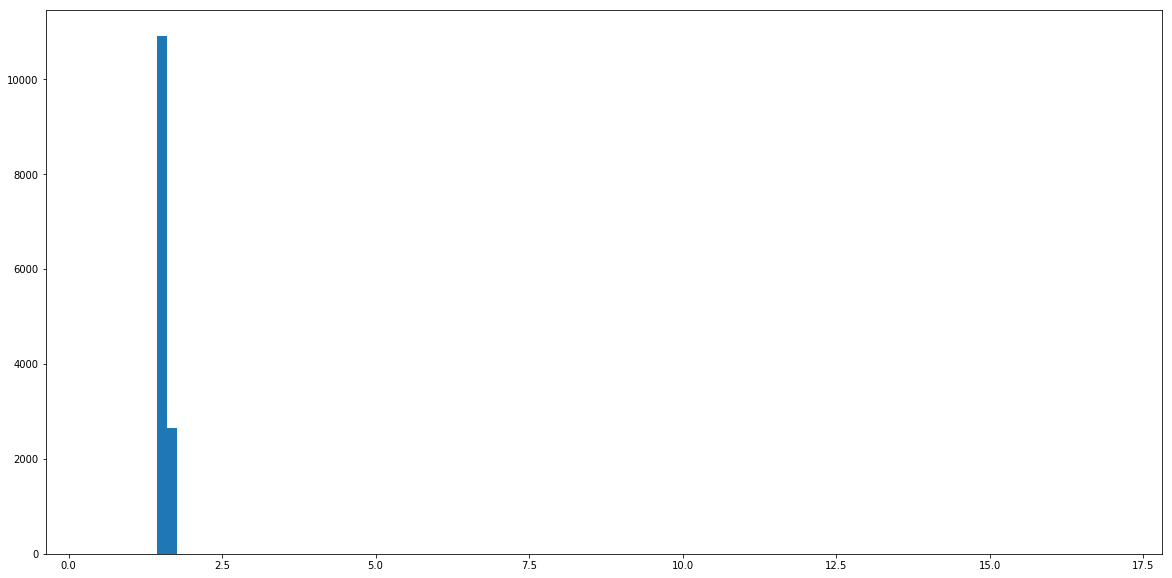

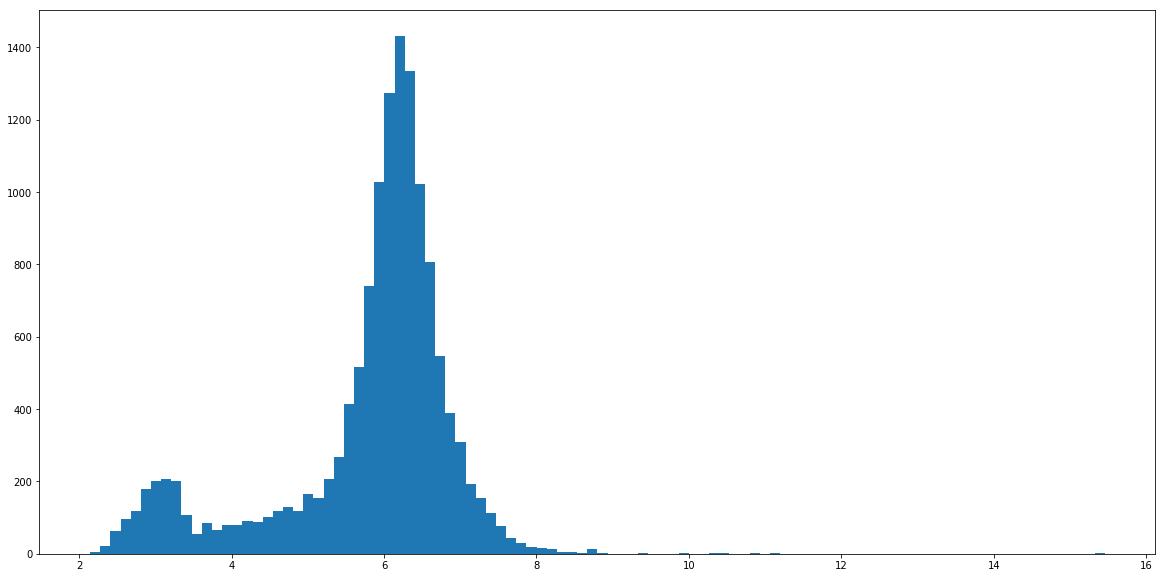

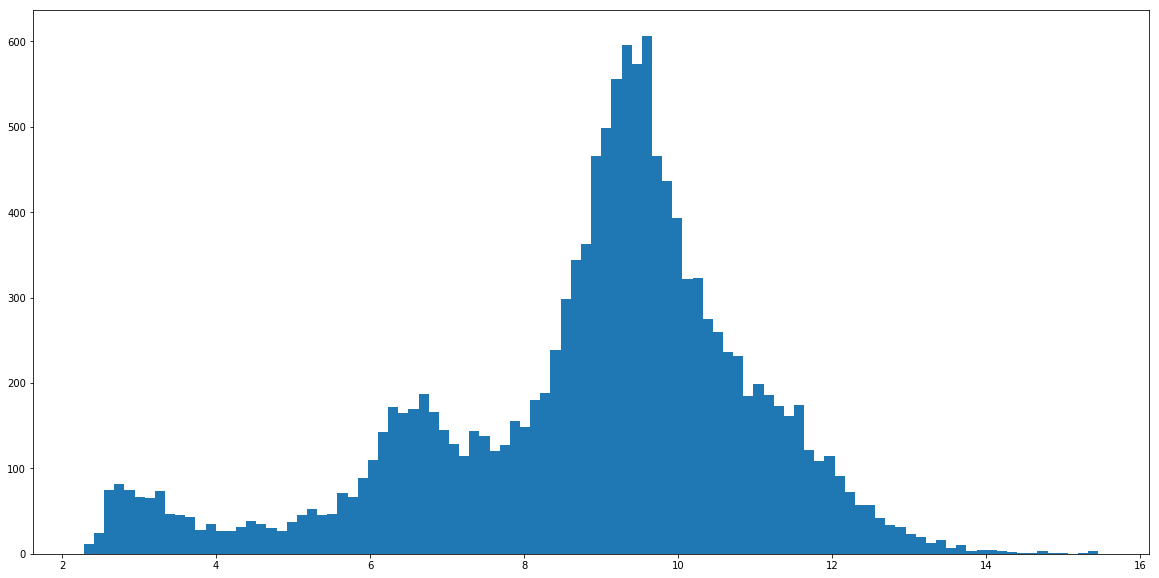

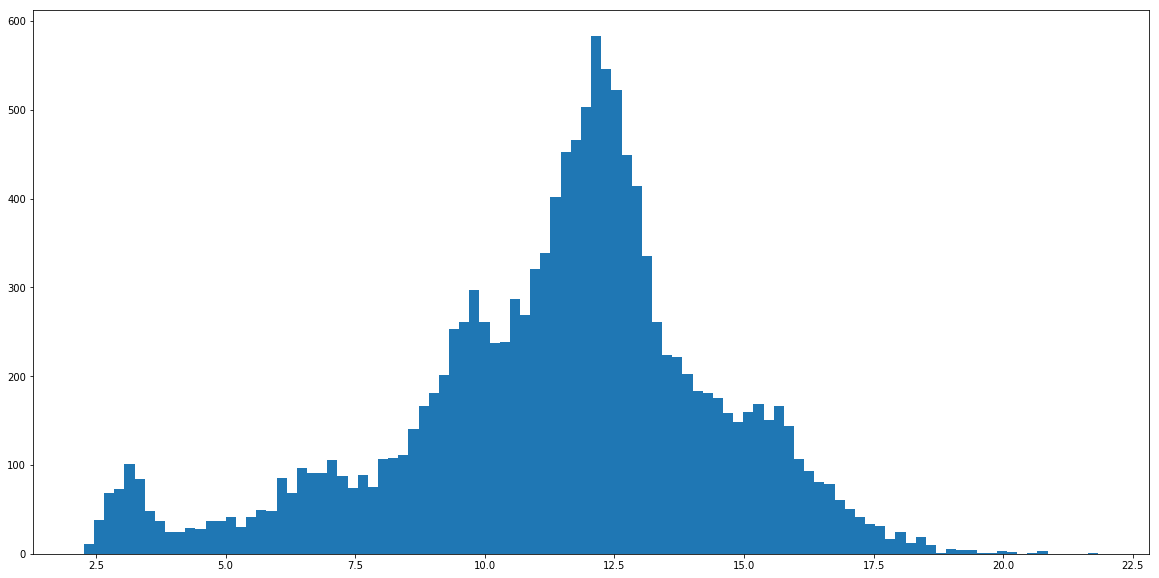

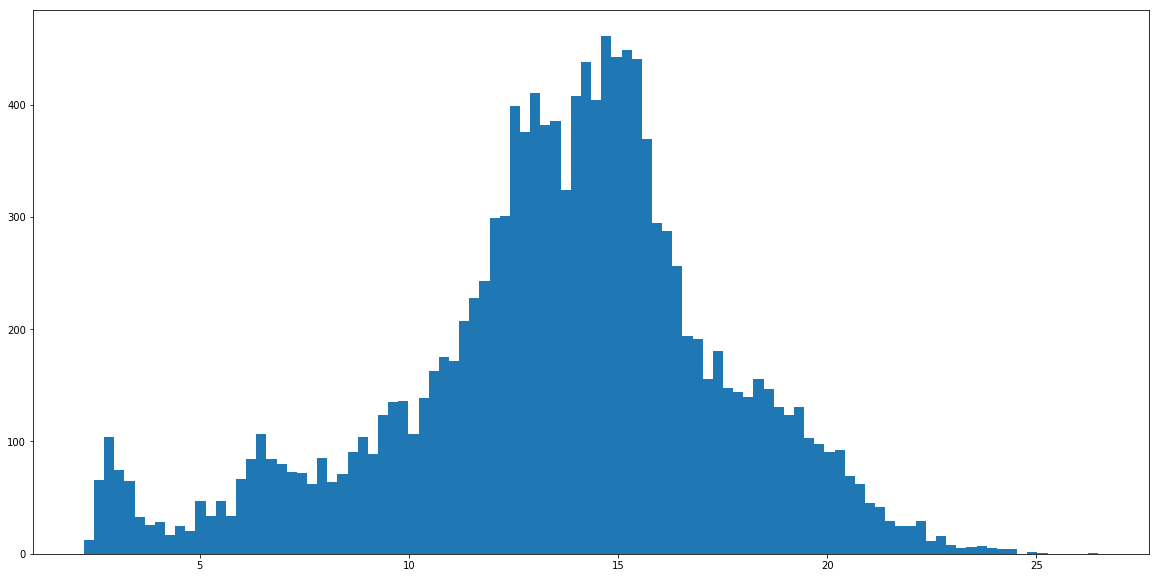

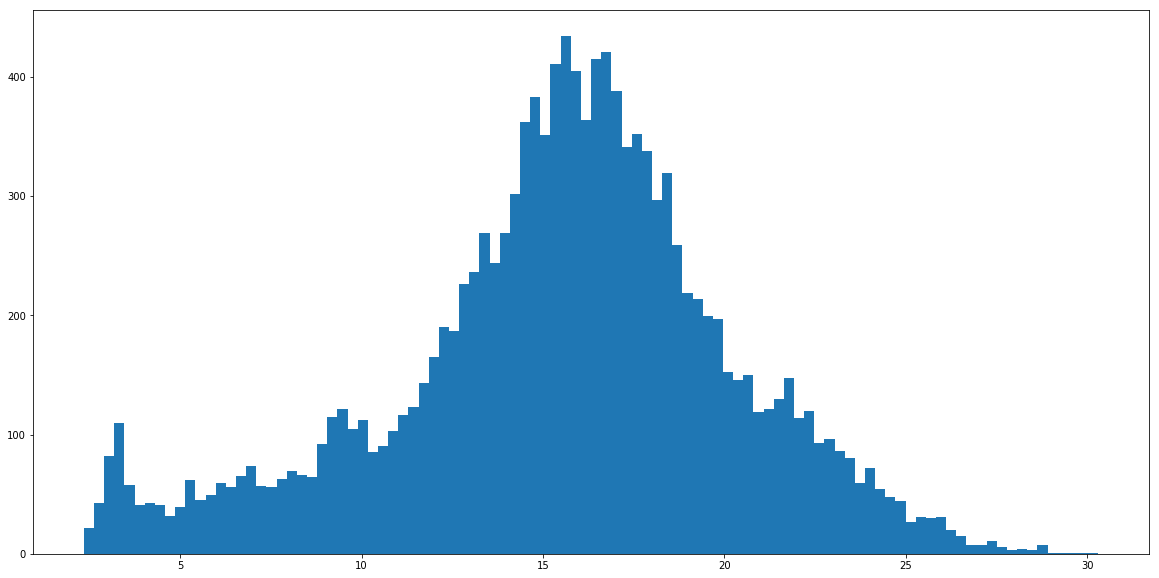

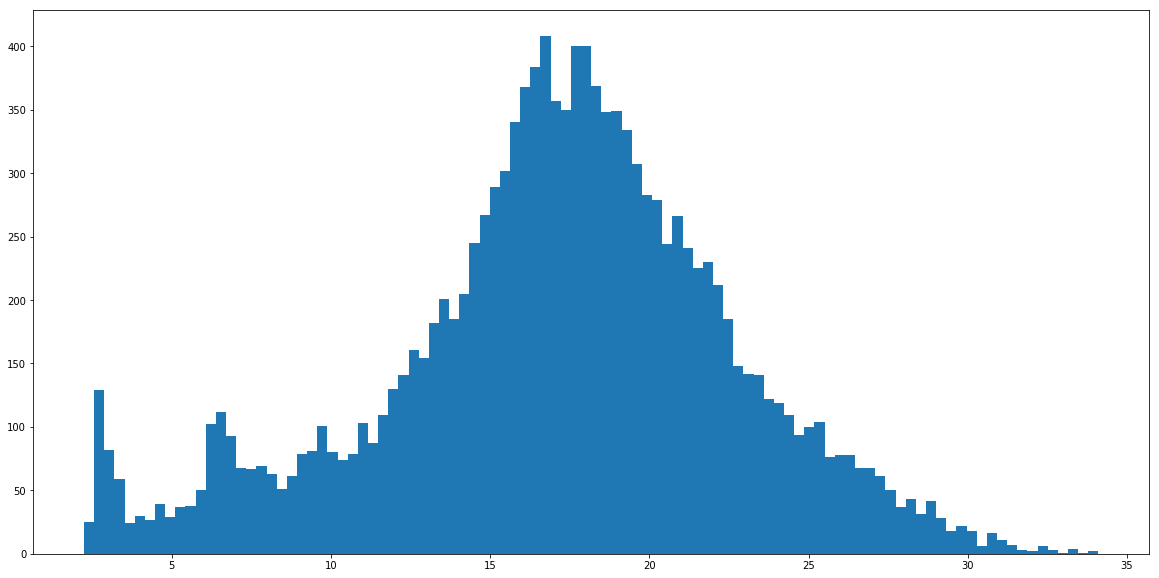

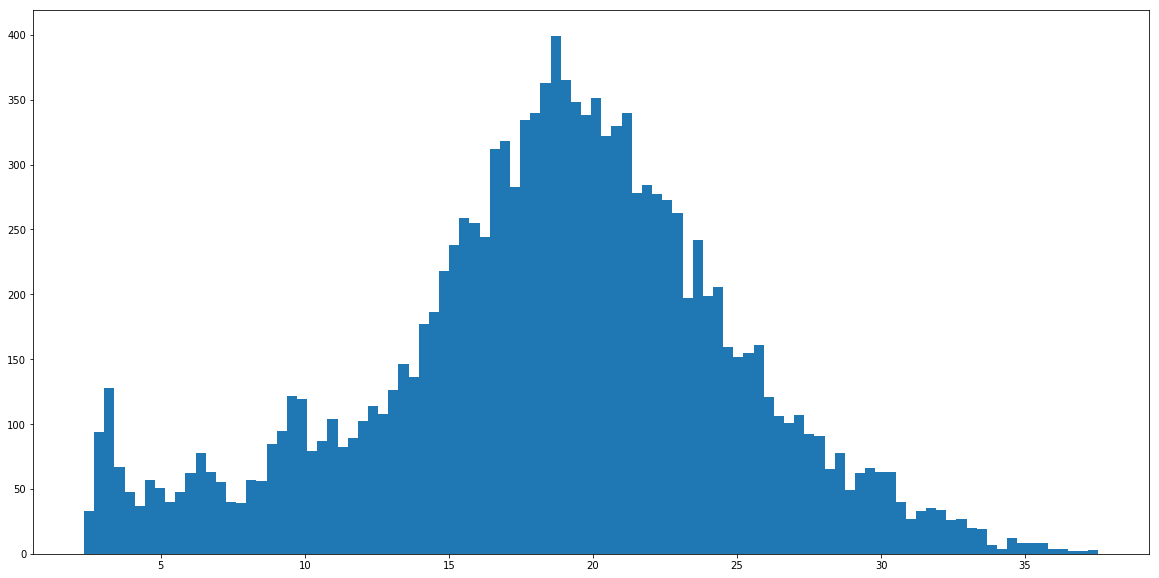

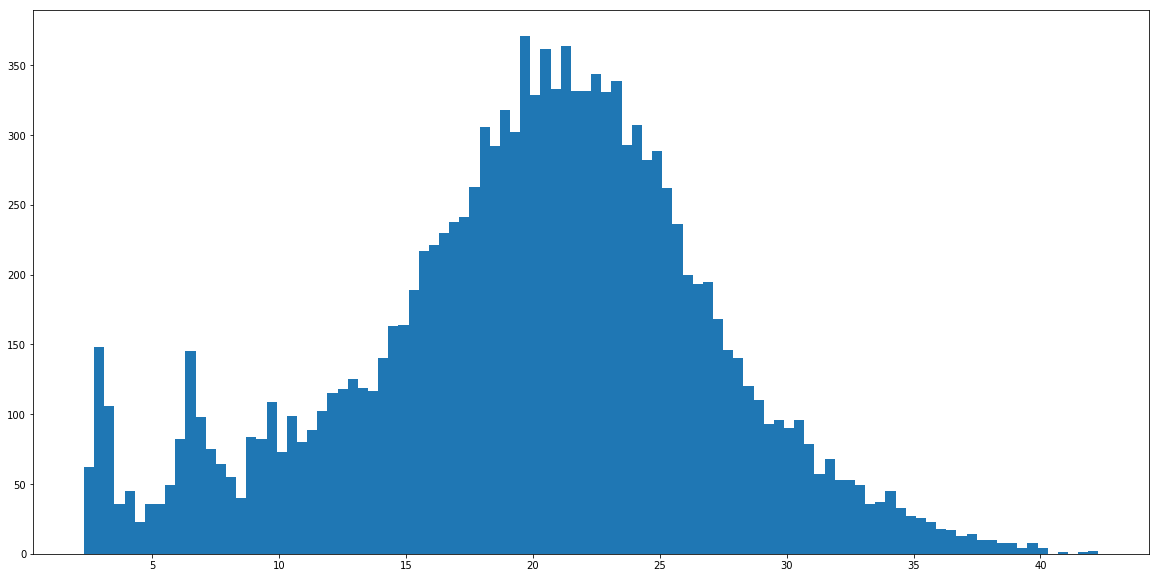

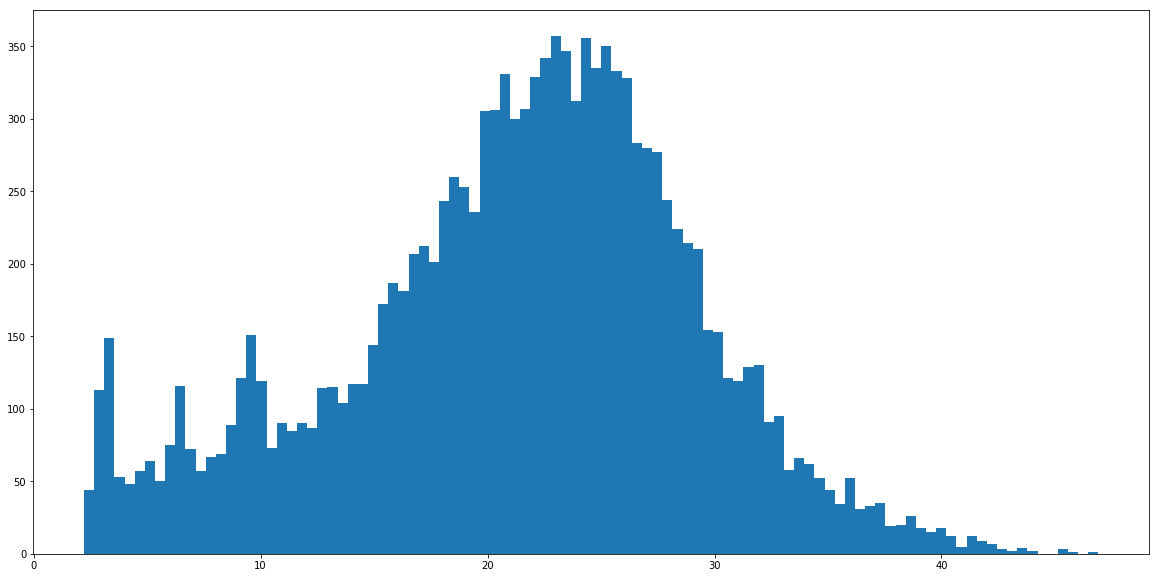

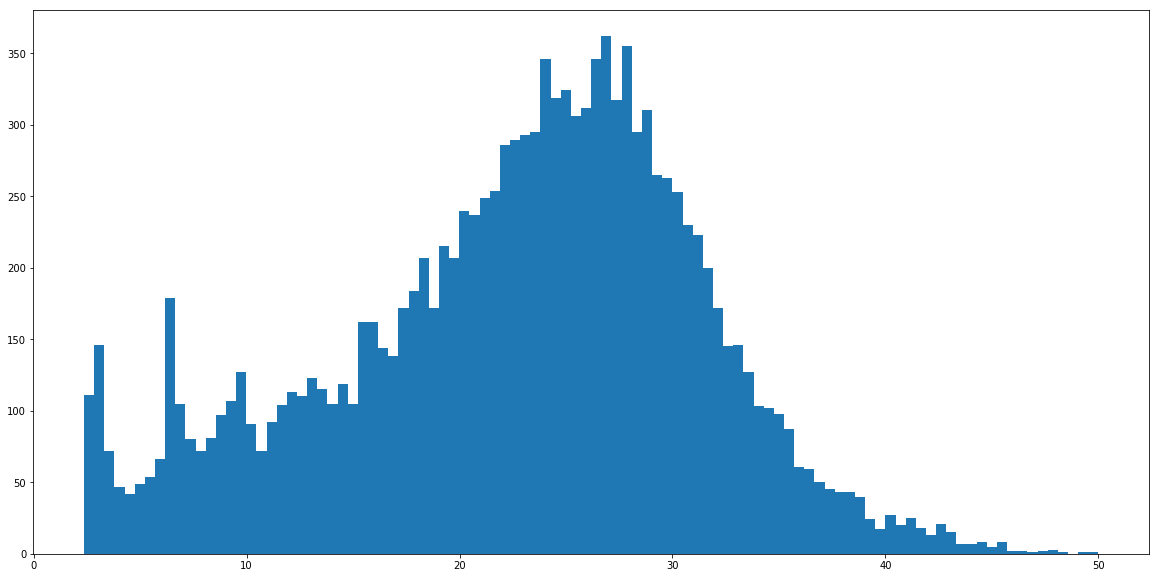

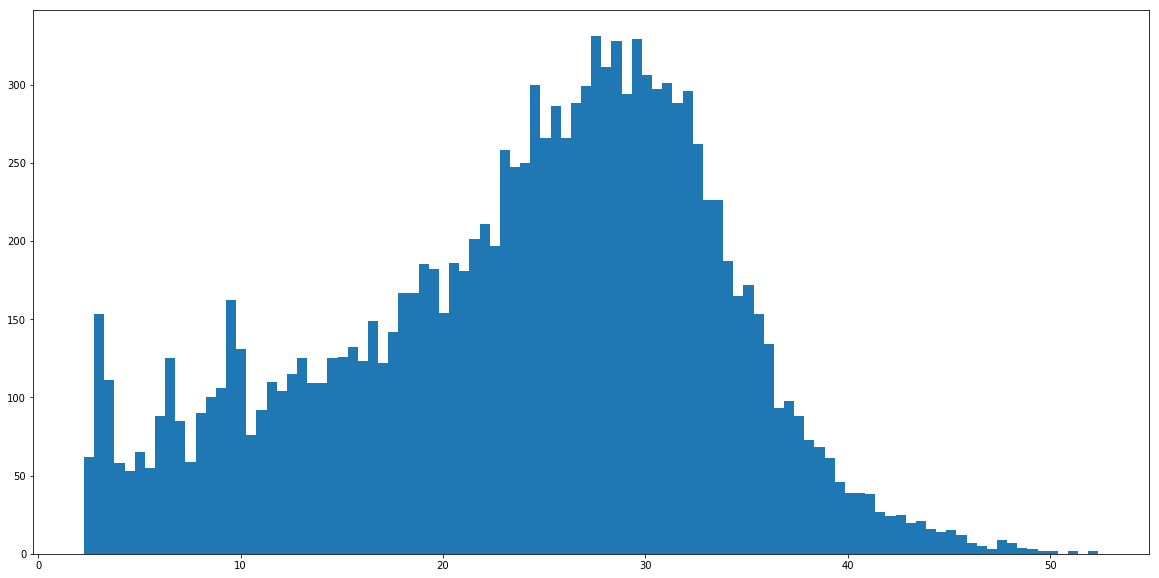

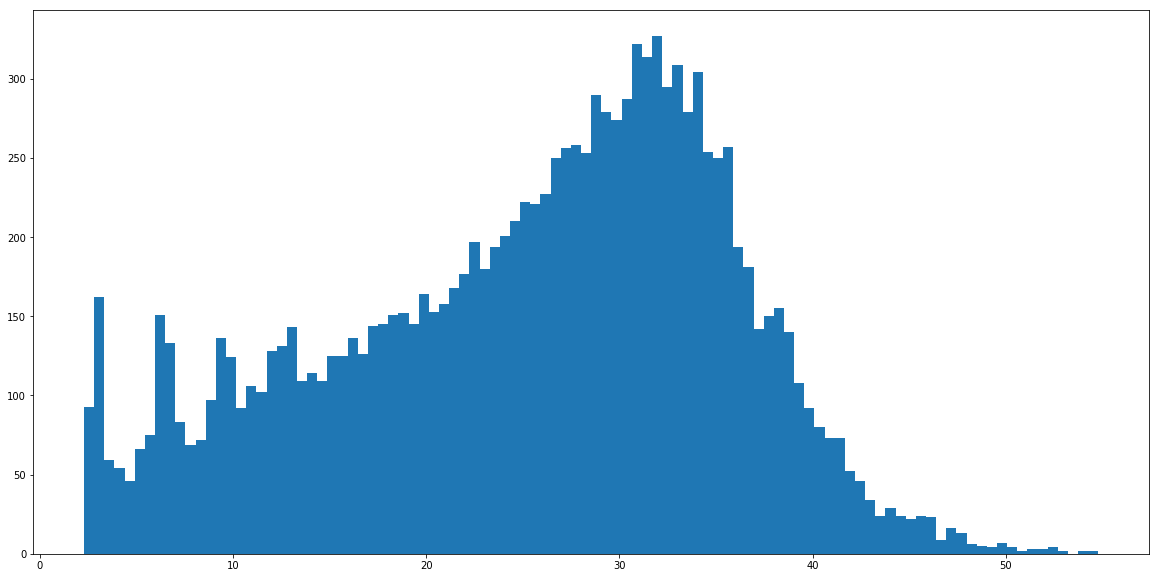

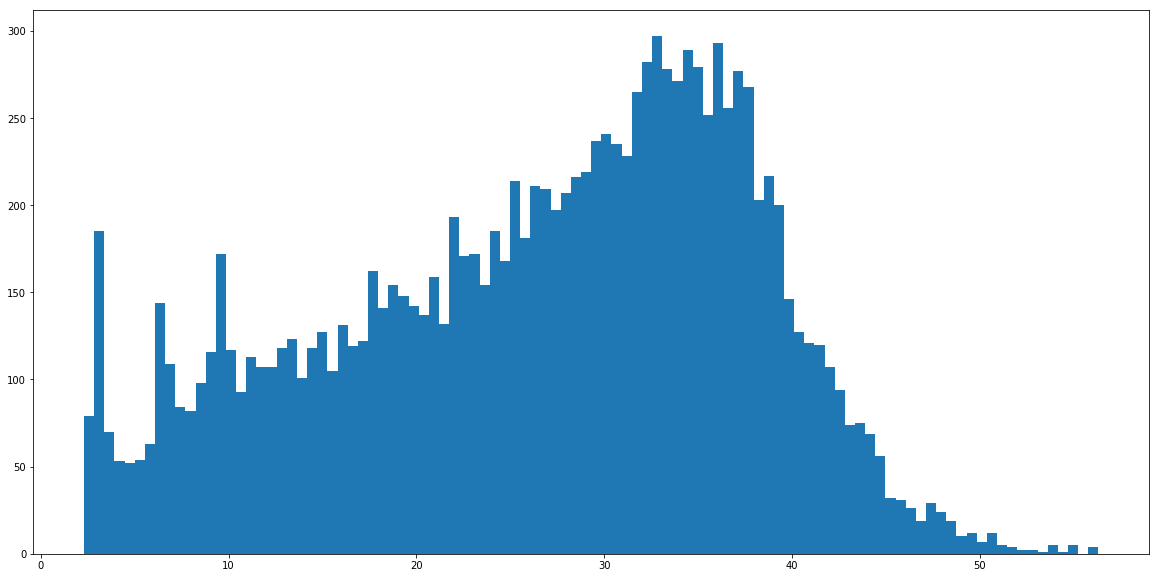

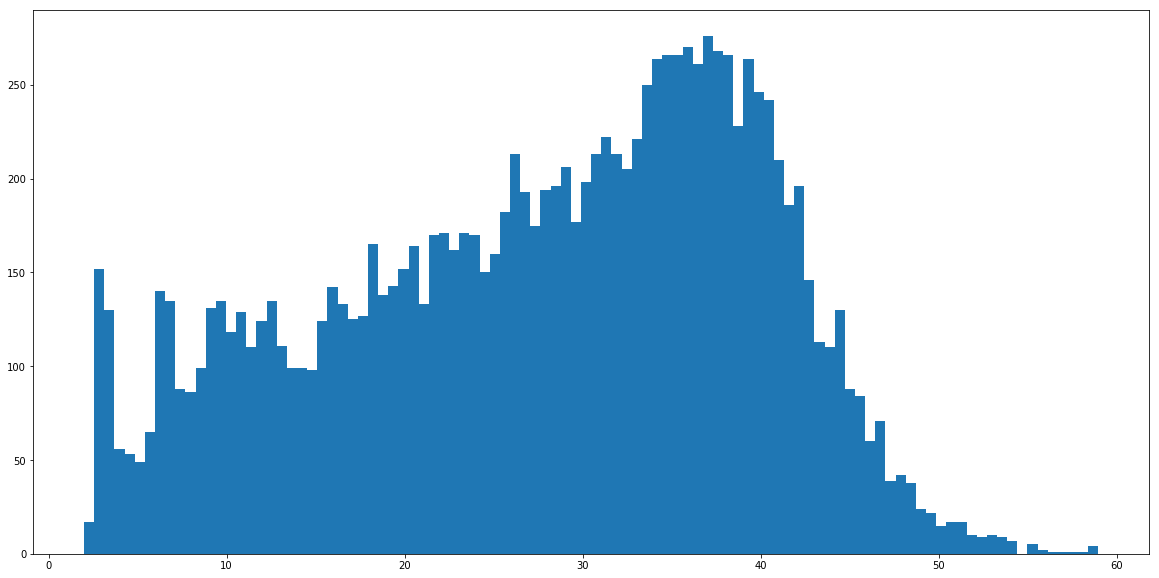

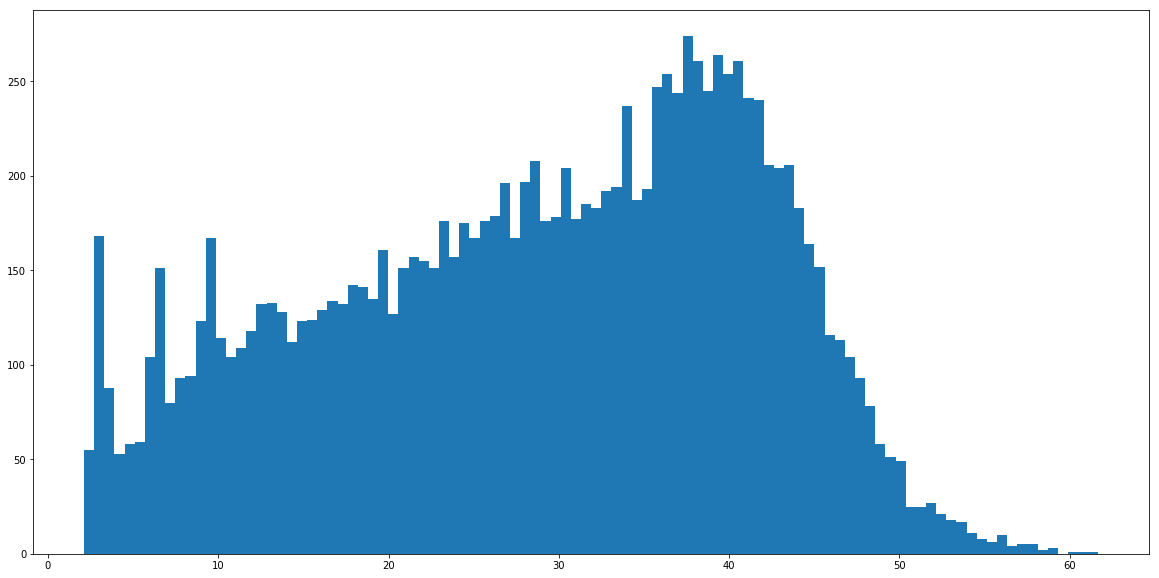

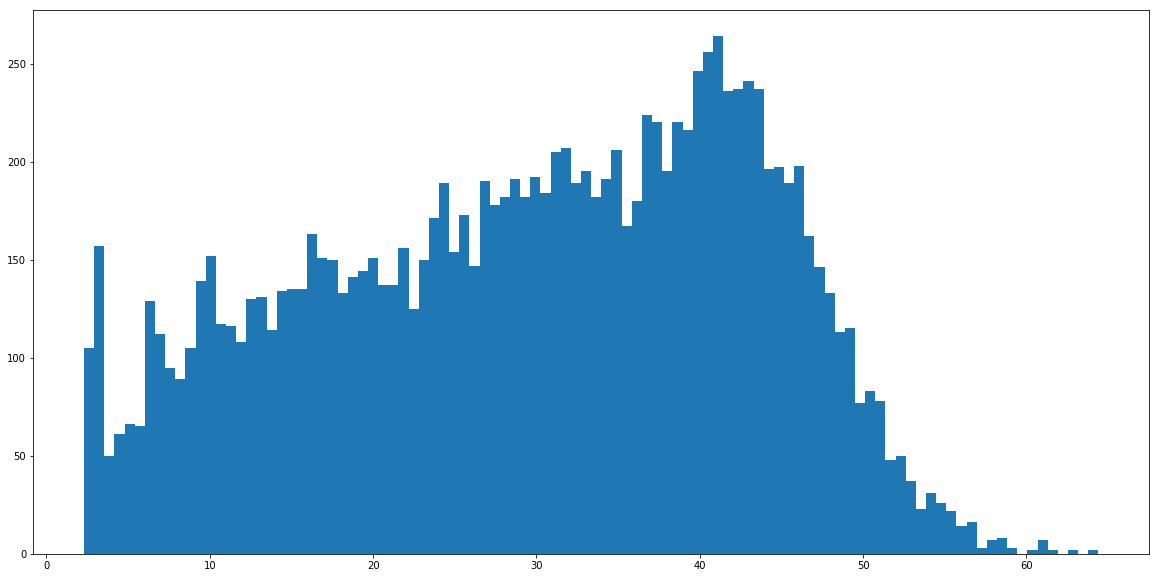

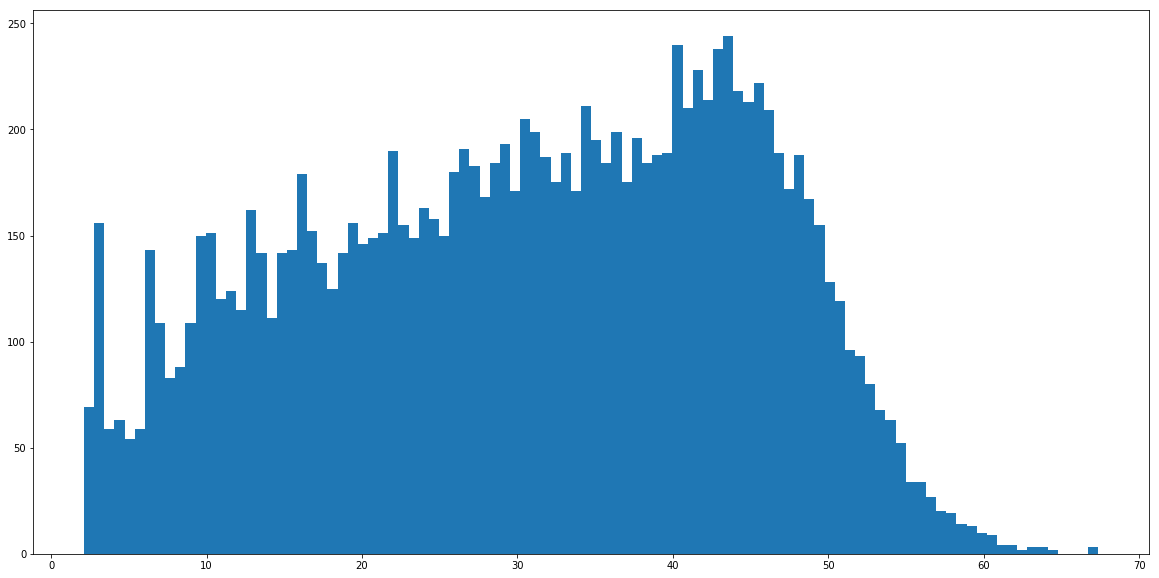

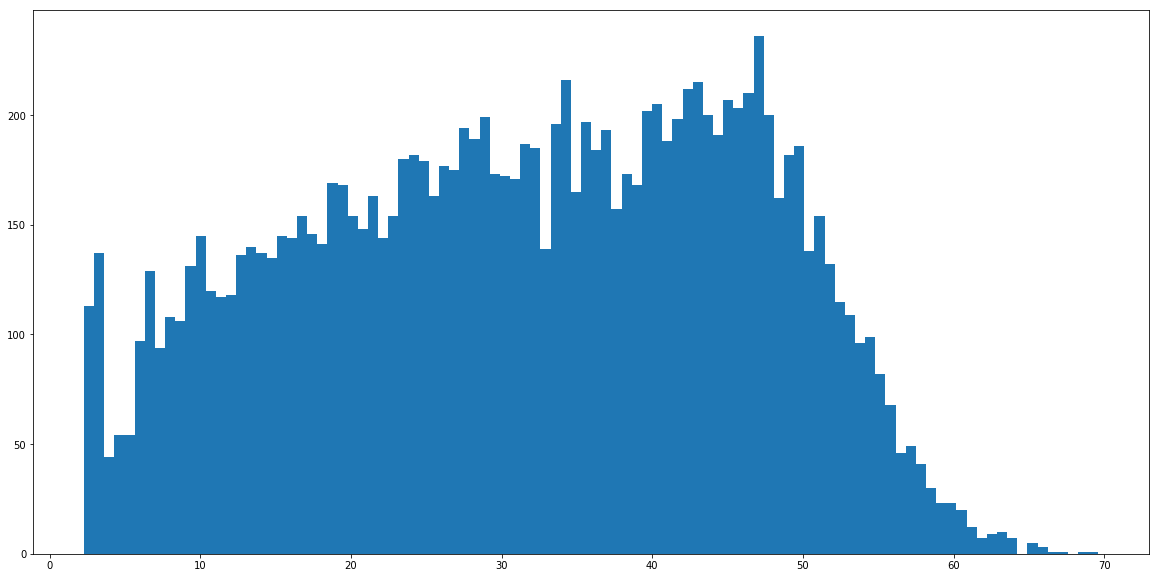

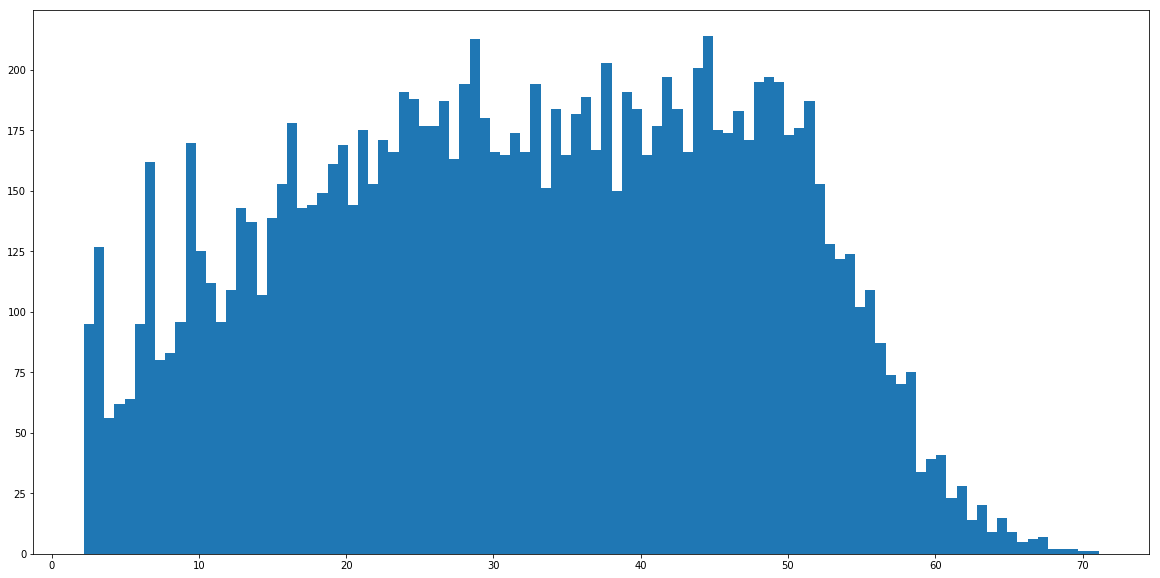

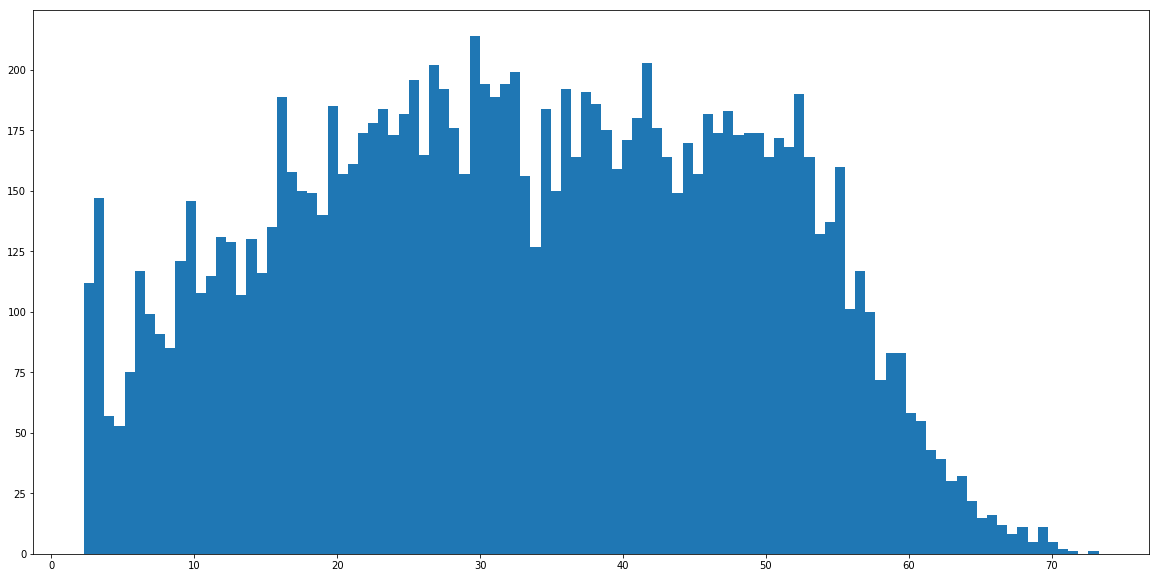

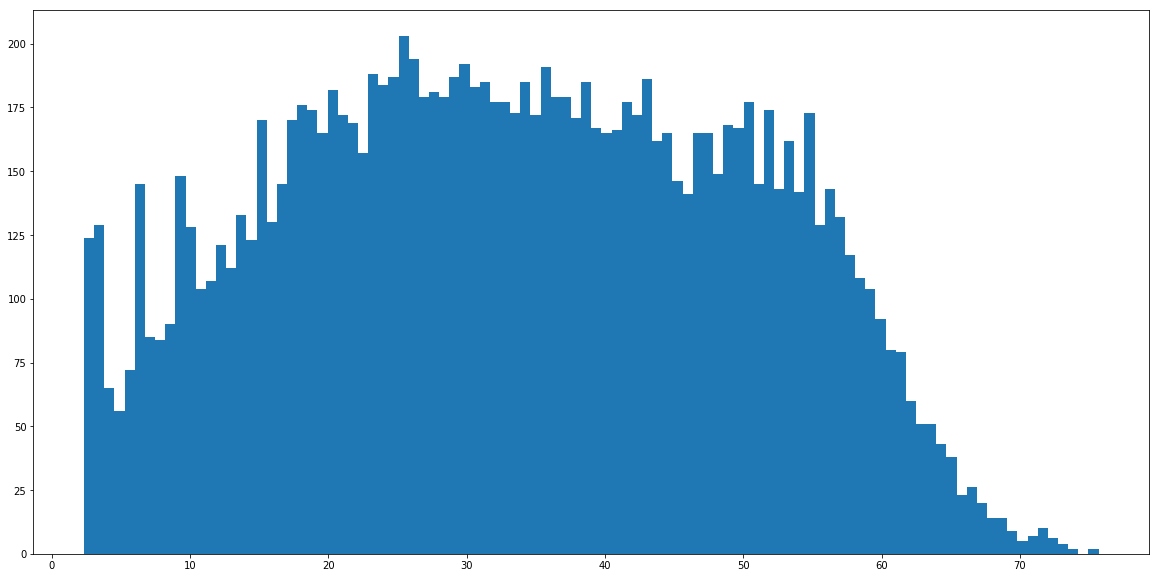

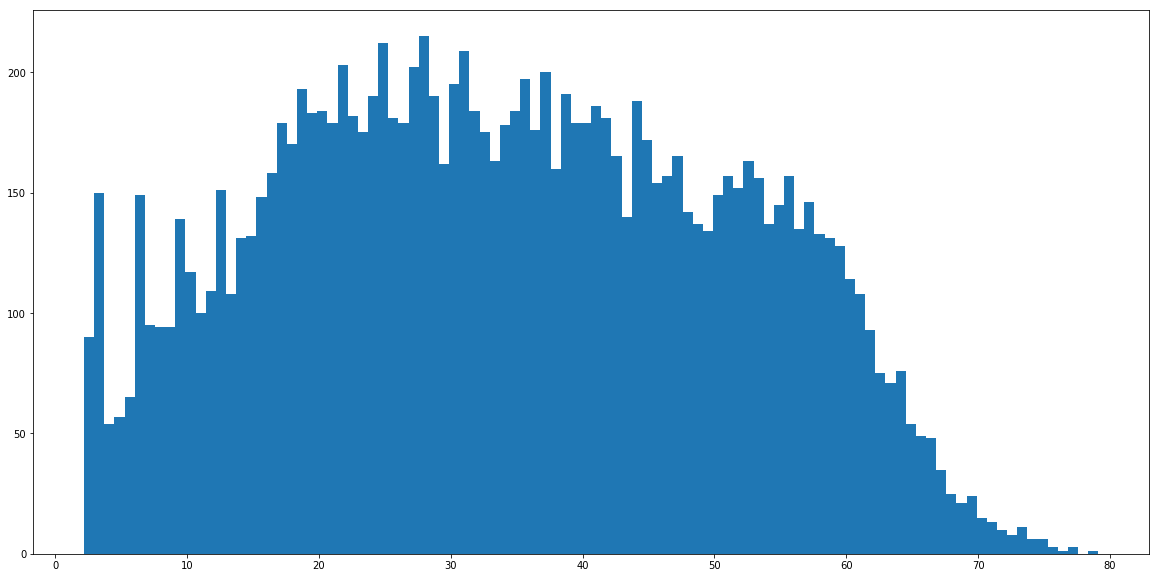

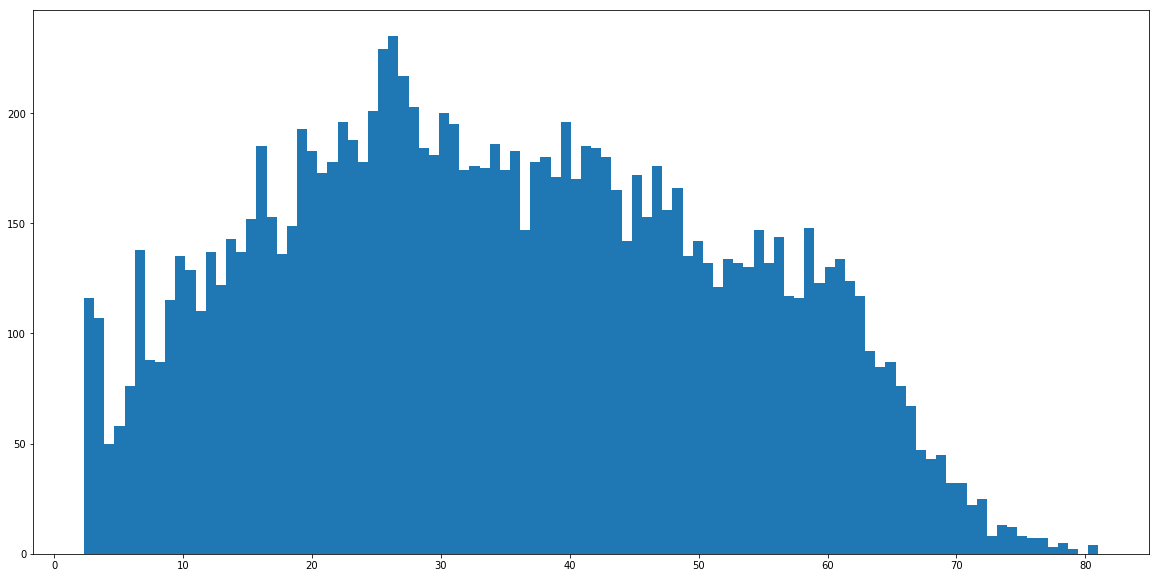

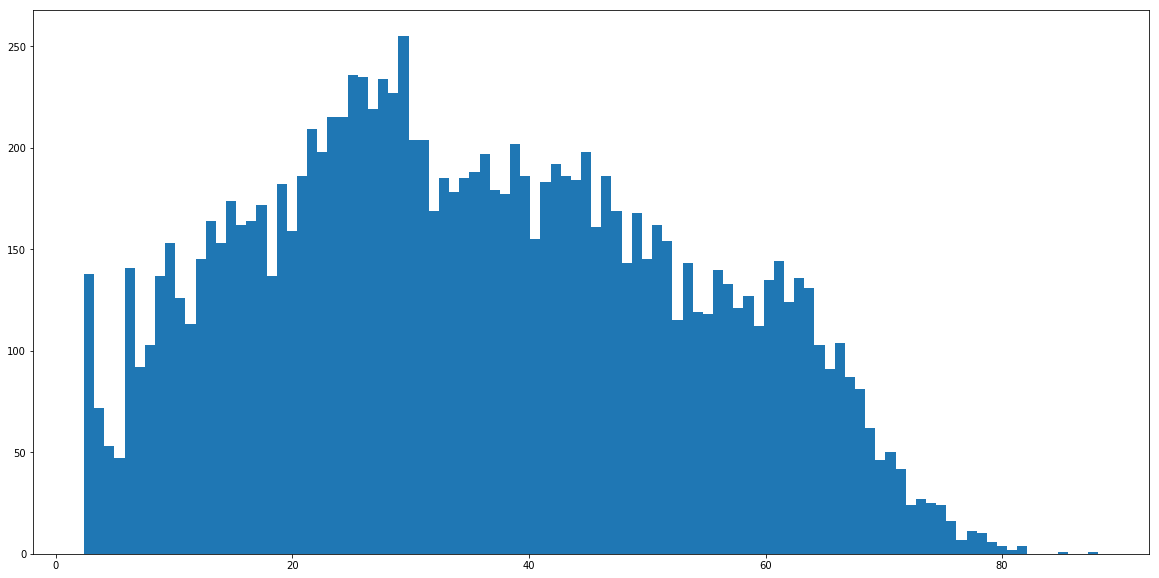

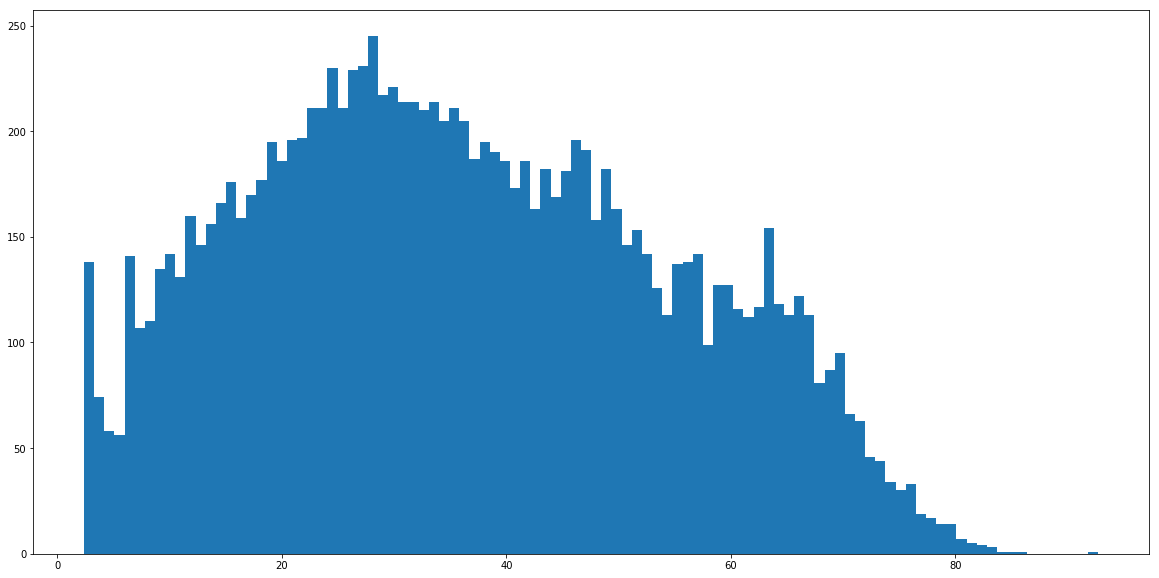

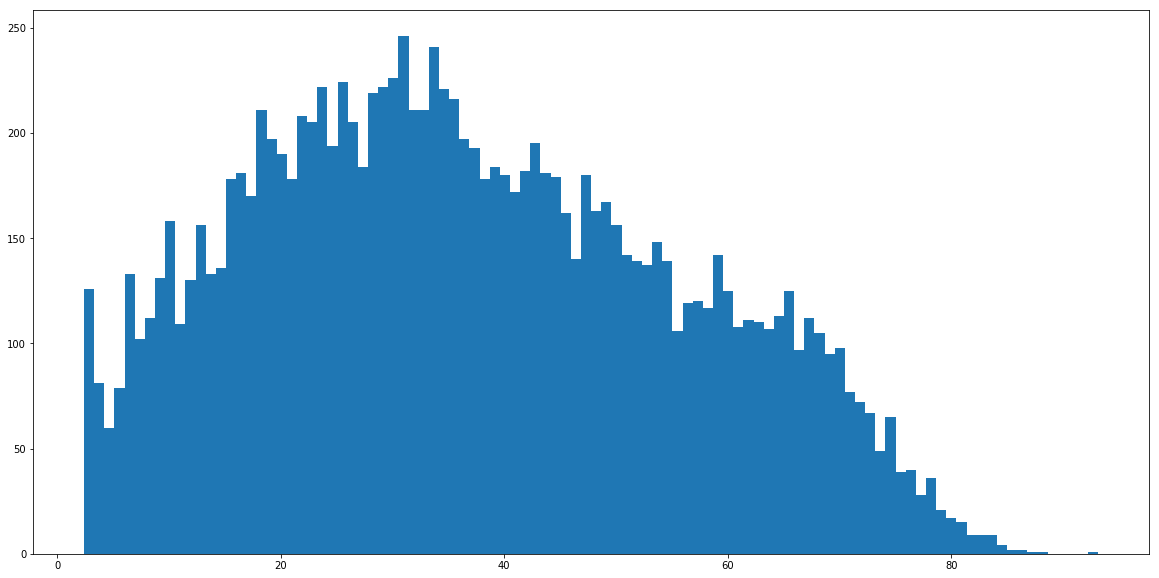

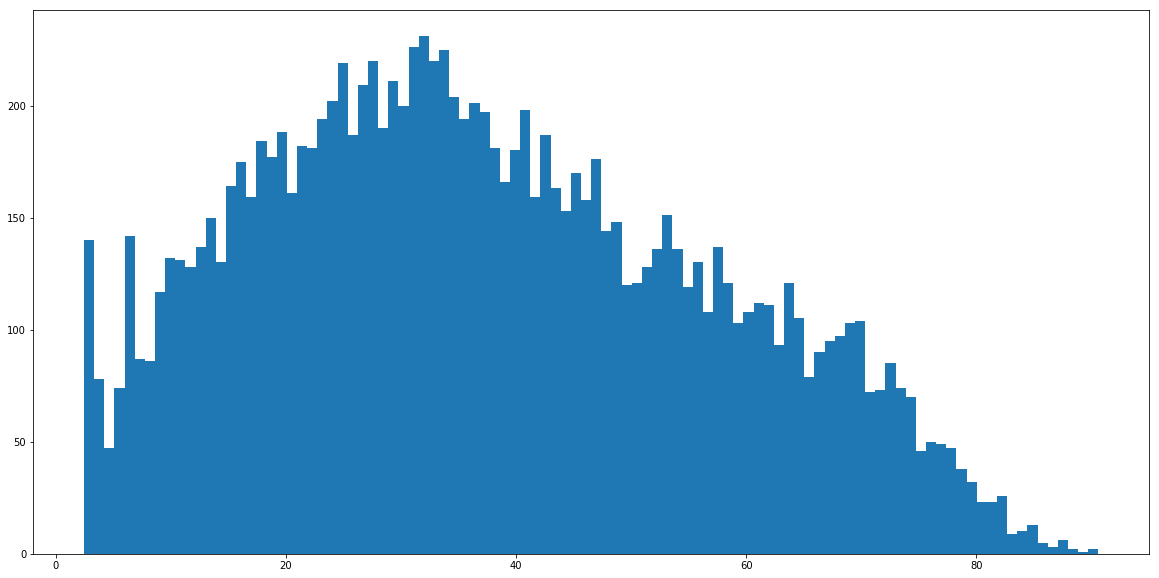

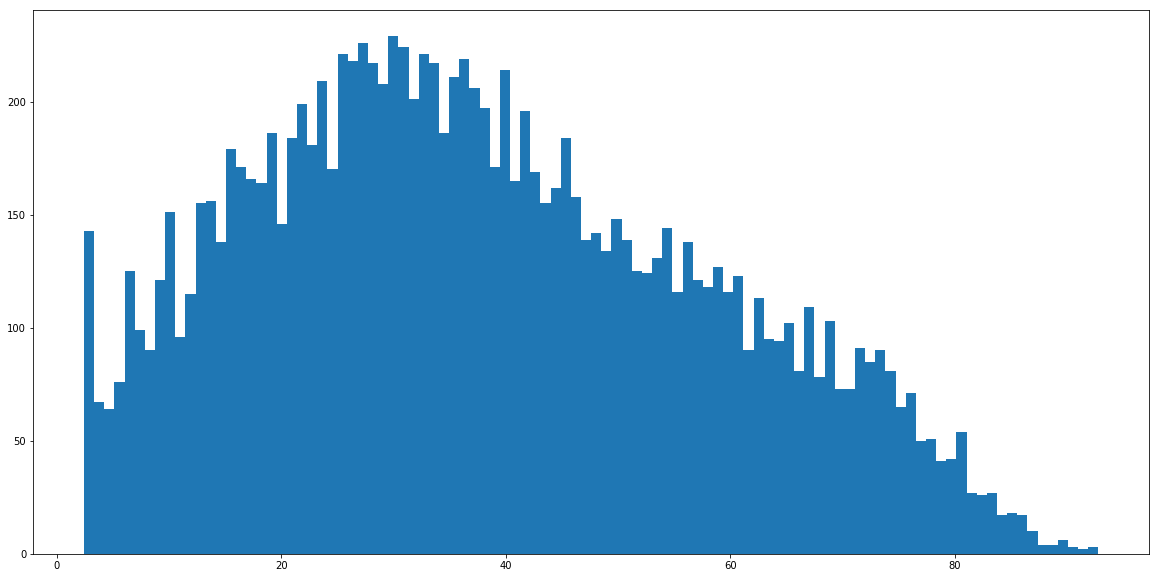

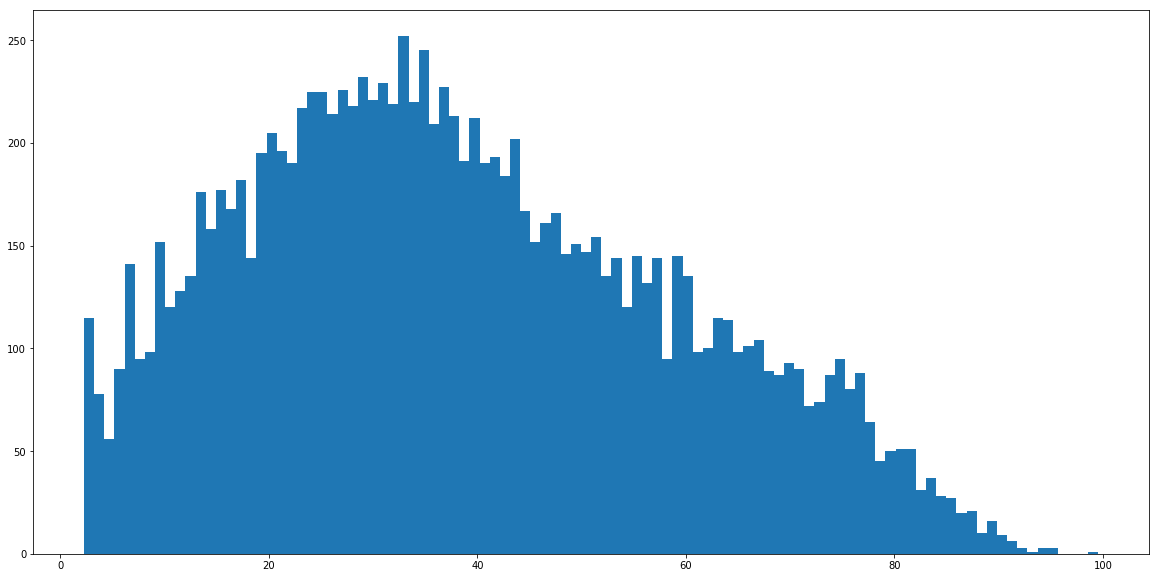

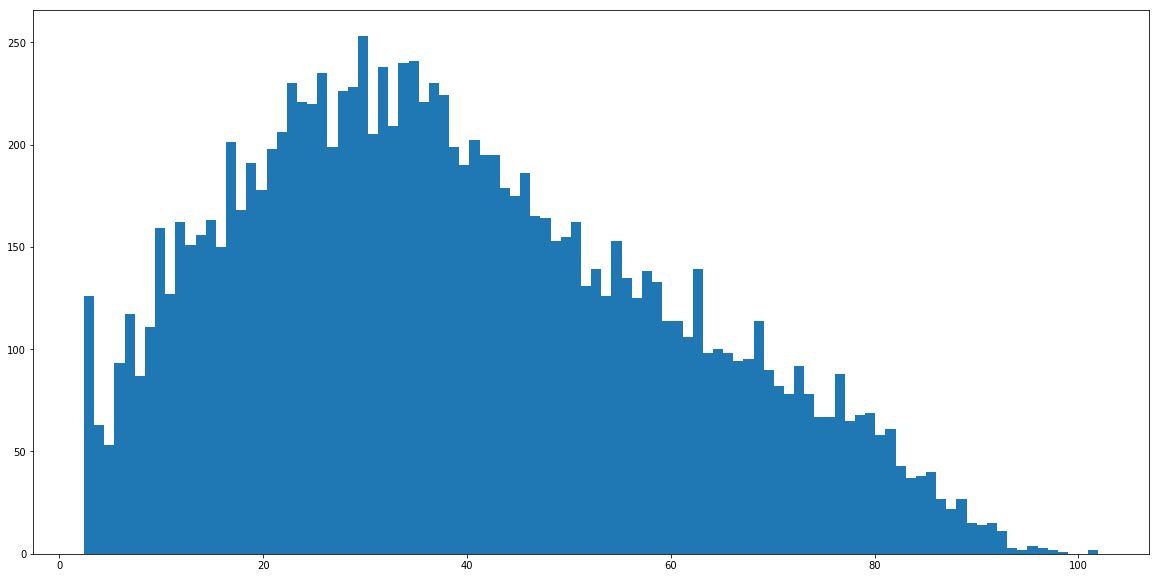

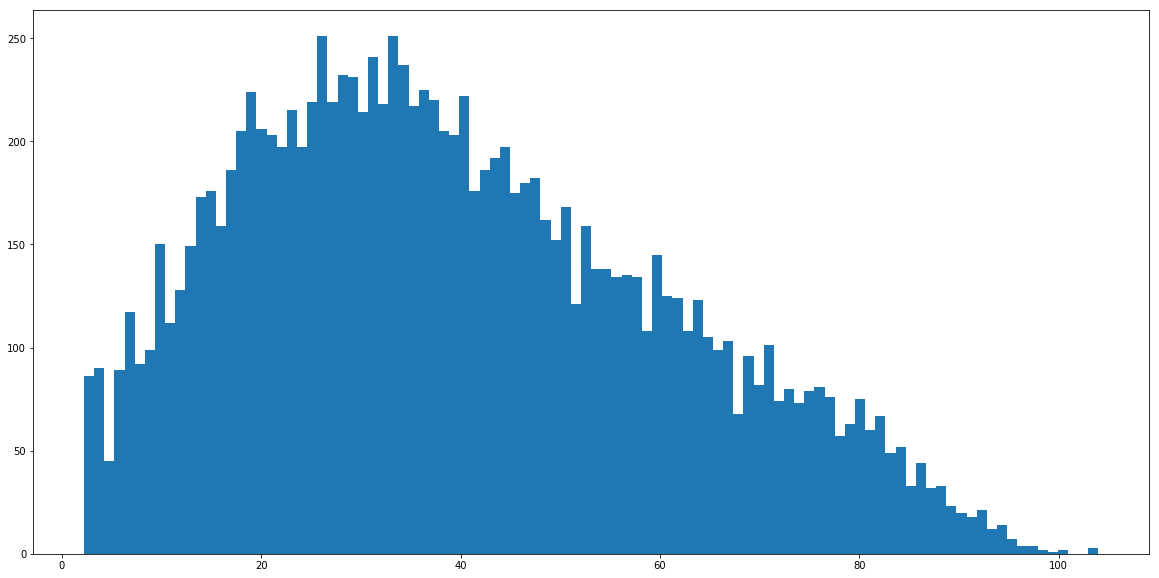

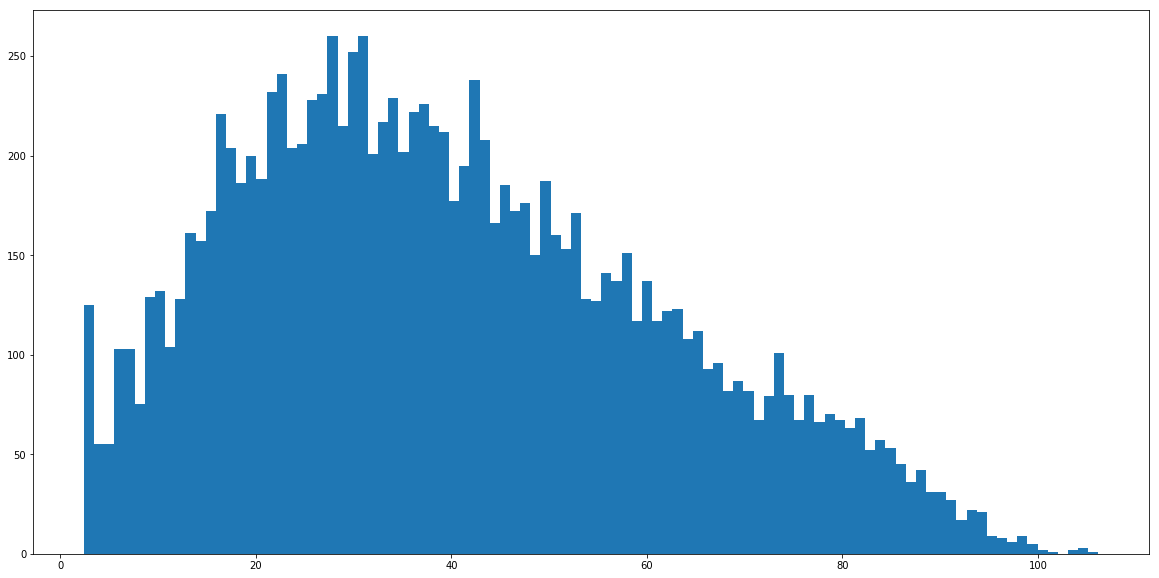

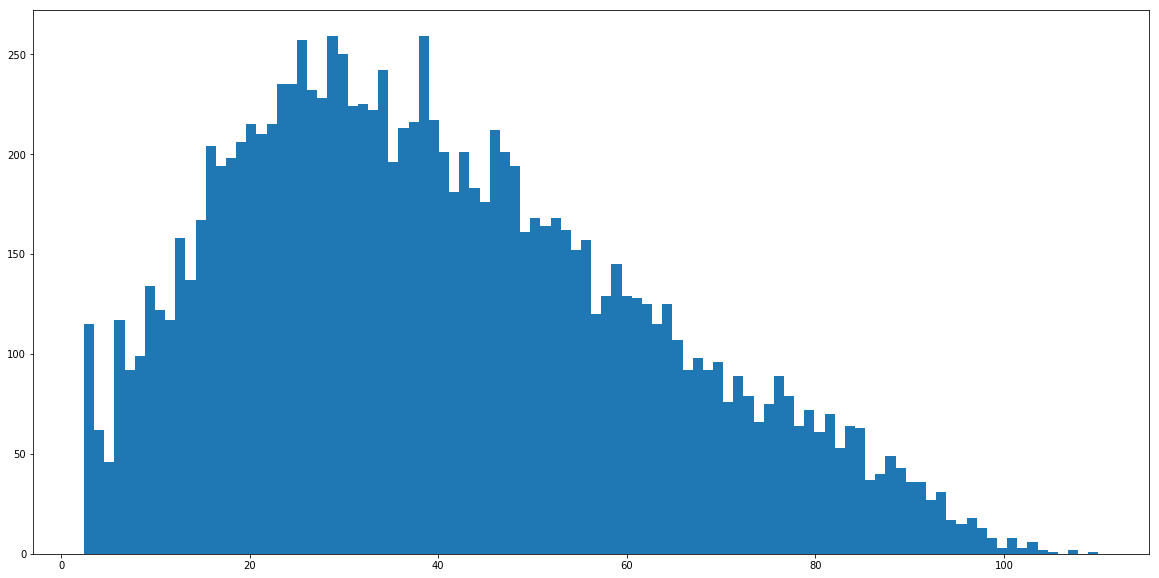

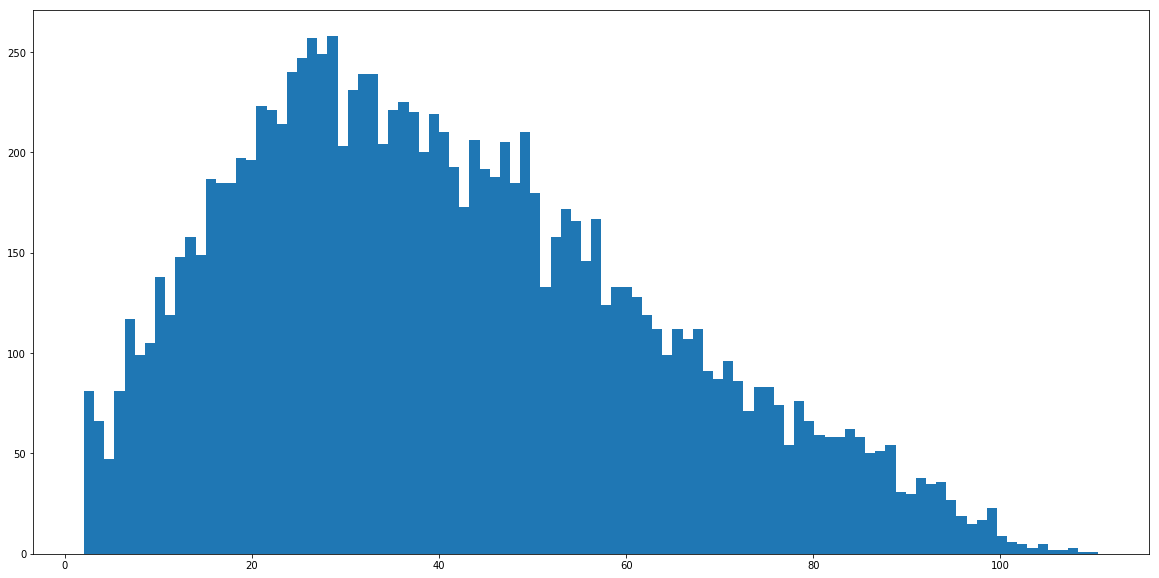

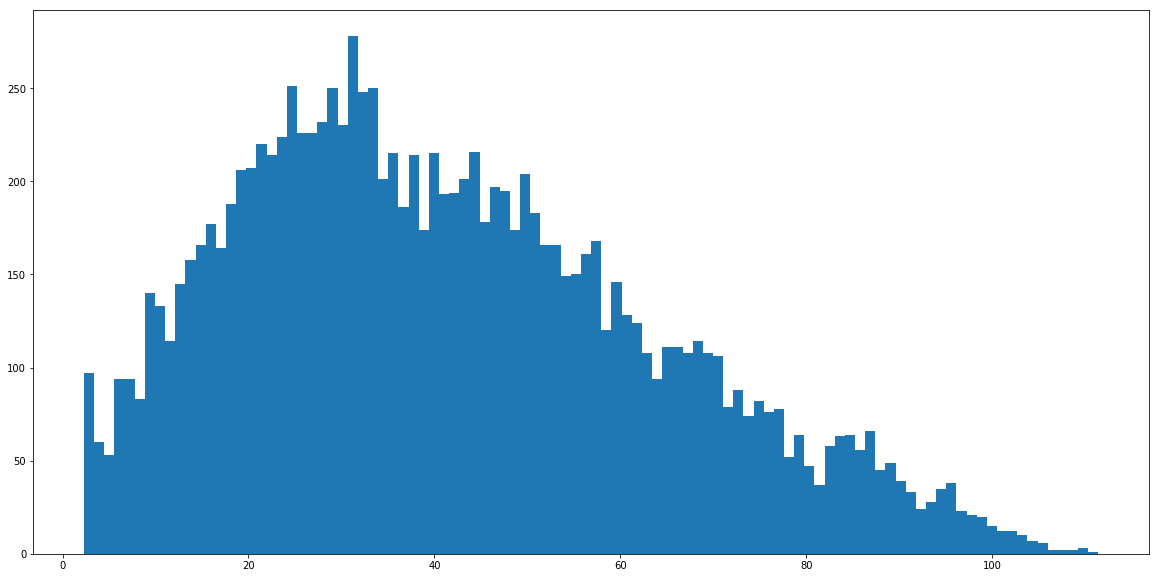

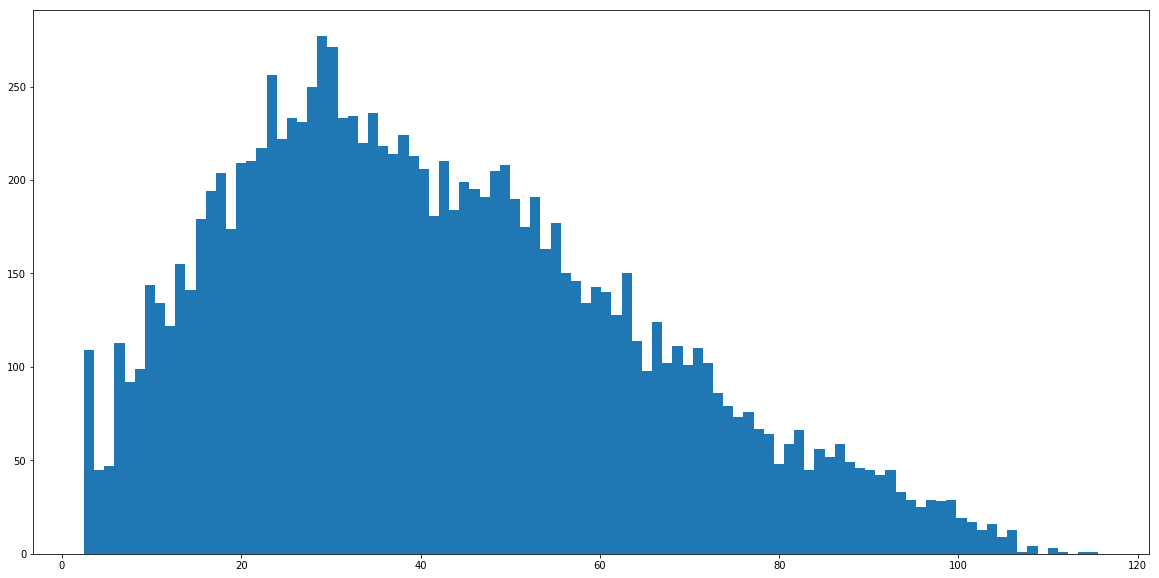

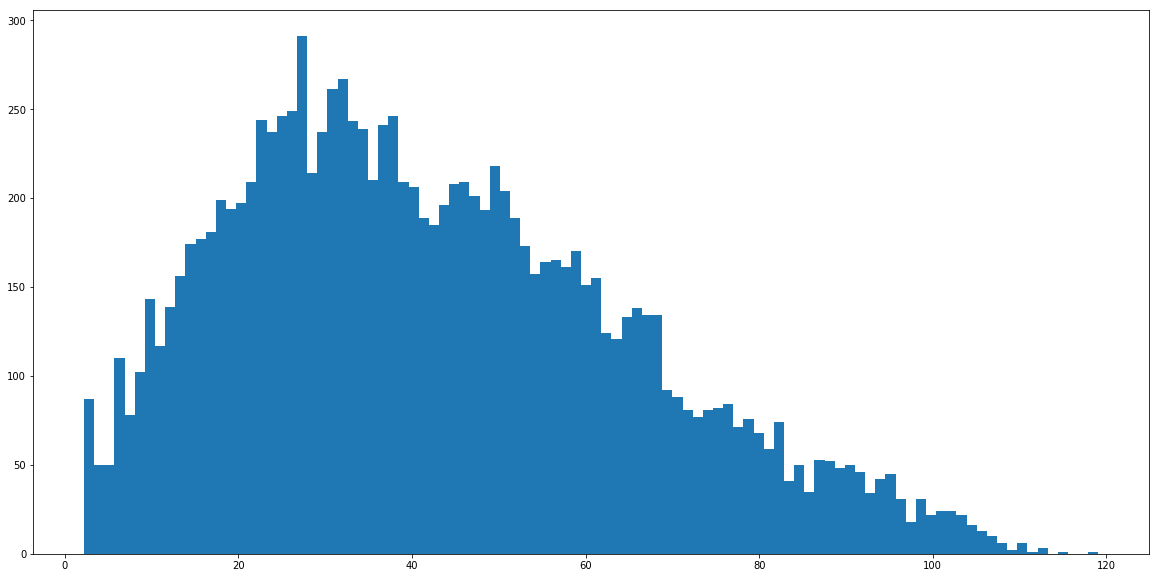

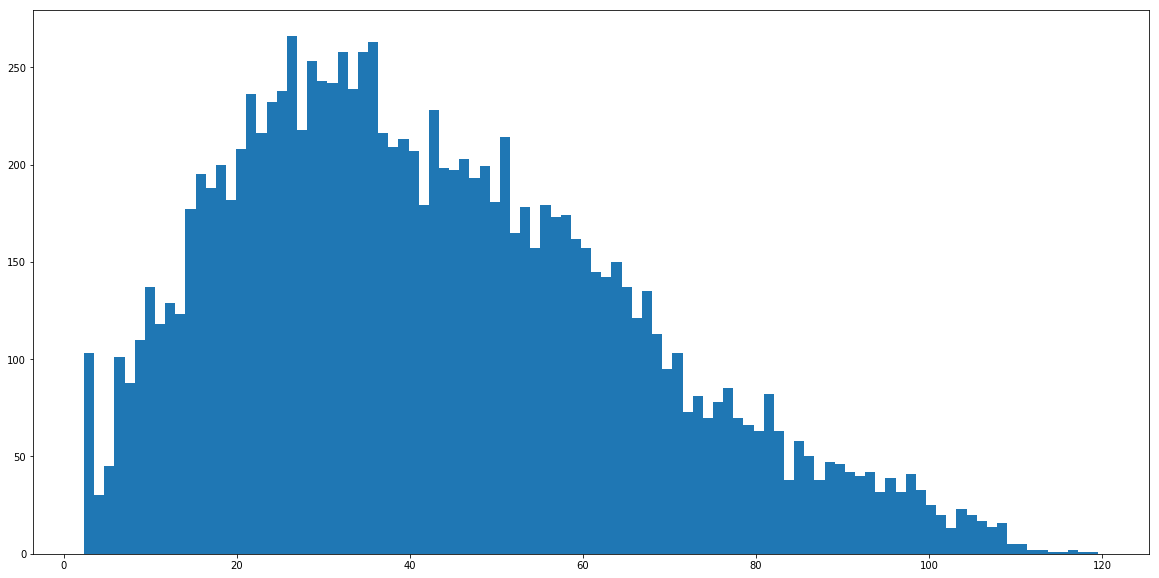

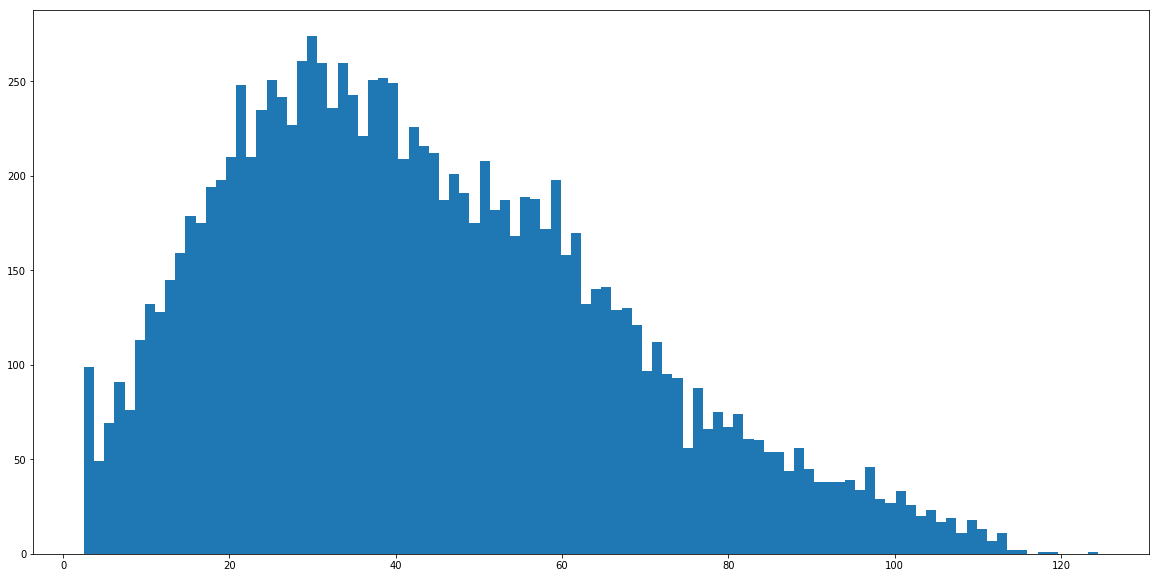

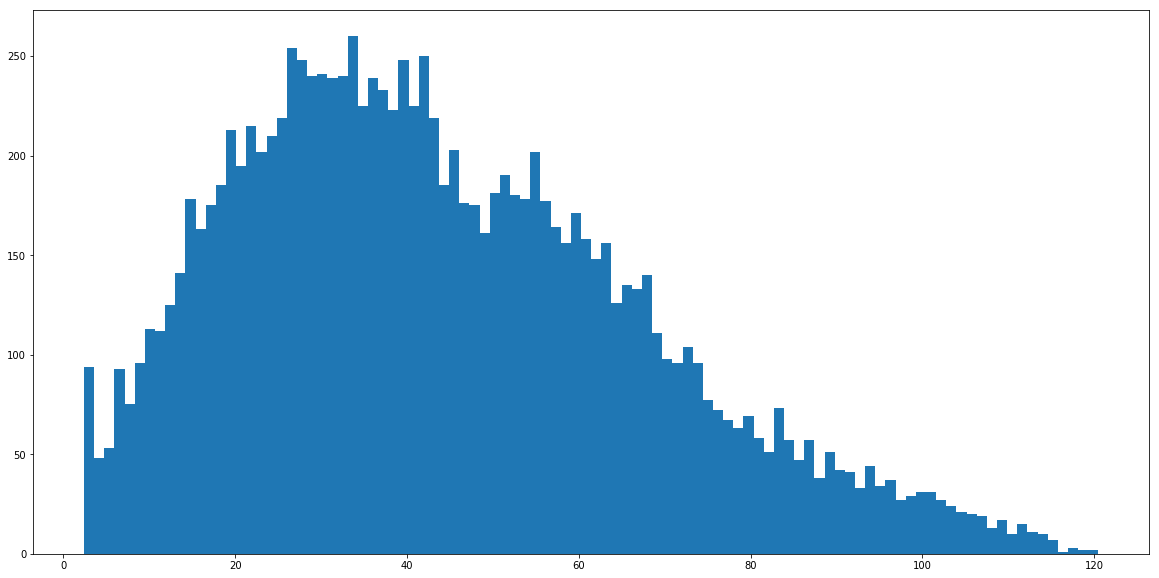

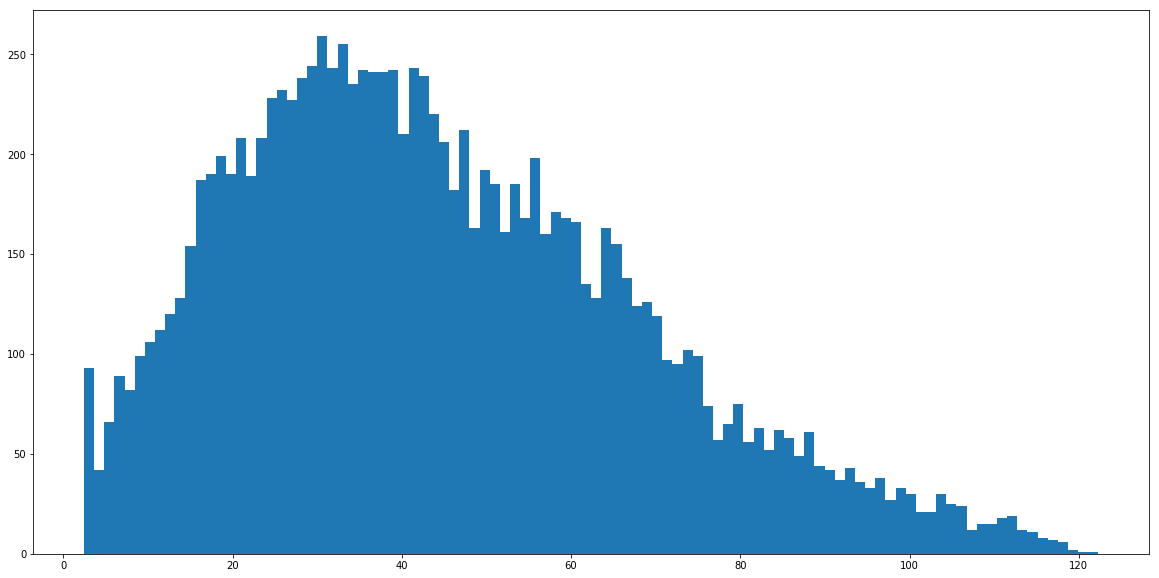

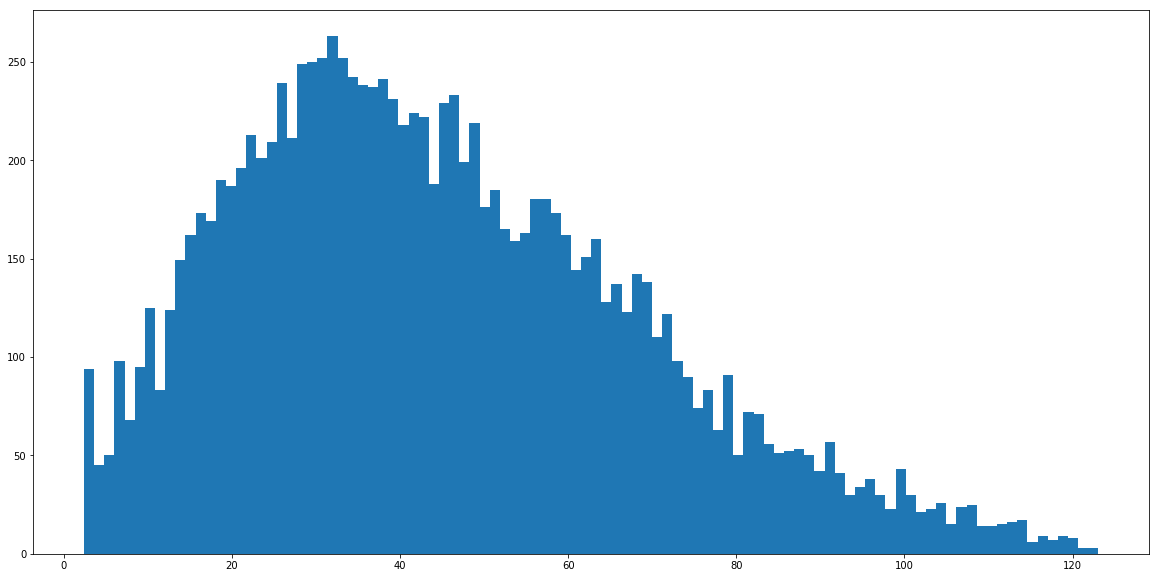

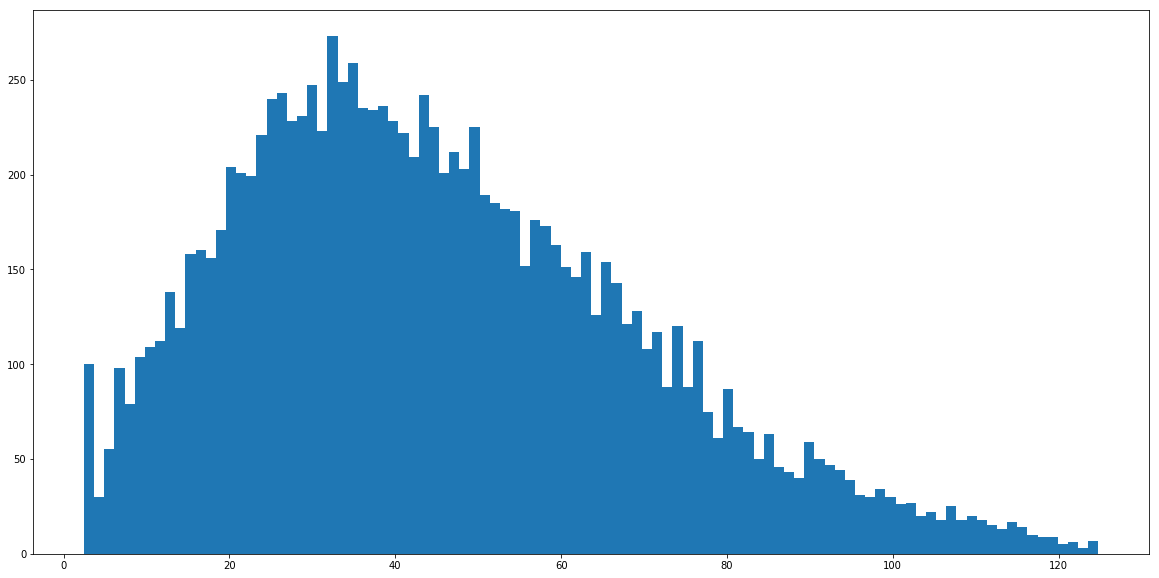

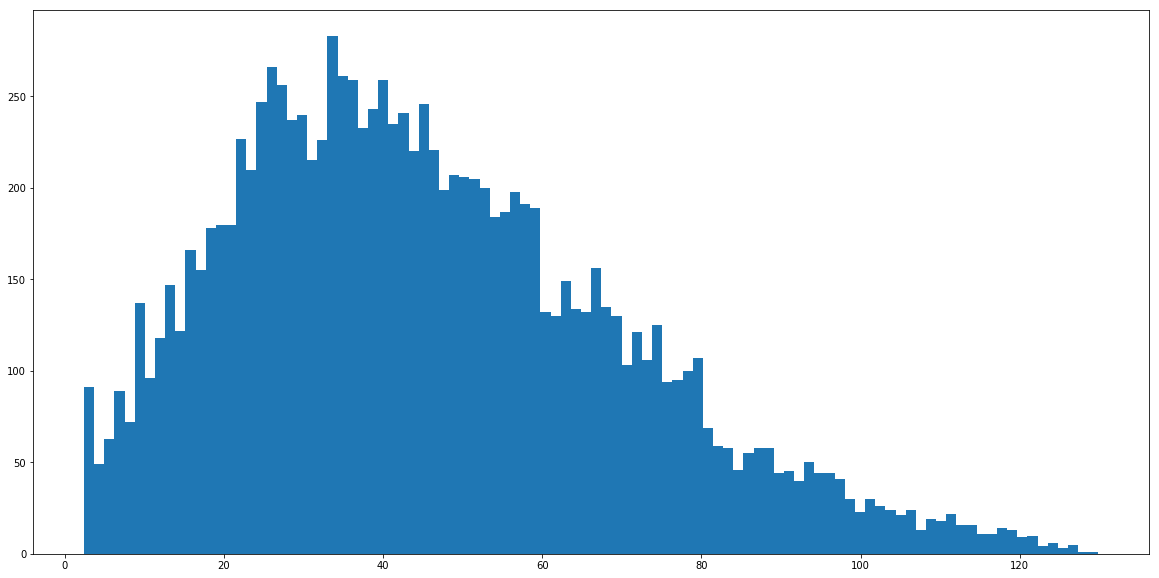

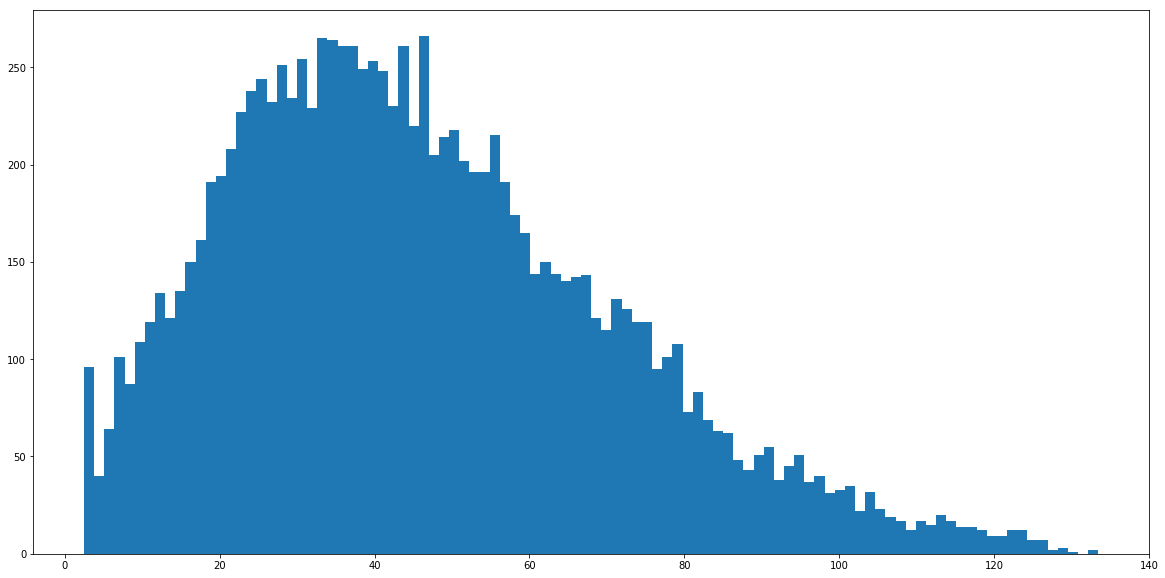

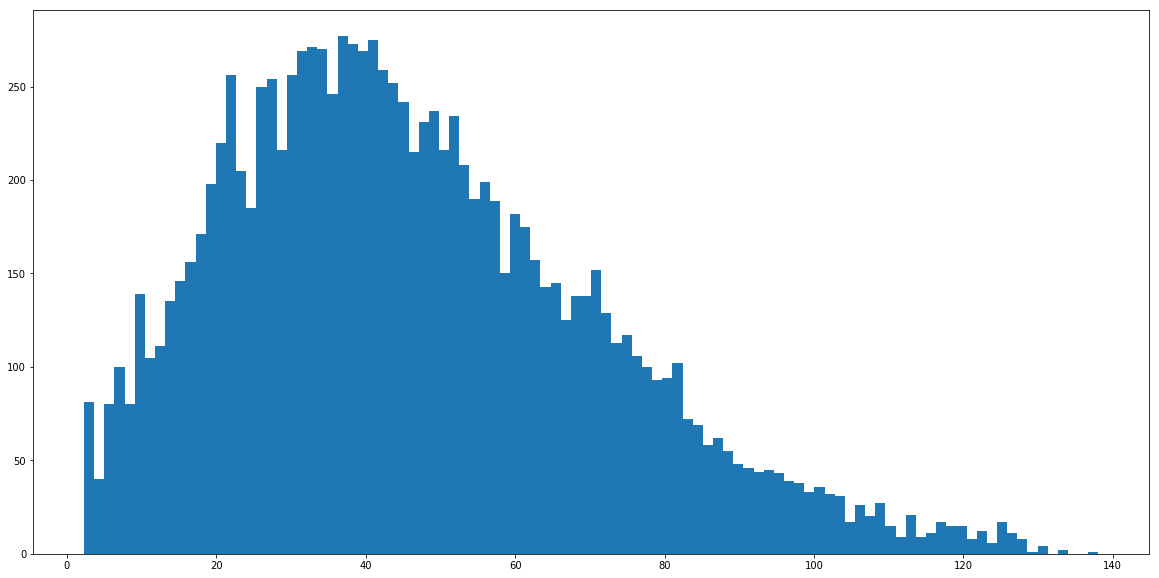

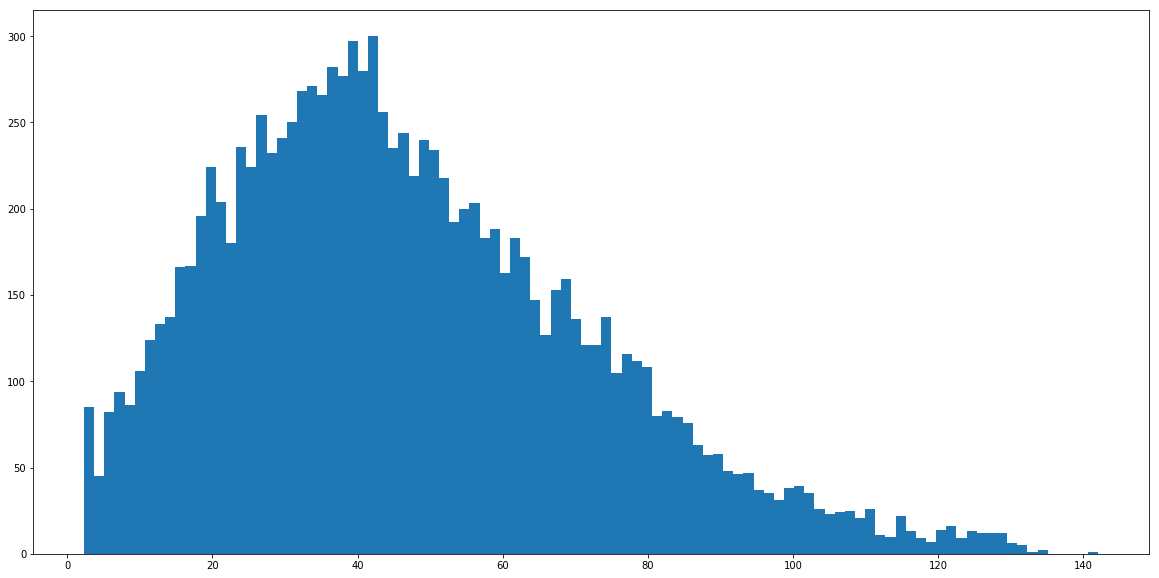

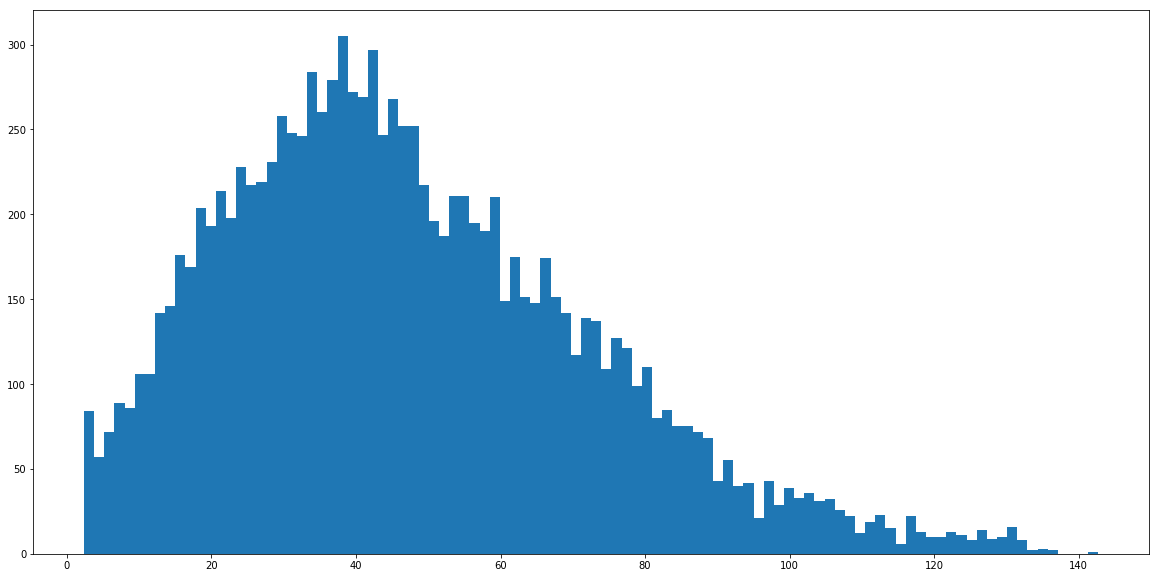

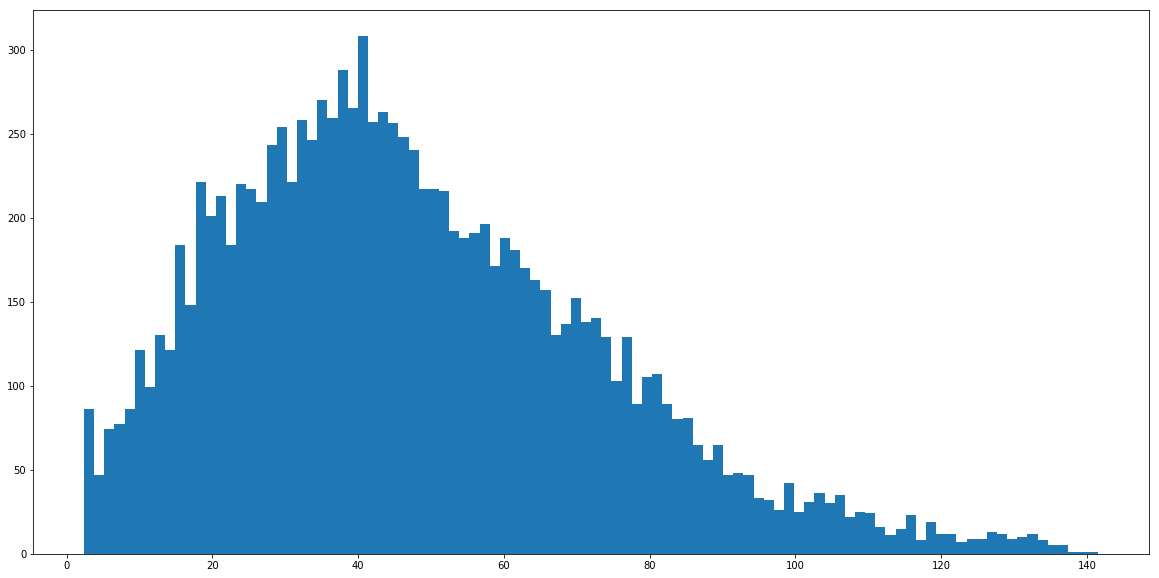

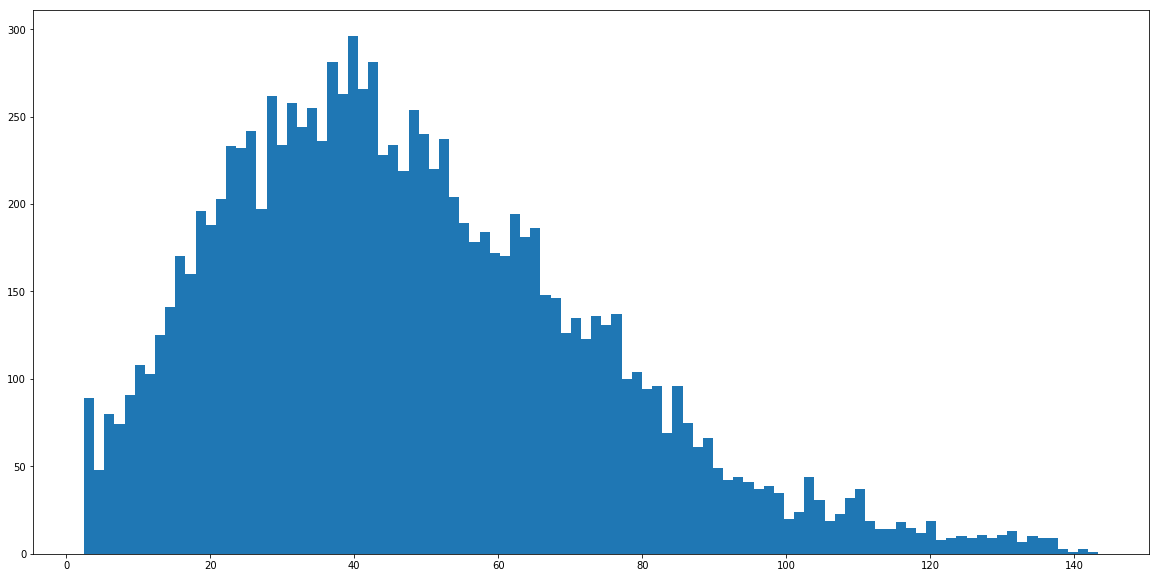

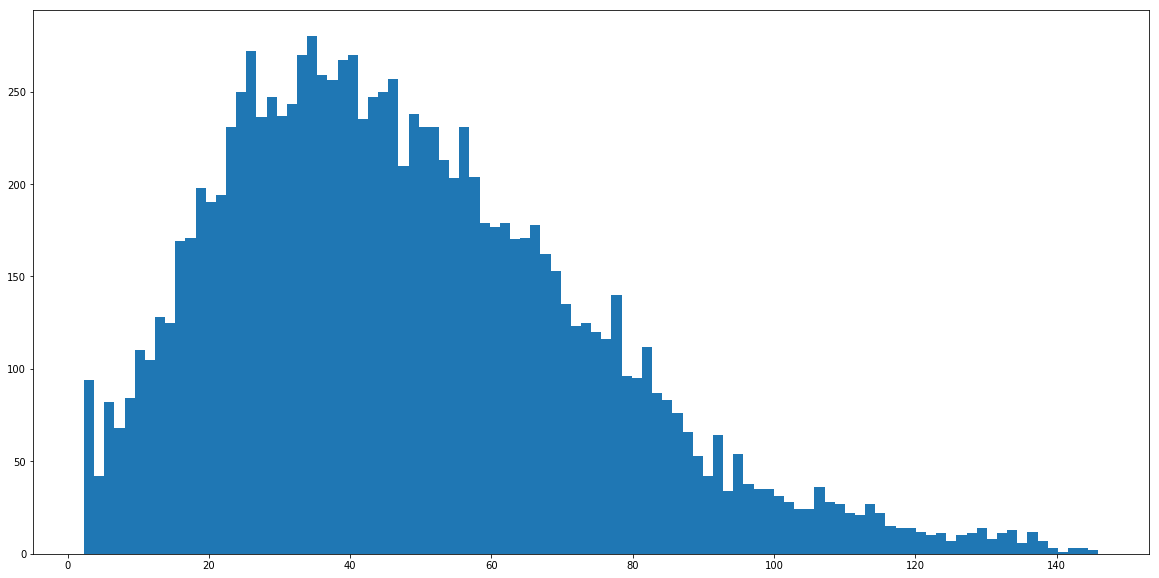

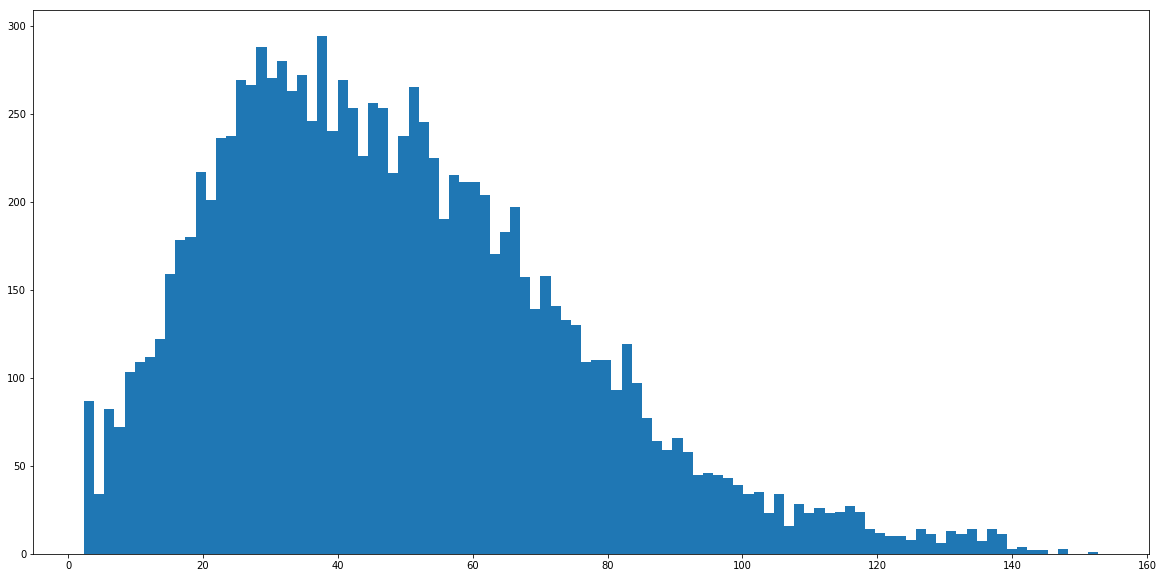

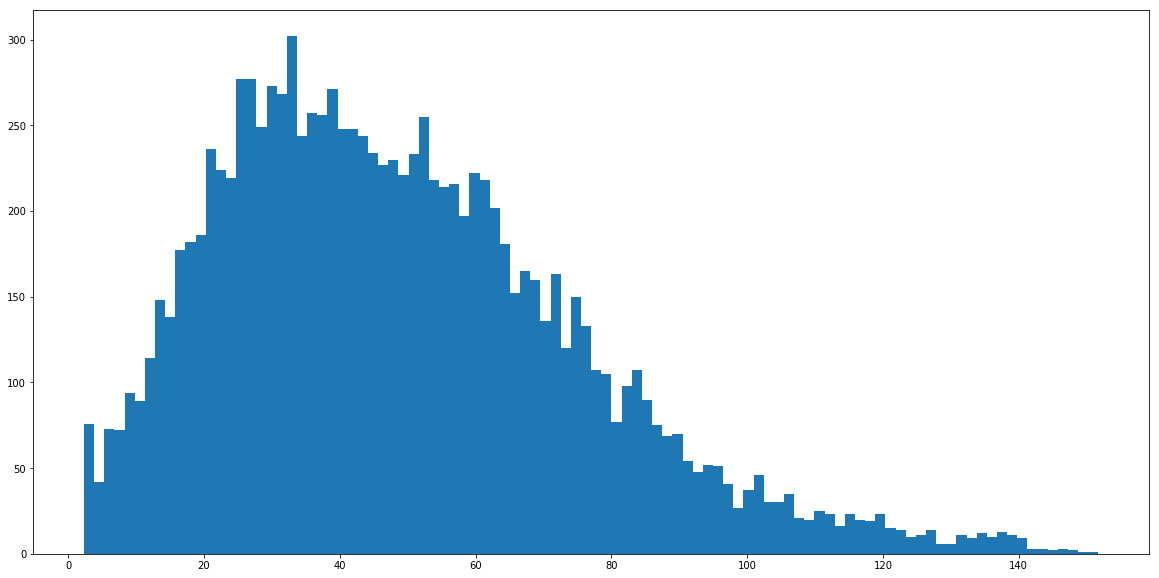

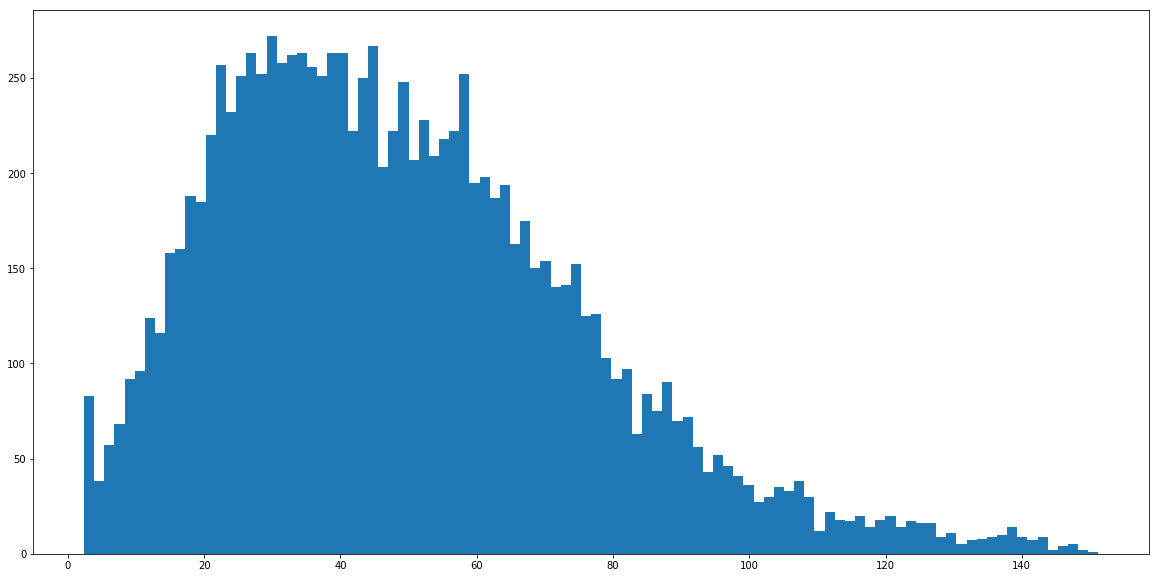

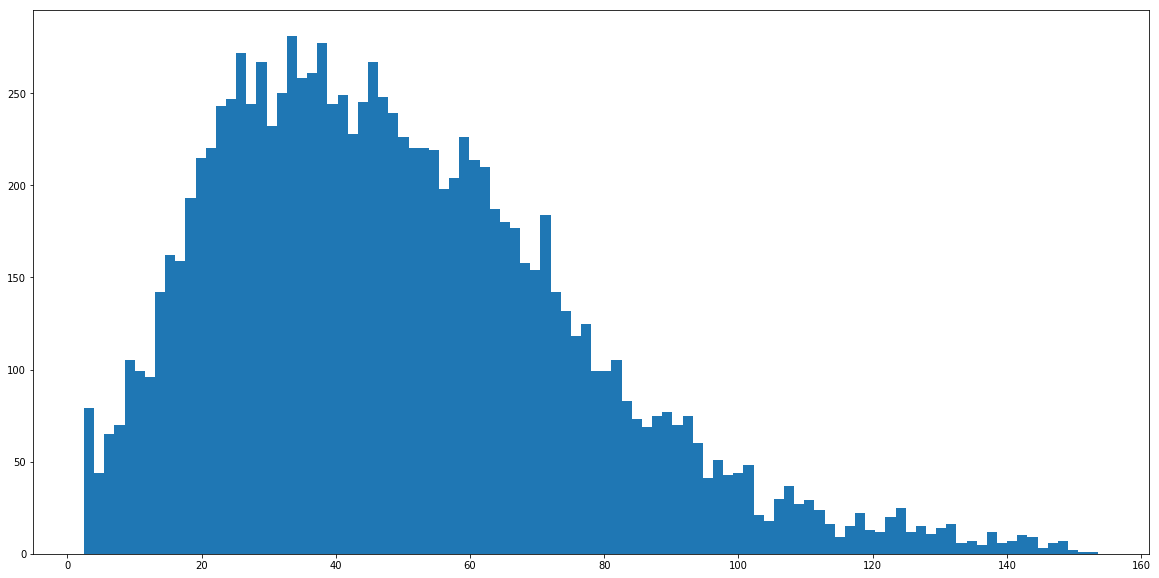

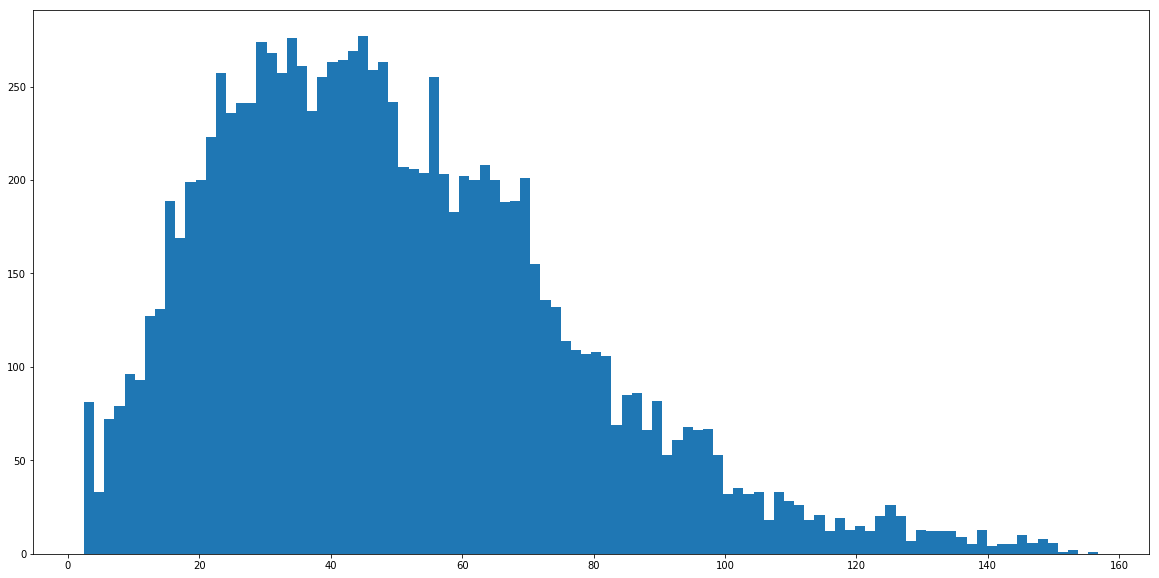

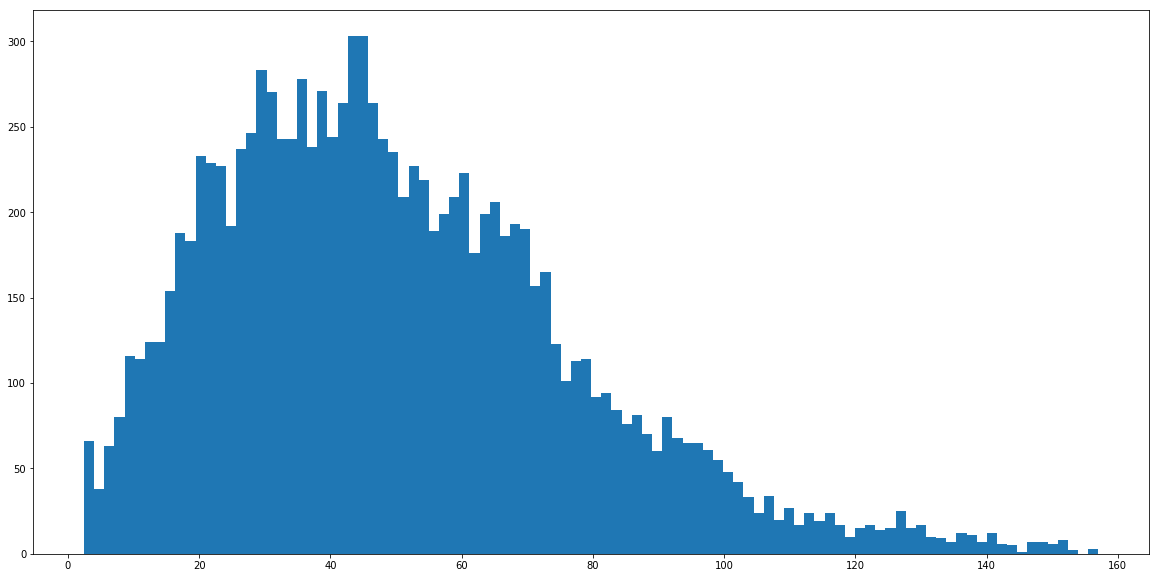

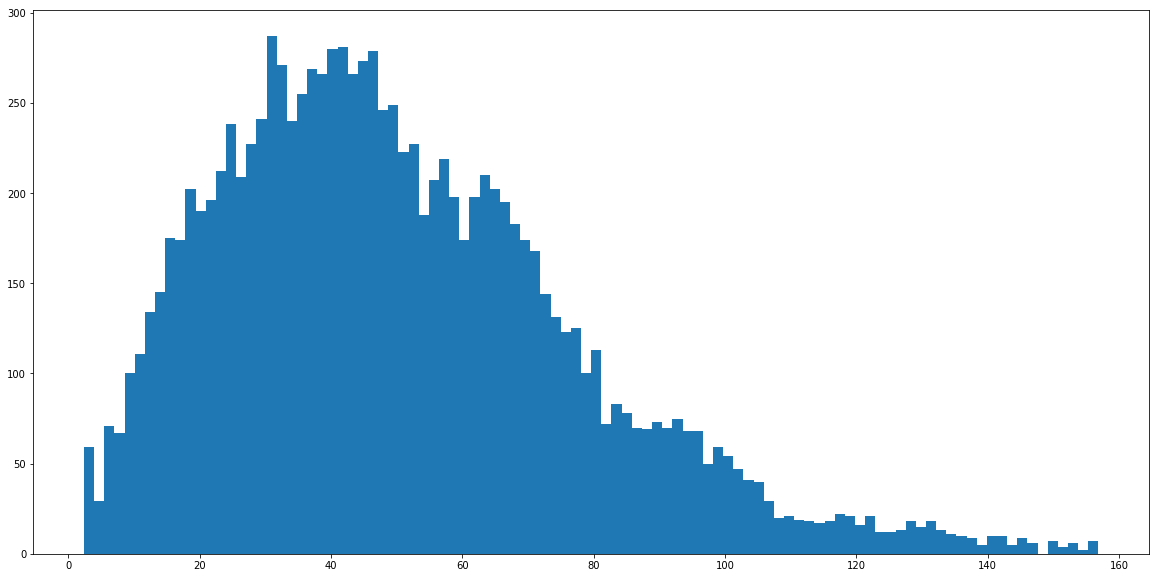

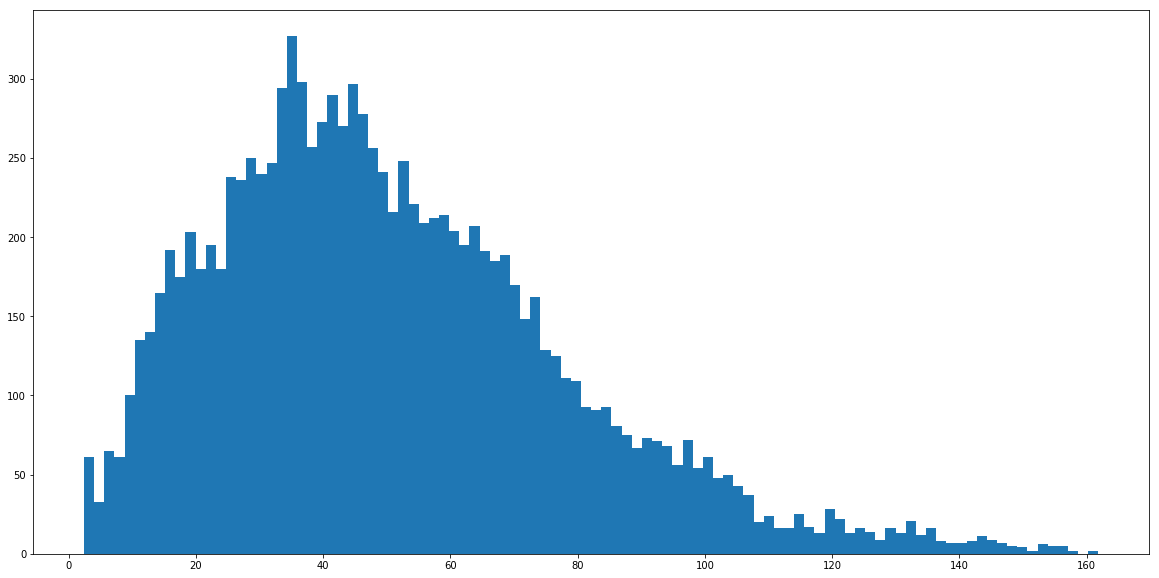

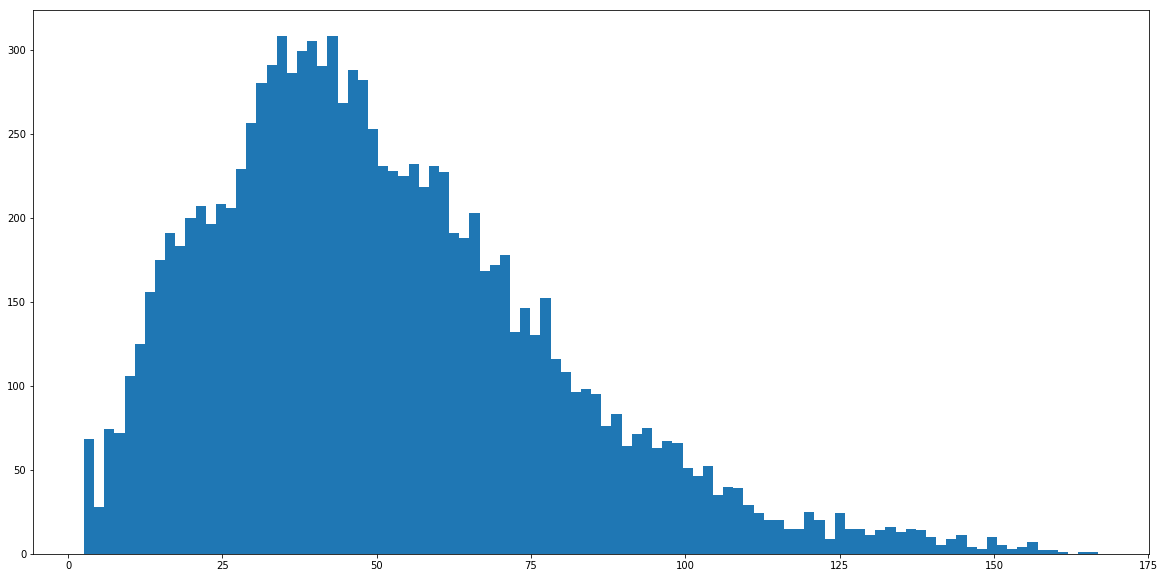

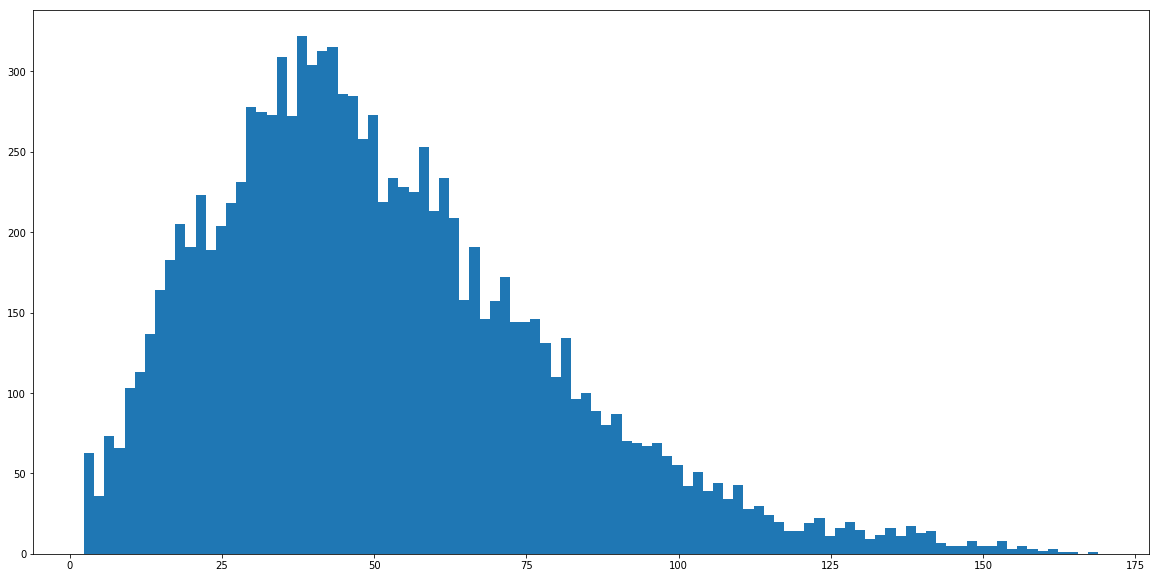

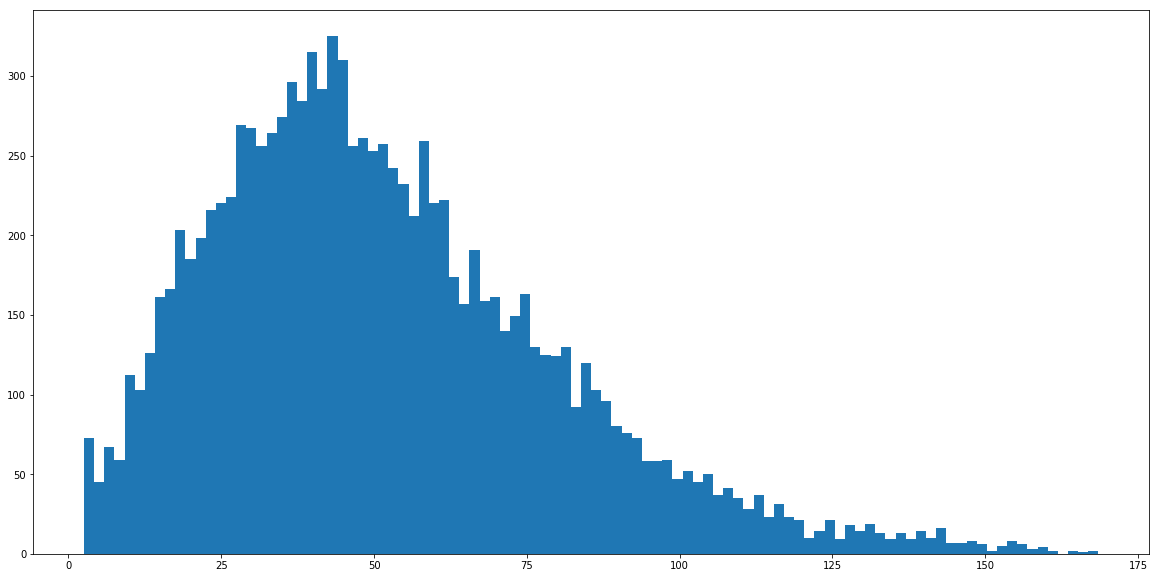

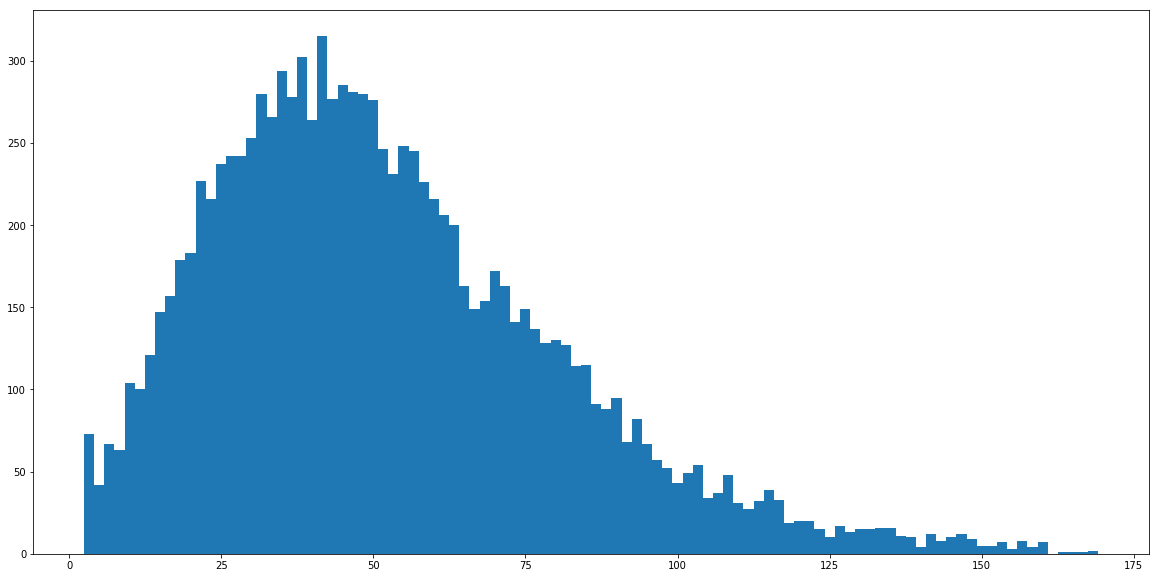

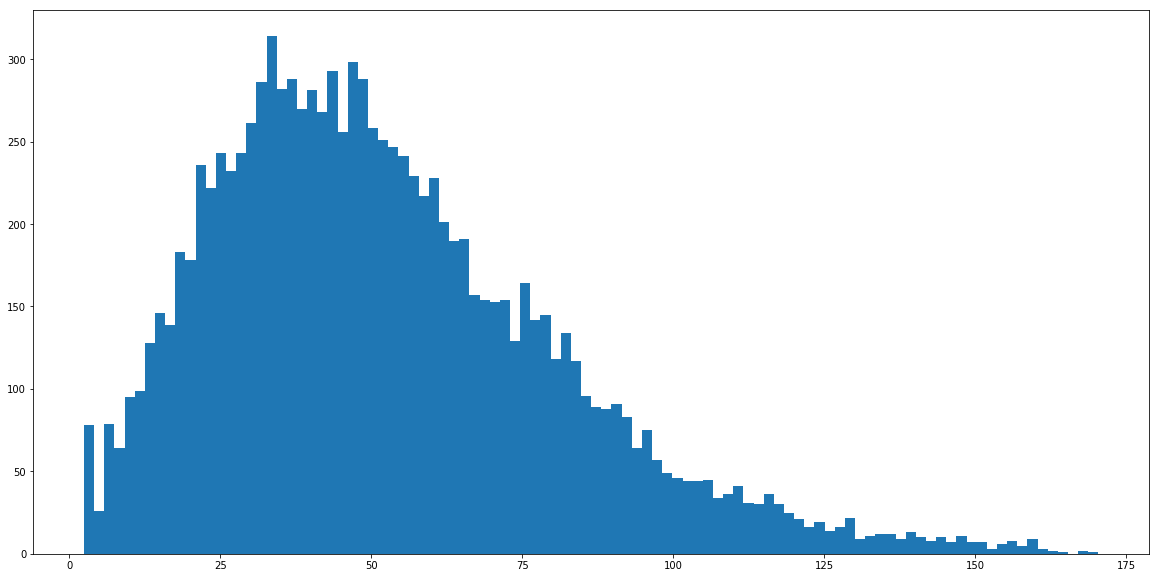

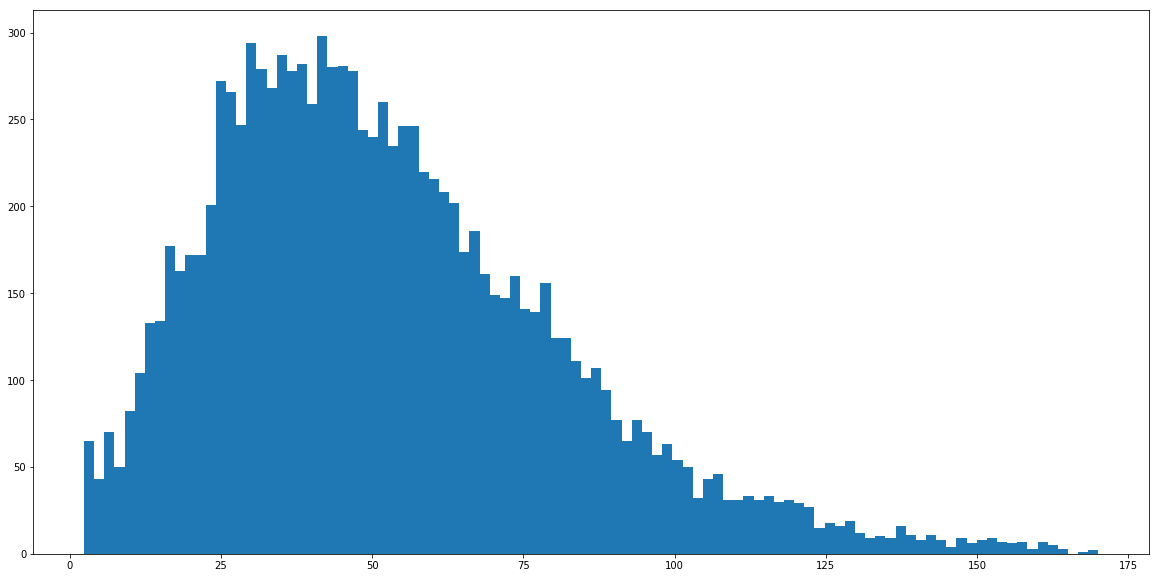

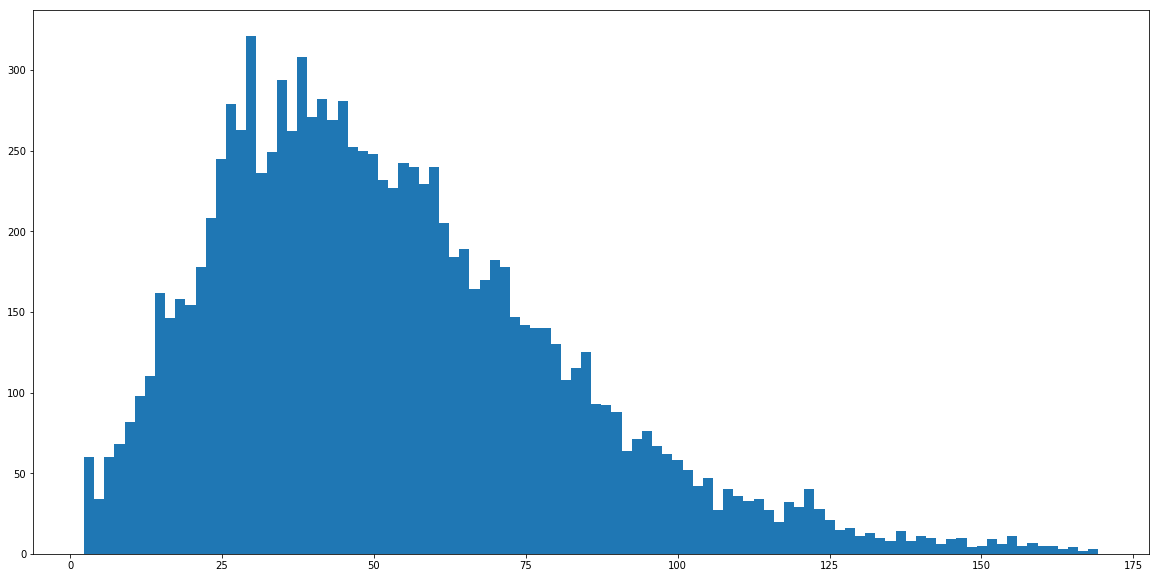

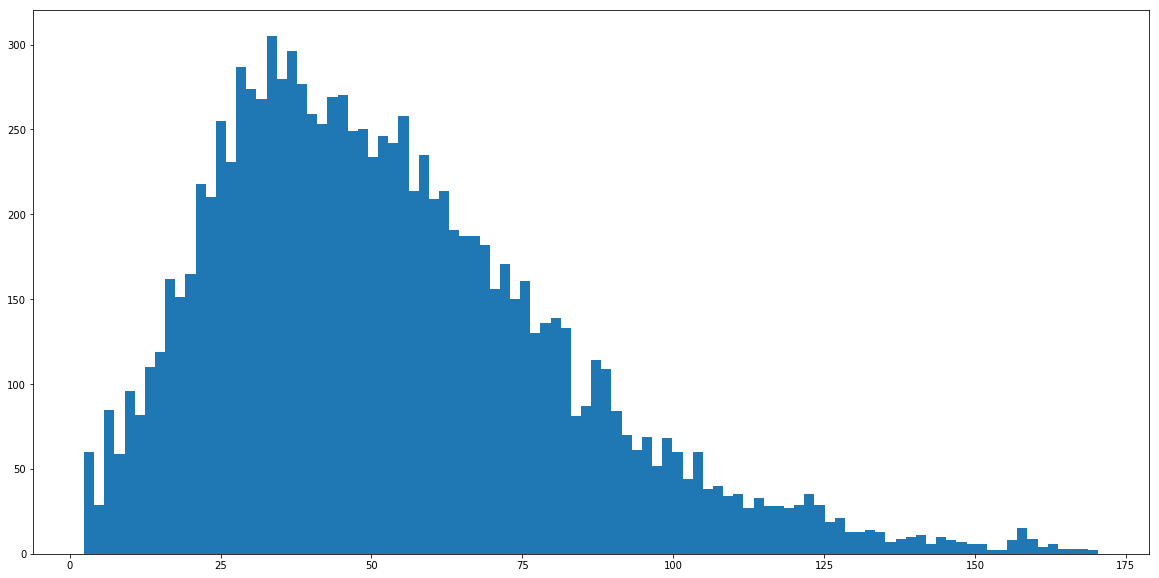

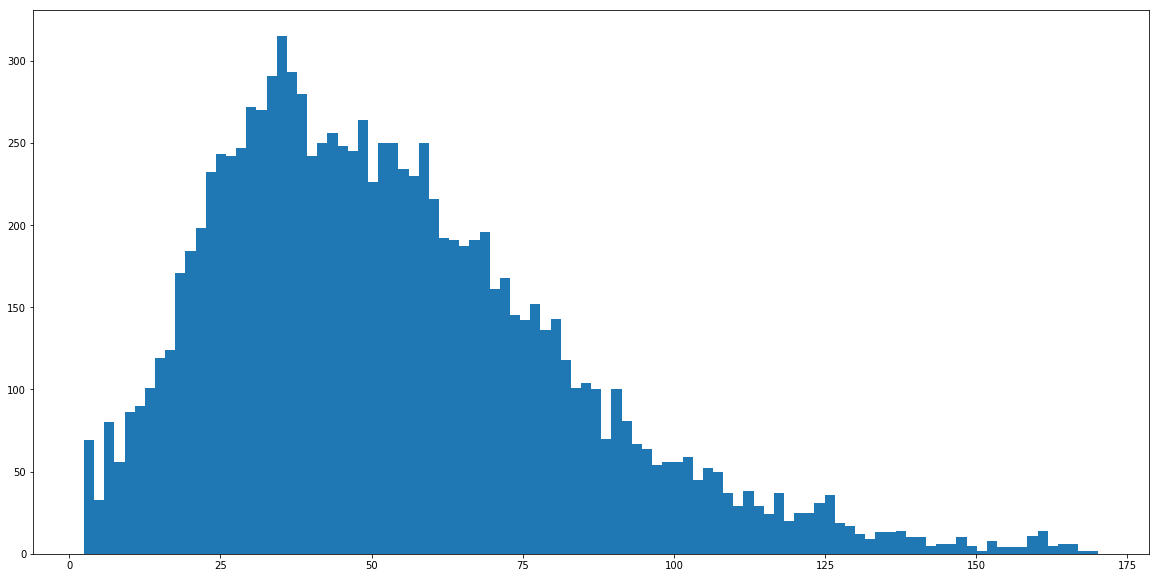

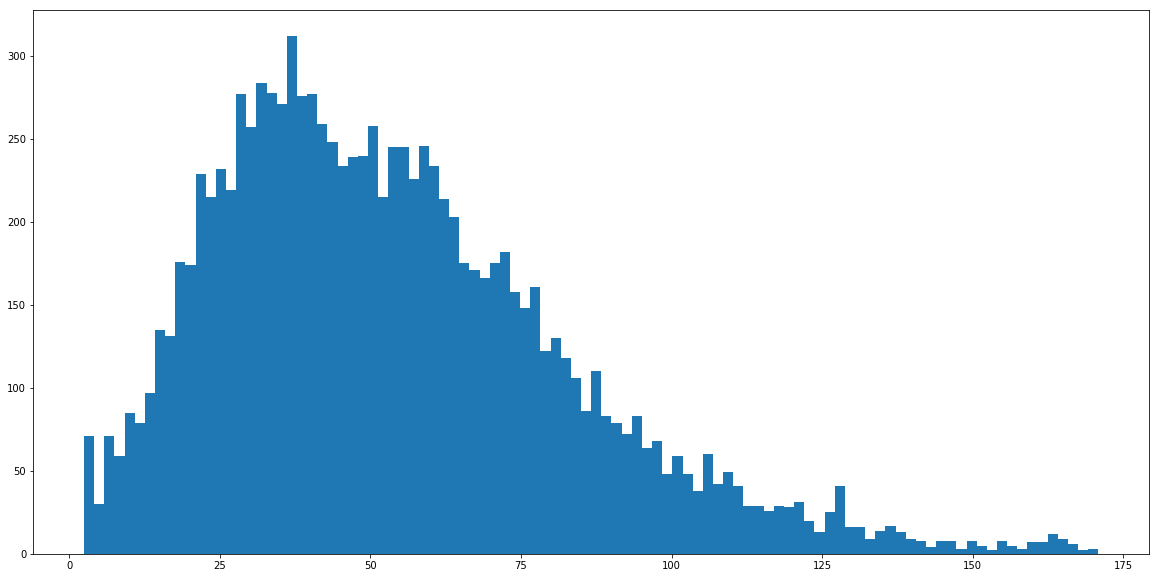

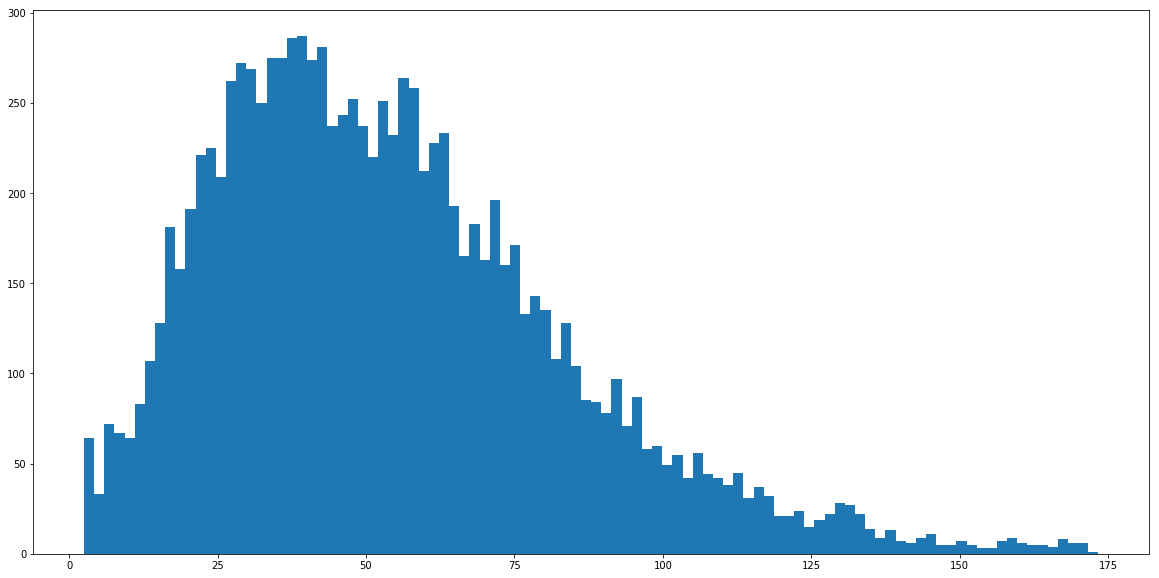

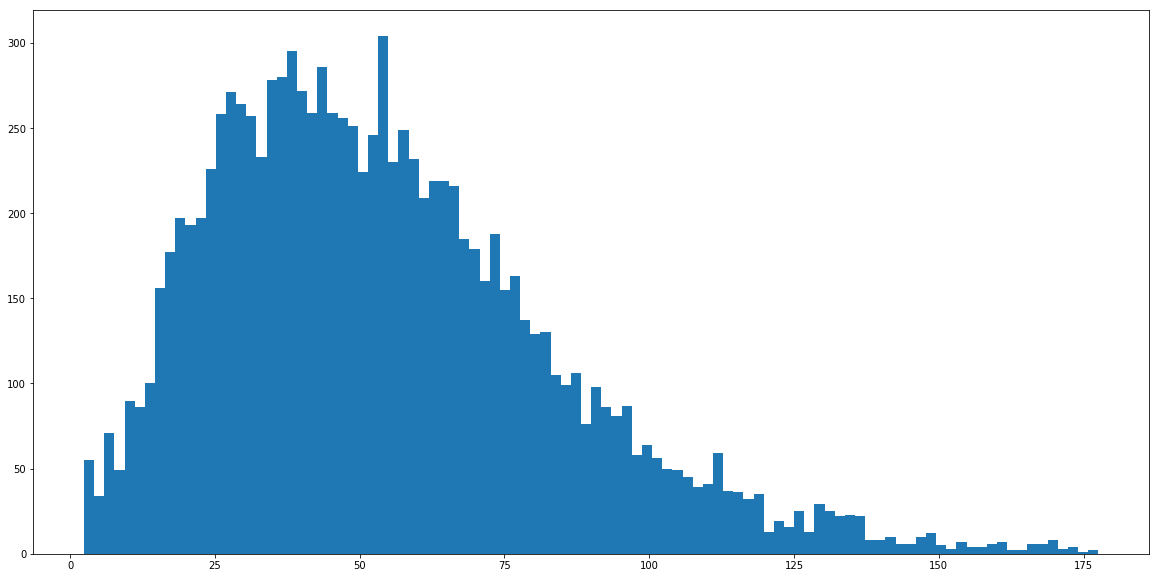

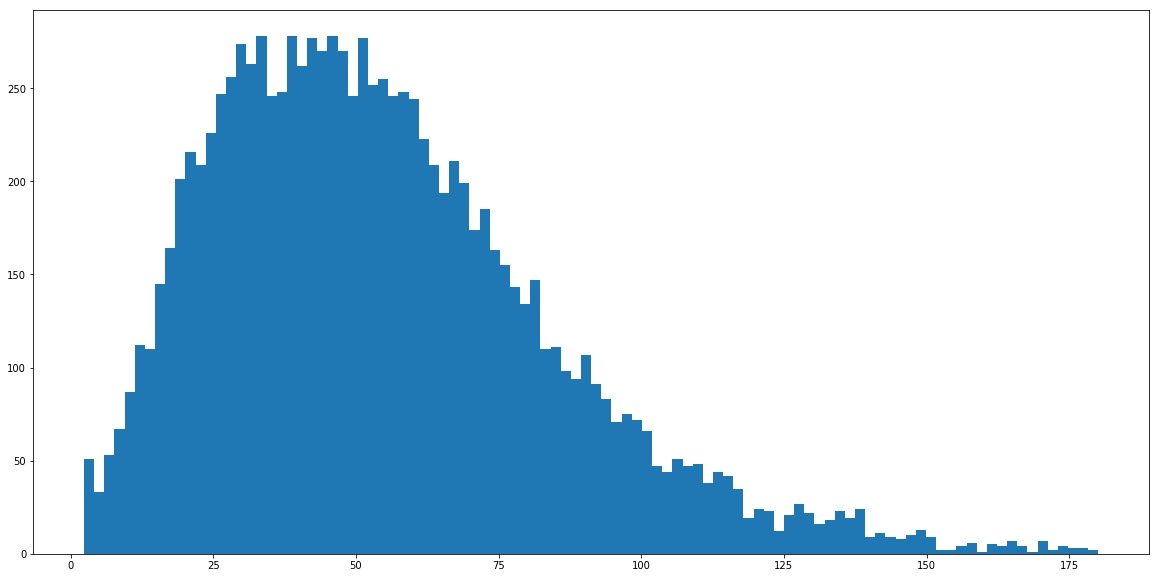

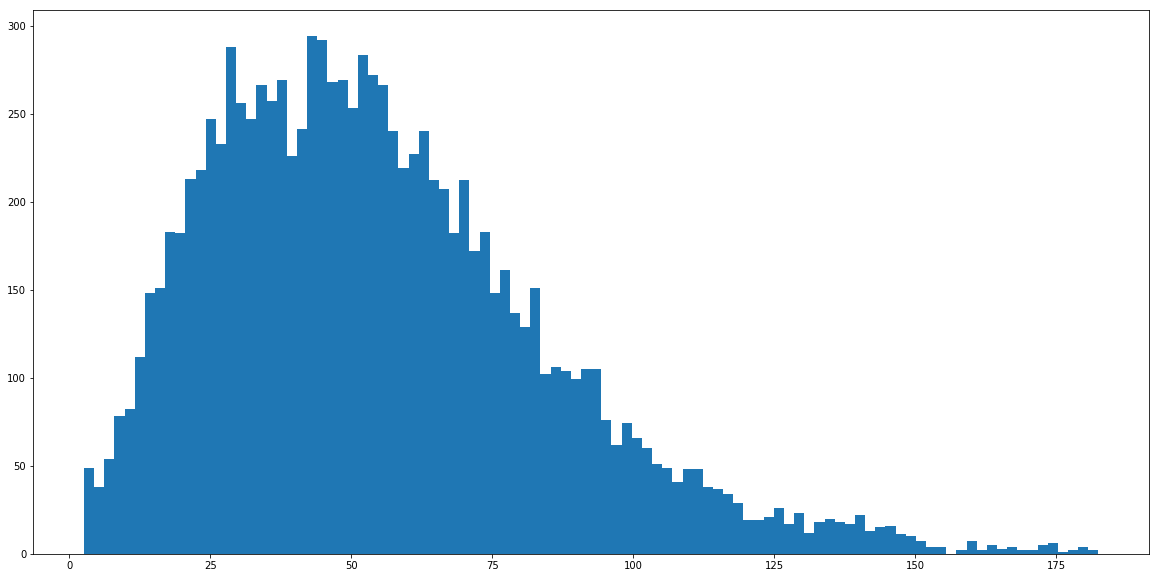

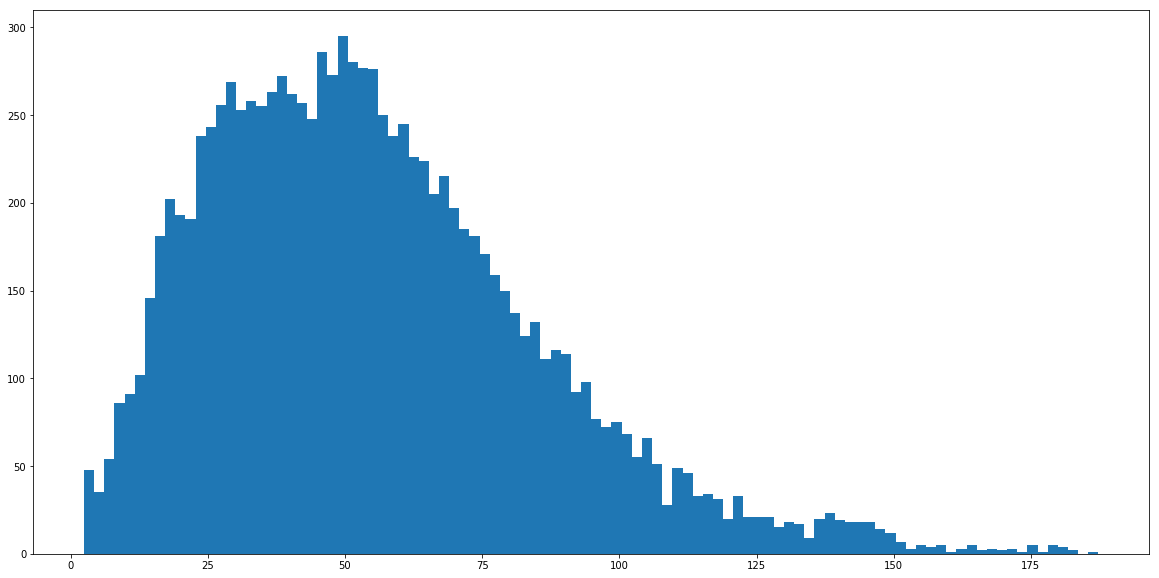

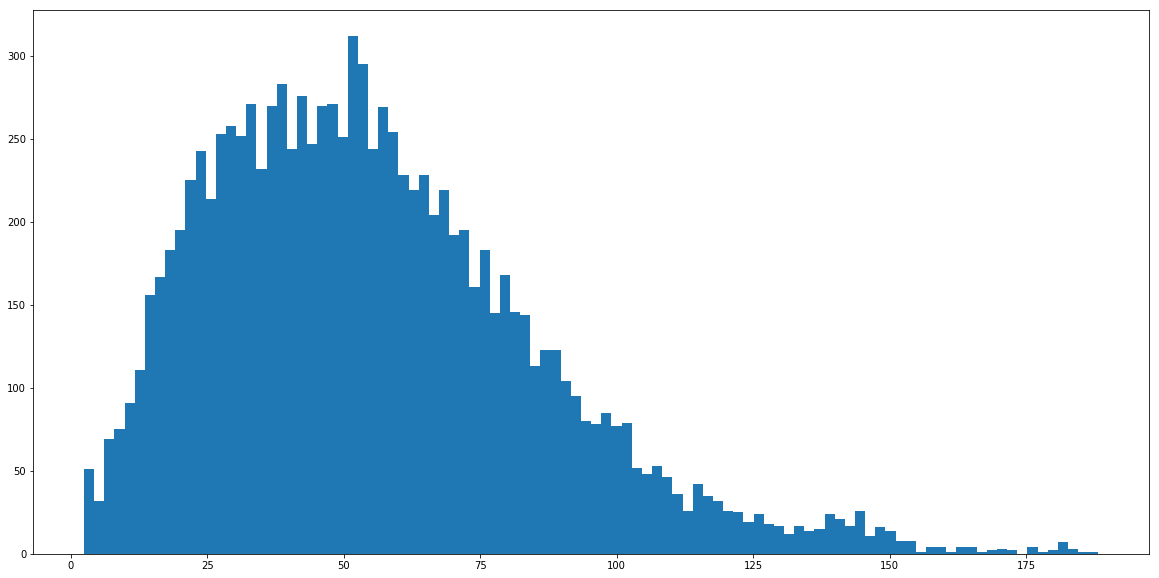

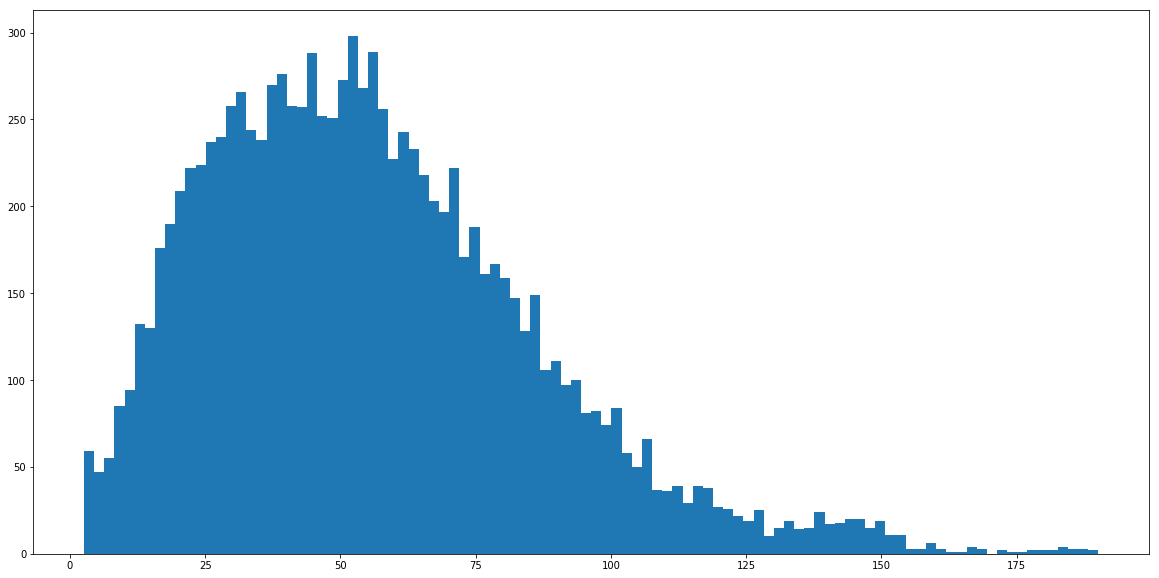

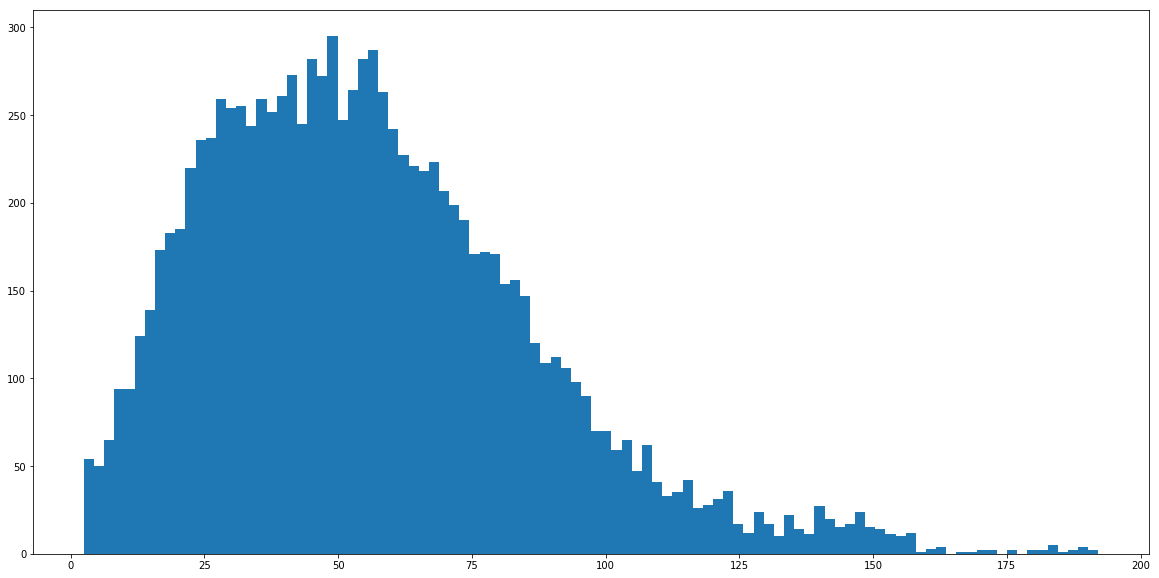

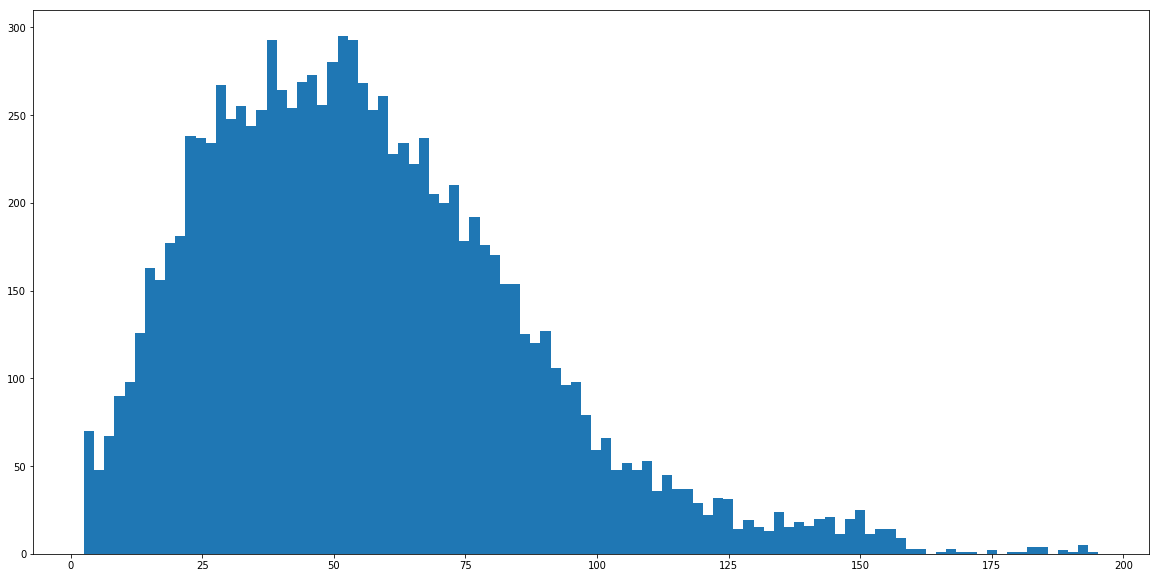

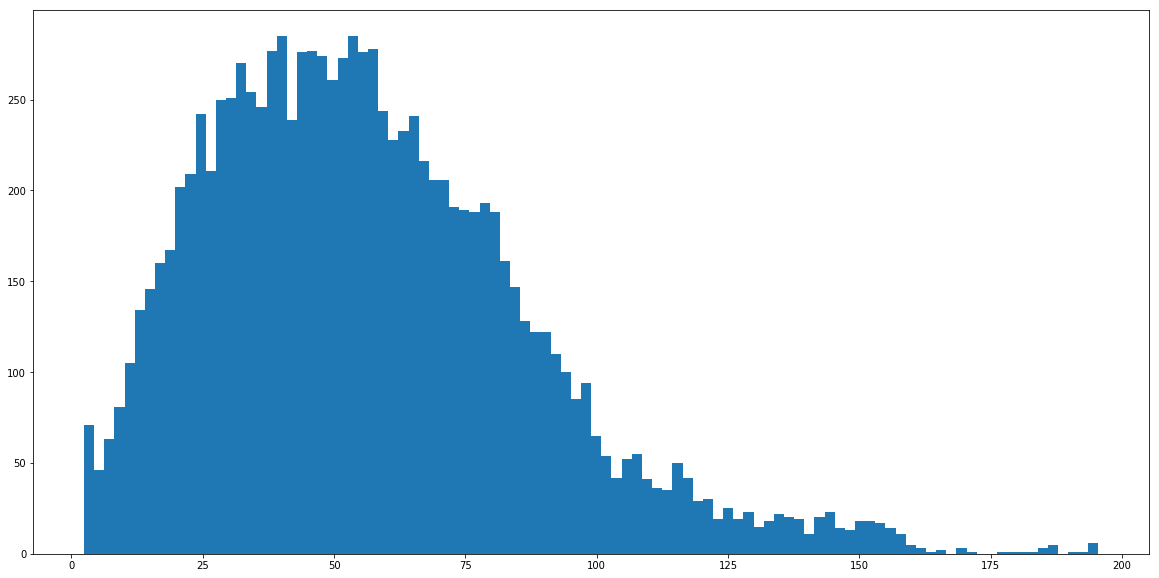

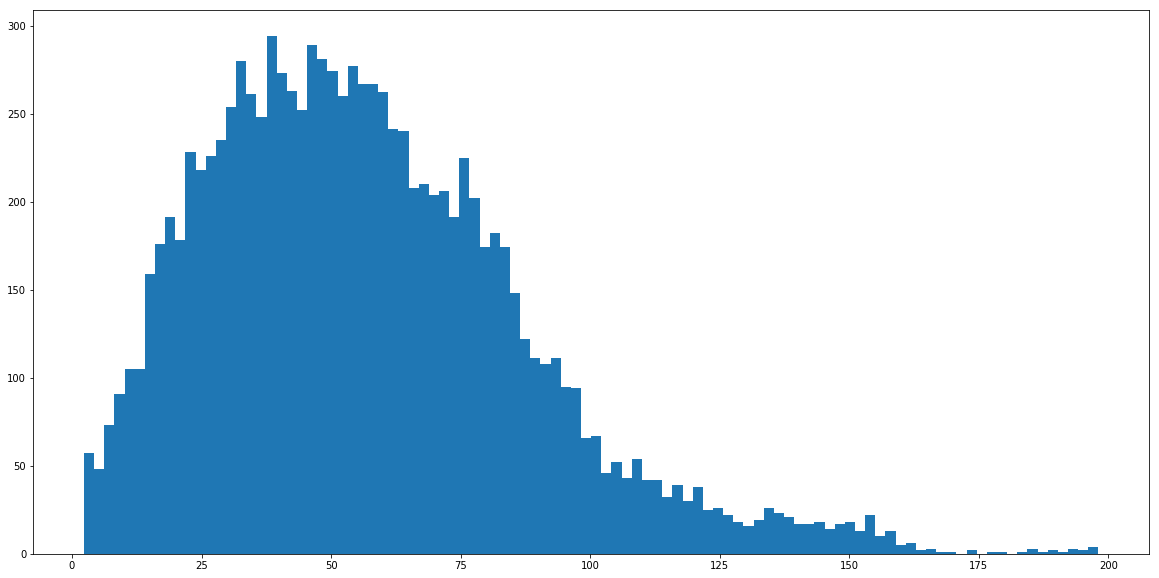

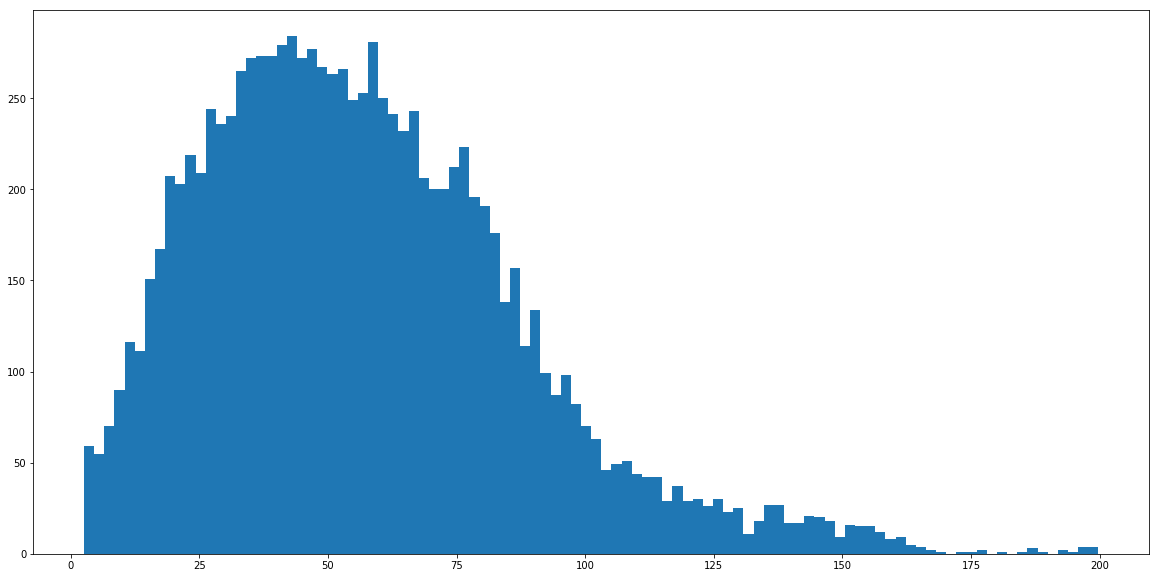

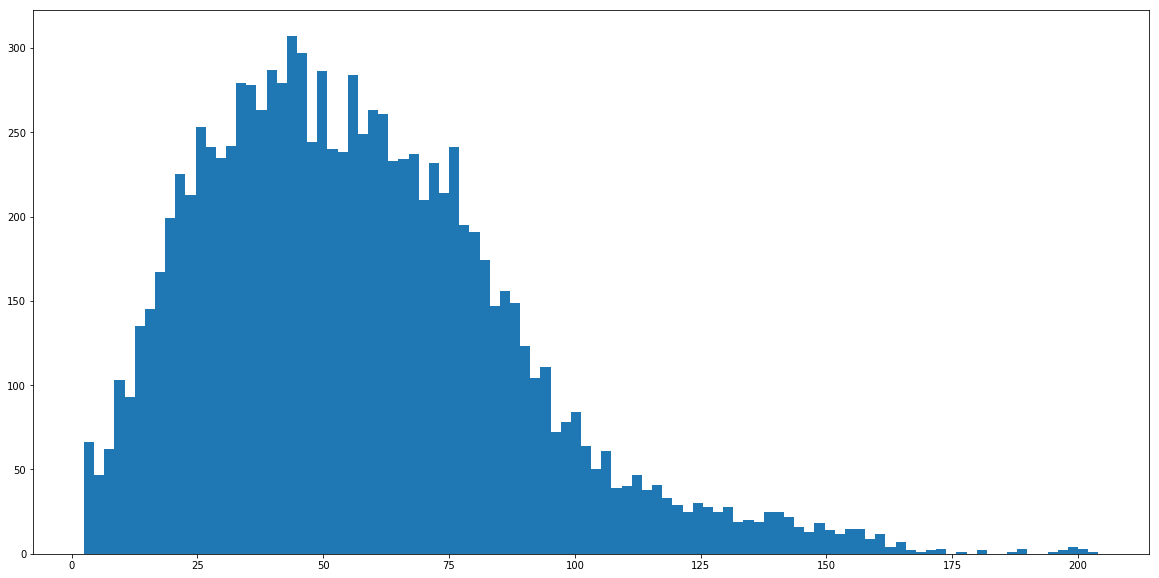

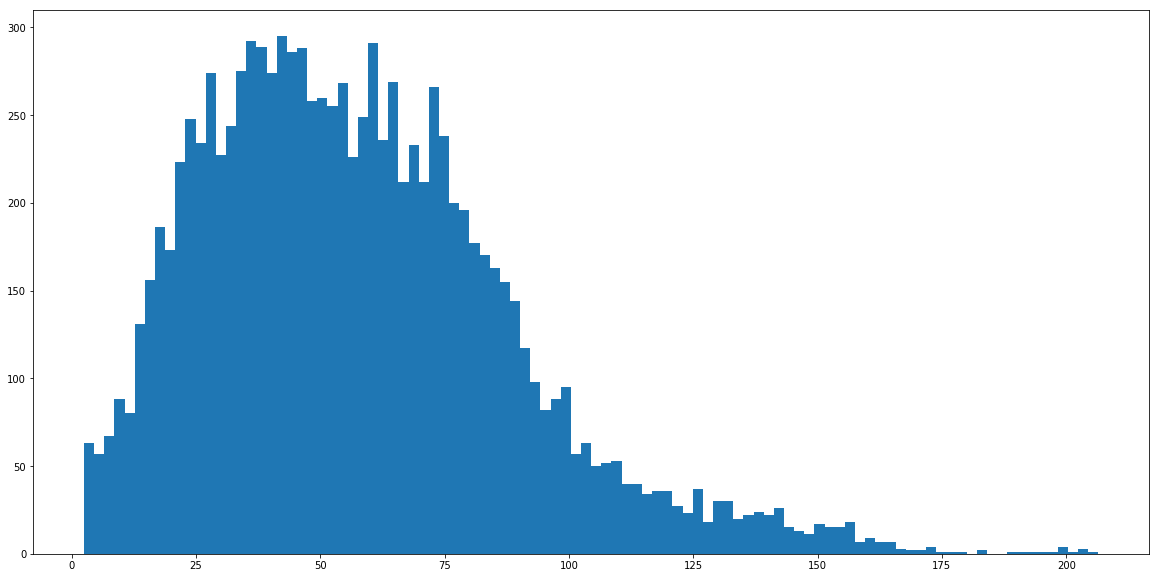

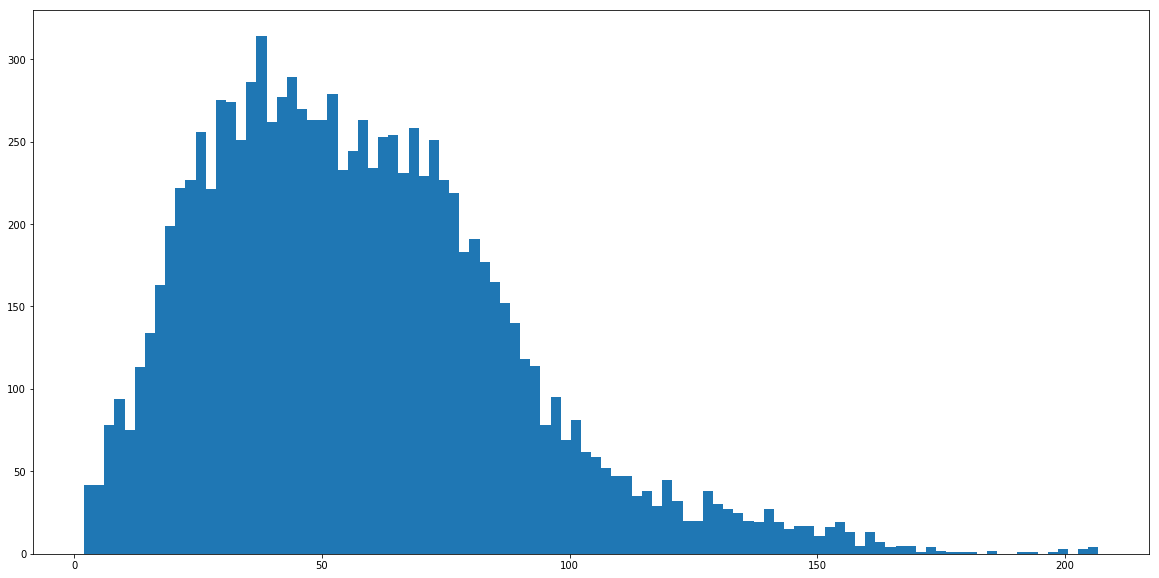

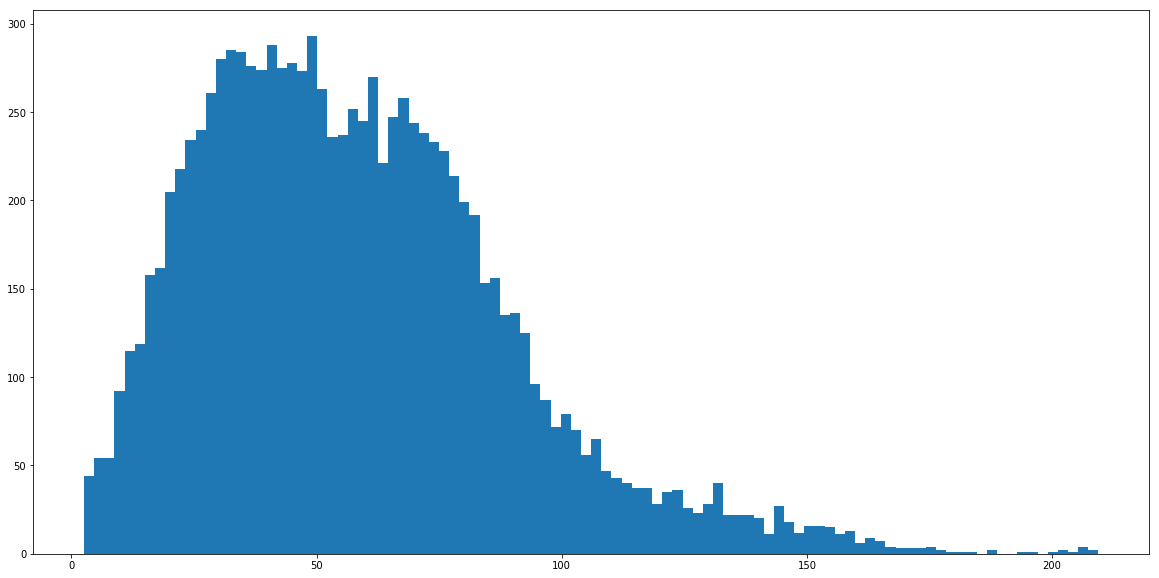

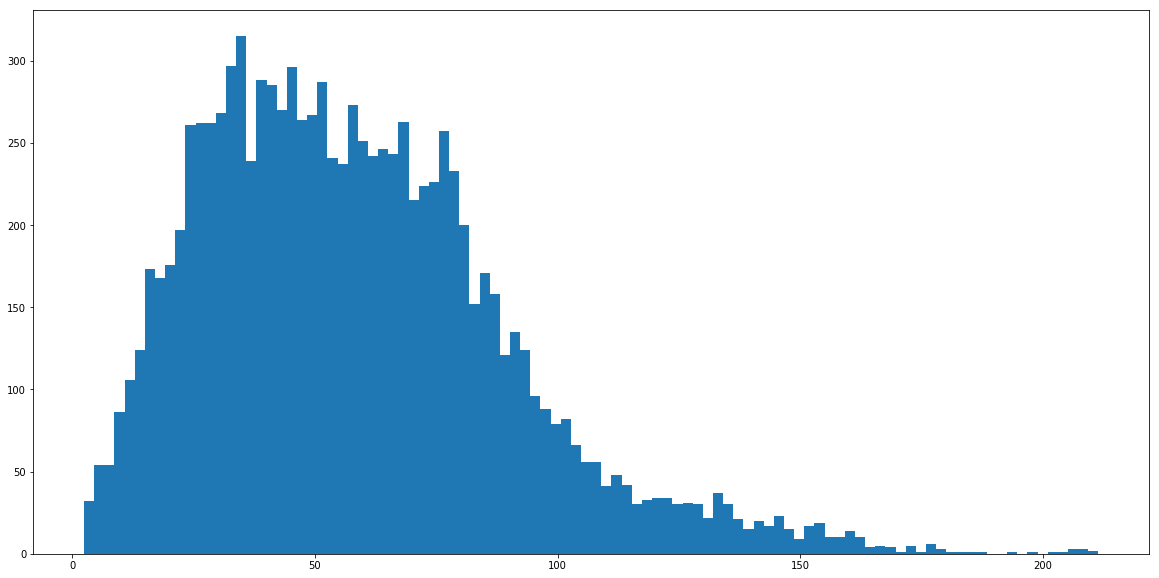

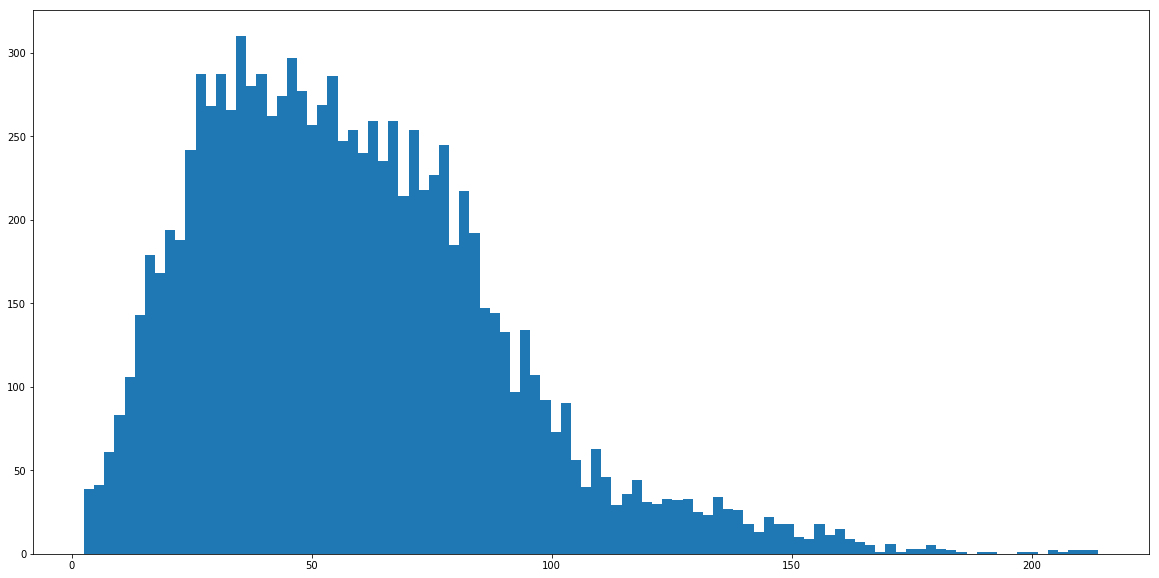

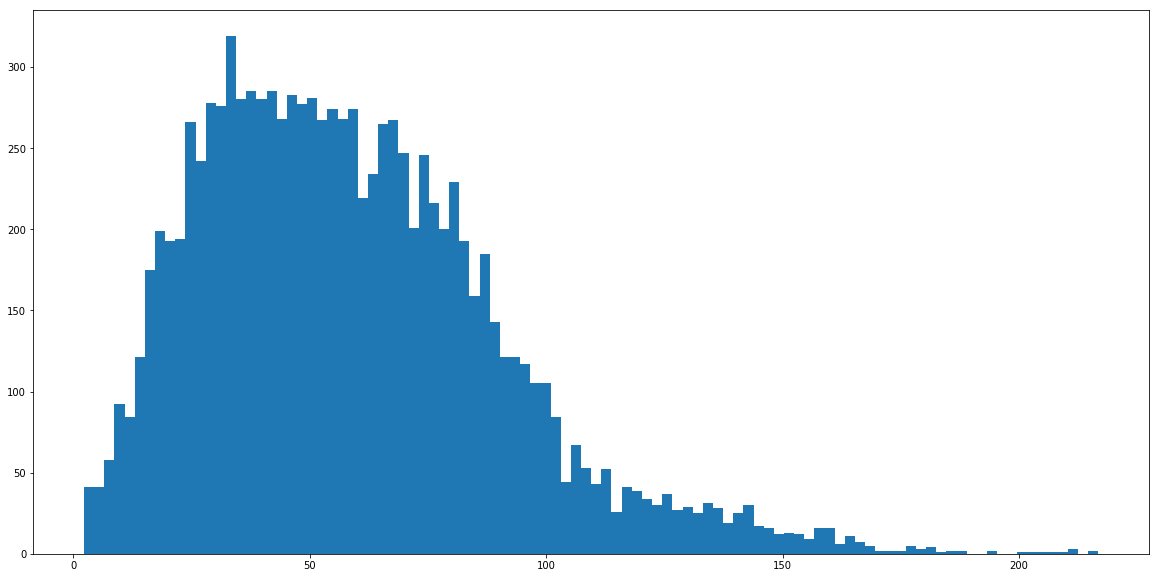

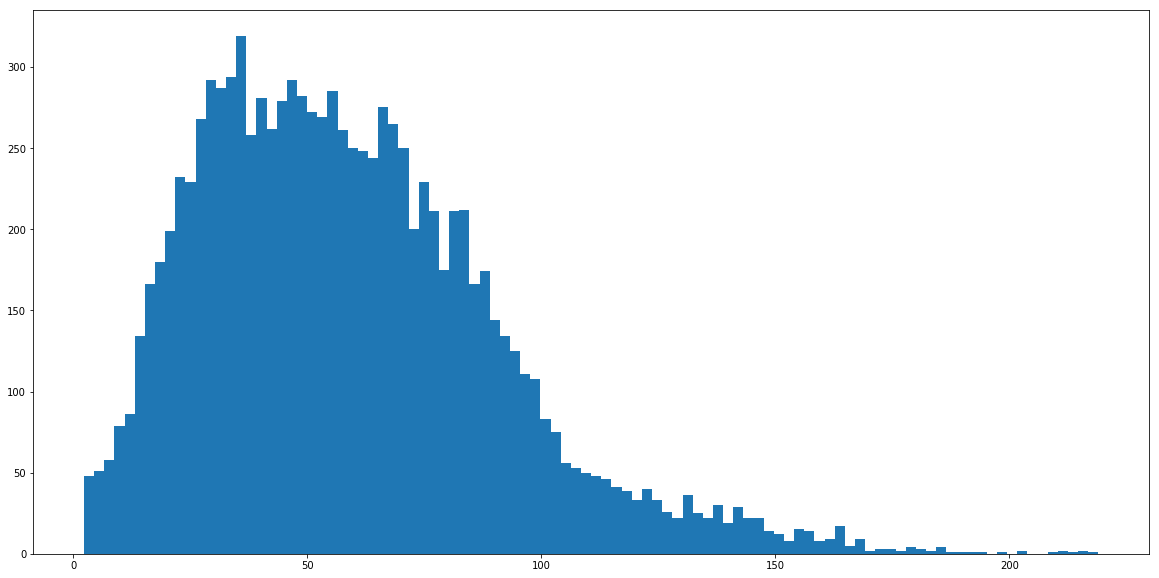

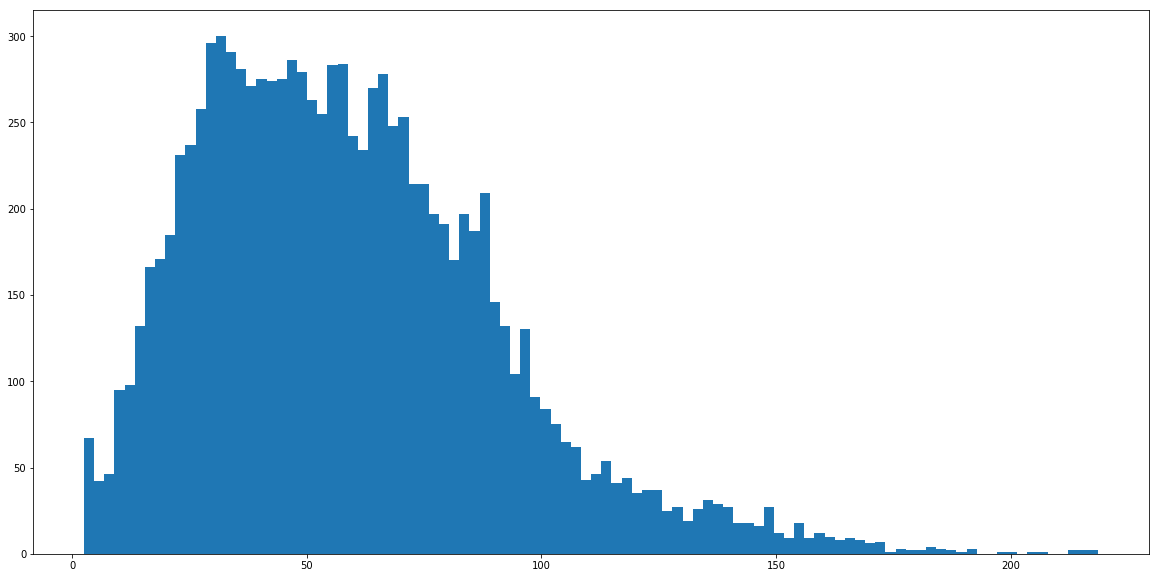

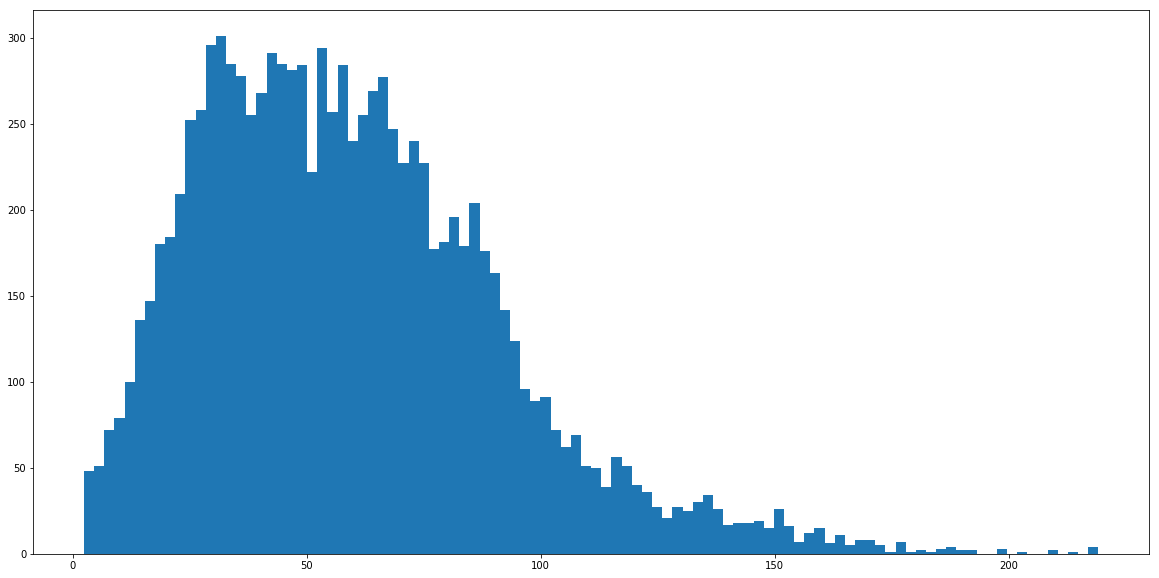

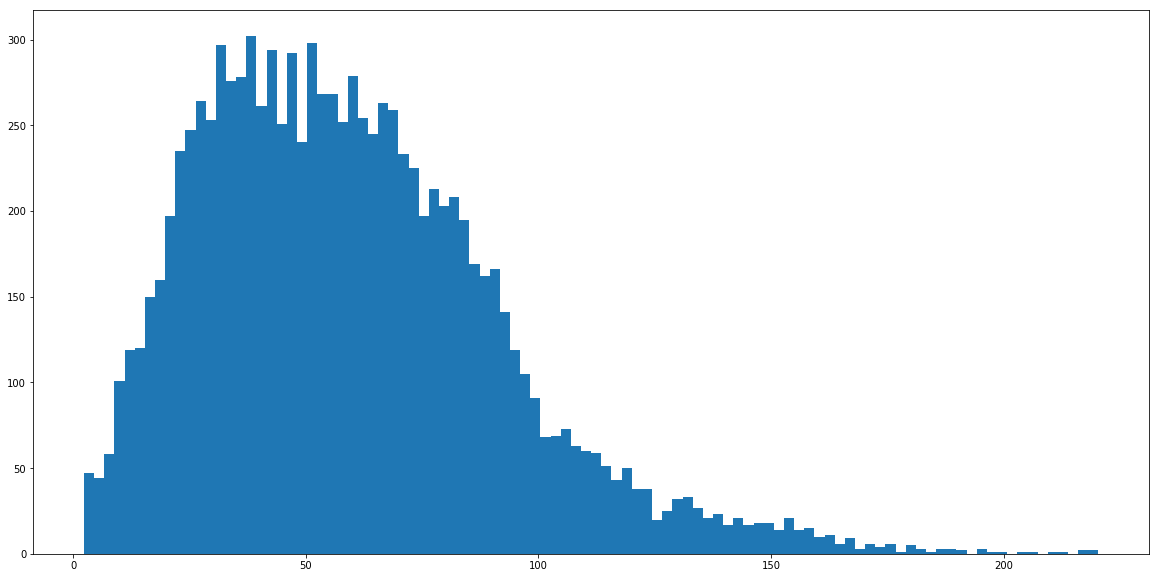

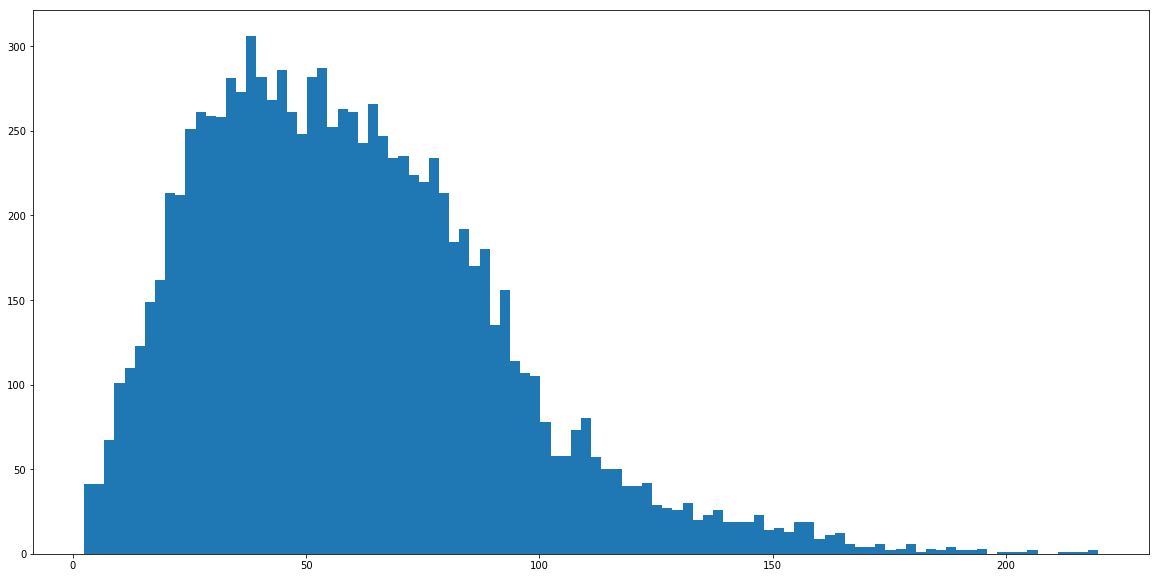

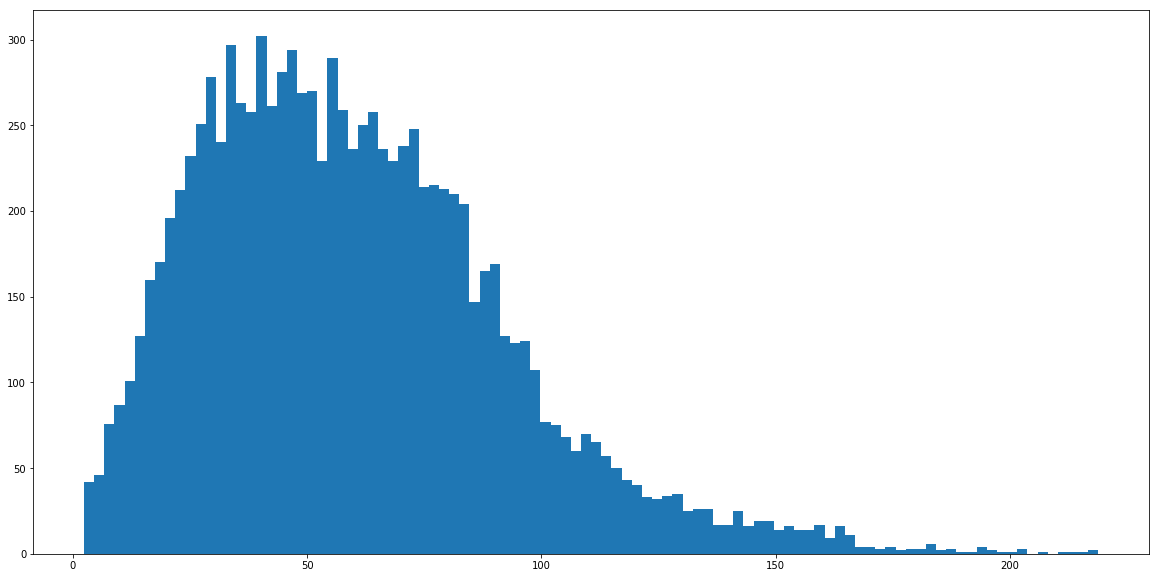

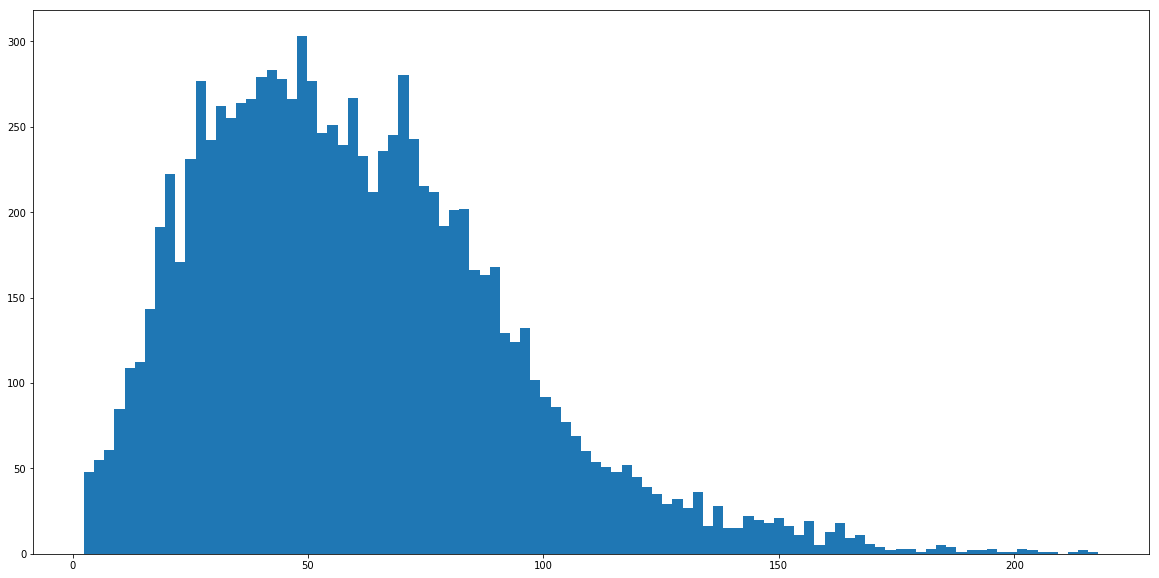

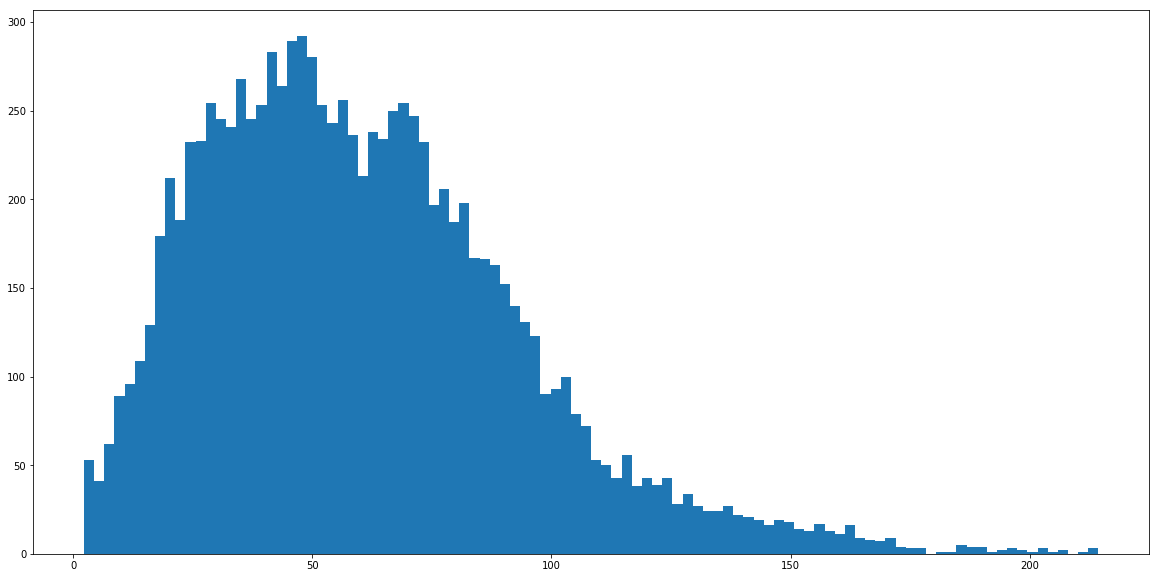

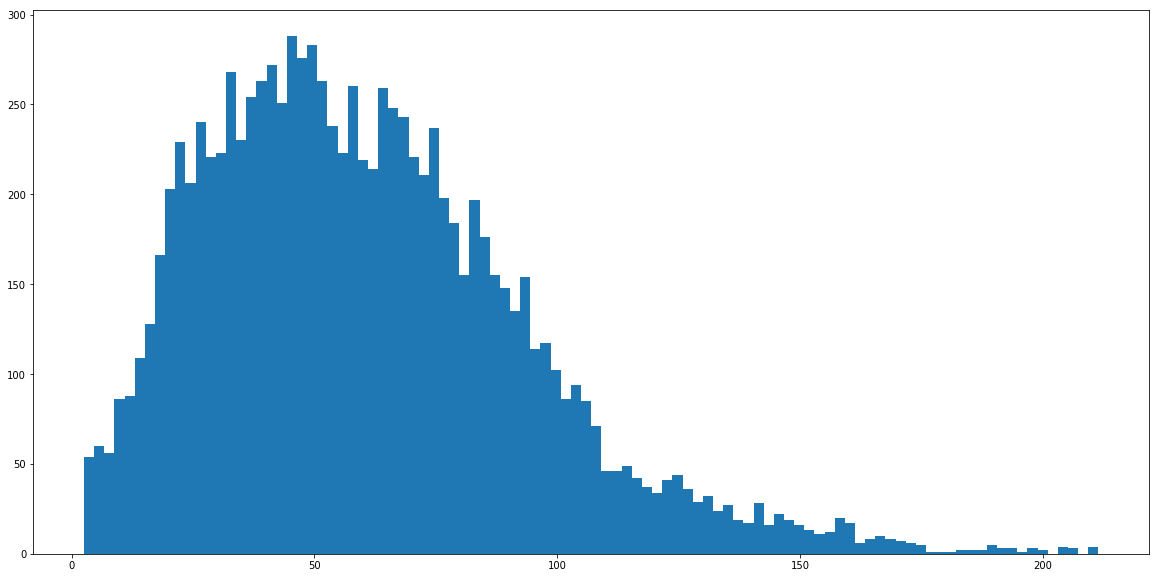

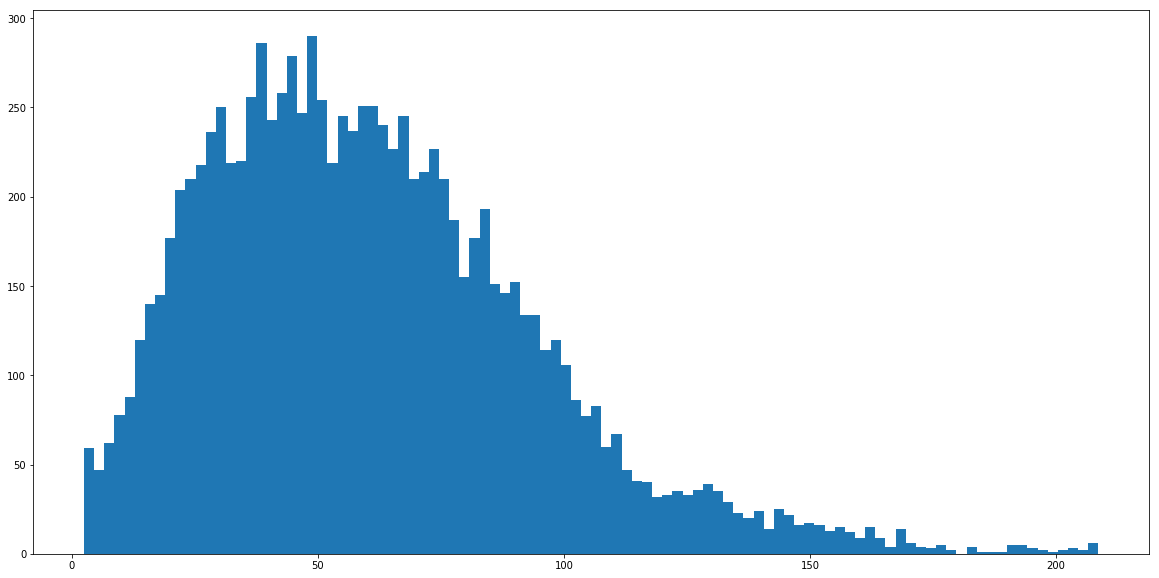

In [25]:
for i in range(1, 100):
    plt.figure(figsize=(20, 10))
    
    distances = get_distances_on_sequence(i, nonredundant_chain_ids)
    plt.hist(distances, bins=100)

Видим, что по-хорошему, если ставить positive threshold в 8 ангстрем, то нужно брать выборку из фрагментов на расстоянии не менее 10, чтобы ловить реально LR взаимодействия.

Посмотрим теперь на расстояния по сиквенсу в LR фрагментах 

In [18]:
lr_sequence_distances = []

for fragment_chain in tqdm(fragment_chains):
    for i, left in enumerate(fragment_chain):
        for right in fragment_chain[i + 1:]:
            if fragment_relation(left, right) == 'LR':
                lr_sequence_distances.append(fragment_sequence_distance(left, right))

100%|██████████| 44/44 [00:04<00:00, 10.88it/s]


In [19]:
len(lr_sequence_distances)

701042

In [20]:
counter = Counter(lr_sequence_distances)

sum([counter[d] for d in range(2, 15)])

7376

Видим, что пар на малом расстоянии мало, не будем их включать в выборку.

Теперь самая проблемная часть: сиквенсы.

In [21]:
Counter([fragment_length(fragment) for fragment in fragments]).most_common()

[(2, 617),
 (3, 615),
 (4, 570),
 (5, 356),
 (1, 289),
 (6, 257),
 (7, 181),
 (8, 93),
 (9, 66),
 (10, 39),
 (11, 27),
 (12, 23),
 (13, 15),
 (15, 9),
 (14, 6),
 (20, 5),
 (16, 4),
 (19, 3),
 (22, 3),
 (17, 3),
 (18, 2),
 (21, 1),
 (28, 1),
 (23, 1),
 (48, 1),
 (47, 1),
 (25, 1),
 (122, 1),
 (37, 1),
 (26, 1),
 (31, 1),
 (35, 1)]

Видим, что фрагментов длинее 10 мало. Предлагается пока их просто выкинуть, а не обрезать, потому что скорее всего у них какая-то отличная от коротких геометрия.

In [12]:
FragmentData = namedtuple('FragmentData', 'type sequence length')
FragmentPairData = namedtuple('FragmentPairData', 'lefts rights relation fragment_distance sequence_distance')

FragmentPair = namedtuple('FragmentPair', 'data distance pdb_id chain_id left right')

In [13]:
def check_fragment(fragment, fragment_length_threshold):
    return all([
        not any(res['MISS'] for res in fragment.members),
        fragment_length(fragment) <= fragment_length_threshold
    ])


def check_fragment_pair(left, right, fragment_sequence_distance_threshold):
    return all([
        fragment_relation(left, right) == 'LR',
        fragment_sequence_distance(left, right) >= fragment_sequence_distance_threshold
    ])


def make_fragment_data(fragment, fragment_length_threshold):
    return FragmentData(
        type=fragment_type(fragment), 
        sequence=fragment_sequence(fragment, fragment_length_threshold), 
        length=fragment_length(fragment))


def make_fragment_pair_data(lefts, rights, fragment_length_threshold):
    center = len(lefts) // 2
    
    return FragmentPairData(
        lefts=[make_fragment_data(item, fragment_length_threshold) for item in lefts],
        rights=[make_fragment_data(item, fragment_length_threshold) for item in rights],
        relation=[[fragment_relation(l, r) for l in lefts] for r in rights], 
        fragment_distance=fragment_fragment_distance(lefts[center], rights[center]),
        sequence_distance=fragment_sequence_distance(lefts[center], rights[center]))


def make_data(fragment_chains, fragment_length_threshold, fragment_sequence_distance_threshold, num_neighbors):
    data = []
    
    for fragment_chain in tqdm(fragment_chains):
        for i, left in enumerate(fragment_chain):
            for j, right in enumerate(fragment_chain):
                ij_ok = all(num_neighbors <= index < len(fragment_chain) - num_neighbors for index in [i, j])
                if i != j and ij_ok:
                    lefts, rights = [fragment_chain[index - num_neighbors:index + num_neighbors + 1] 
                                     for index in [i, j]]
                    fragments_ok = all(check_fragment(fragment, fragment_length_threshold) 
                                       for fragment in chain.from_iterable([lefts, rights]))
                    fragment_pairs_ok = check_fragment_pair(left, right, fragment_sequence_distance_threshold)
                    
                    if fragments_ok and fragment_pairs_ok:
                        data.append(FragmentPair(
                            data=make_fragment_pair_data(lefts, rights, fragment_length_threshold),
                            distance=fragment_distance(left, right),
                            pdb_id=left.pdb_id, 
                            chain_id=left.ch, 
                            left=i, 
                            right=j))
    
    return data

In [24]:
data = make_data(fragment_chains, 10, 15, 1)

100%|██████████| 44/44 [04:36<00:00,  6.28s/it]


In [25]:
Counter([(item.pdb_id, item.chain_id) for item in data])

Counter({('2qwy', 'C'): 32,
         ('4wfl', 'A'): 368,
         ('4rge', 'C'): 110,
         ('6dtd', 'C'): 2,
         ('1f1t', 'A'): 4,
         ('3rw6', 'H'): 66,
         ('4enc', 'A'): 24,
         ('4rmo', 'B'): 2,
         ('5x2g', 'B'): 14,
         ('6qzp', 'L5'): 446592,
         ('1kh6', 'A'): 4,
         ('4jf2', 'A'): 68,
         ('4y4o', '2A'): 328676,
         ('1l9a', 'B'): 392,
         ('6qzp', 'L8'): 760,
         ('6dlr', 'A'): 506,
         ('4yaz', 'R'): 266,
         ('3la5', 'A'): 108,
         ('3pdr', 'X'): 962,
         ('5fjc', 'A'): 310,
         ('5u3g', 'B'): 148,
         ('4qlm', 'A'): 104,
         ('2z75', 'B'): 326,
         ('4far', 'A'): 4484,
         ('3k1v', 'A'): 2,
         ('4y4o', '1a'): 110206,
         ('4frg', 'B'): 180,
         ('4prf', 'B'): 64,
         ('4p95', 'A'): 1400,
         ('3f2q', 'X'): 316,
         ('3e5c', 'A'): 40,
         ('1u9s', 'A'): 1014,
         ('5kpy', 'A'): 20,
         ('4lvw', 'A'): 168,
         ('3npq'

Так как теперь у нас нет верхней границы на расстояние по сиквенсу для пар, то получили сильный дисбаланс по цепочкам и pdb_id. В цепочках ('6qzp', 'L5'), ('4y4o', '2A'), ('6qzp', 'S2'), ('4y4o', '1a') лежат почти все пары. Из-за этого получаются проблемы с кроссвалидацией по количеству фолдов, превышающему 2, если мы хотим чтобы все пары одной цепочки попадали в один и тот же фолд.

In [26]:
np.mean([item.distance < 8 for item in data if item.pdb_id not in ['4y4o', '6qzp']])

0.09967647511939609

In [27]:
np.mean([item.distance < 8 for item in data])

0.008621173773196515

Дисбаланс в коротких цепочках тоже ожидаемо меньше.

Сохраним датасет, потом преобразуем в матрицу для random forest.

In [14]:
class Extractor:
    def extract(self, fragment_pair):
        pass
        
    def describe(self, fragment_pair):
        pass


def extract(fragment_pair, extractors, method='extract'):
    return list(chain.from_iterable([getattr(extractor, method)(fragment_pair) for extractor in extractors]))

In [15]:
def onehot(items, possible_items):
    result = [0] * len(possible_items)
    for item in items:
        result[possible_items.index(item)] = 1

    return result


class FragmentExtractor(Extractor):
    BASES = 'AUGCMN'
    FIRST_TYPES = 'SHBIJ'
    SECOND_TYPES = 'CIP'
    
    def extract(self, fragment_pair):
        result = []
        
        for fragment_data in chain.from_iterable([fragment_pair.data.lefts, fragment_pair.data.rights]):
            result.append(fragment_data.length)
            
            for base in fragment_data.sequence:
                result.extend(onehot([base], self.BASES))
            
            first, second = fragment_data.type
                
            result.extend(onehot(first, self.FIRST_TYPES))
            result.extend(onehot(second, self.SECOND_TYPES))
        
        return result
    
    def describe(self, fragment_pair):
        result = []
        
        for lr in ['lefts', 'rights']:
            for fragment_index, fragment_data in enumerate(fragment_pair.data.lefts):
                result.append('sequence {}[{}] length'.format(lr, fragment_index))
                
                for sequence_index, _ in enumerate(fragment_data.sequence):
                    for base in self.BASES:
                        result.append('sequence {}[{}][{}] == {}'.format(lr, fragment_index, sequence_index, base))
                
                result.extend(['fragment type {}[{}] for first {}'.format(lr, fragment_index, letter) 
                               for letter in self.FIRST_TYPES])
                result.extend(['fragment type {}[{}] for second {}'.format(lr, fragment_index, letter) 
                               for letter in self.SECOND_TYPES])
        
        return result


class TinyExtractor(Extractor):
    def extract(self, fragment_pair):
        return [fragment_pair.data.fragment_distance, fragment_pair.data.sequence_distance]
    
    def describe(self, fragment_pair):
        return ['fragment_distance', 'sequence_distance']


class RelationExtractor(Extractor):
    RELATIONS = ['SM', 'LC', 'LR']
    
    def extract(self, fragment_pair):
        result = []
        
        for rel in chain.from_iterable(fragment_pair.data.relation):
            result.extend(onehot([rel], self.RELATIONS))
        
        return result
    
    def describe(self, fragment_pair):
        result = []
        
        for i, rels in enumerate(fragment_pair.data.relation):
            for j, _ in enumerate(rels):
                for rel_type in self.RELATIONS:
                    result.append('rel_matrix[{}][{}] == {}'.format(i, j, rel_type))
                
        return result


class BowFragmentExtractor(Extractor):
    BASES = 'AUGCMN'
    FIRST_TYPES = 'SHBIJ'
    SECOND_TYPES = 'CIP'
    
    def extract(self, fragment_pair):
        result = []
        
        for fragment_data in chain.from_iterable([fragment_pair.data.lefts, fragment_pair.data.rights]):
            result.append(fragment_data.length)
            
            bow = [0] * len(self.BASES)
            for base in fragment_data.sequence:
                bow[self.BASES.index(base)] += 1
            result.extend(bow)
            
            first, second = fragment_data.type
            first_onehot, second_onehot = [0] * len(self.FIRST_TYPES), [0] * len(self.SECOND_TYPES)
            
            for item in first:
                first_onehot[self.FIRST_TYPES.index(item)] = 1
                
            for item in second:
                second_onehot[self.SECOND_TYPES.index(item)] = 1
                
            result.extend(first_onehot)
            result.extend(second_onehot)
        
        return result
    
    def describe(self, fragment_pair):
        result = []
        
        for lr in ['lefts', 'rights']:
            for fragment_index, _ in enumerate(fragment_pair.data.lefts):
                result.append('sequence {}[{}] length'.format(lr, fragment_index))
                for base in self.BASES:
                    result.append('sequence {}[{}] count of {}'.format(lr, fragment_index, base))
                
                result.extend(['fragment type {}[{}] for first {}'.format(lr, fragment_index, letter) 
                               for letter in self.FIRST_TYPES])
                result.extend(['fragment type {}[{}] for second {}'.format(lr, fragment_index, letter) 
                               for letter in self.SECOND_TYPES])
        
        return result


class BowRelationExtractor(Extractor):
    RELATIONS = ['SM', 'LC', 'LR']
    
    def extract(self, fragment_pair):
        bow = [0] * 3
        for rel in chain.from_iterable(fragment_pair.data.relation):
            bow[self.RELATIONS.index(rel)] += 1
        
        return bow
    
    def describe(self, fragment_pair):
        return ['relation count {}'.format(rel) for rel in self.RELATIONS]

In [16]:
BATCH_SIZE = 100000


def generate_data(data_dir):
    for i in count():
        fpath = os.path.join(data_dir, 'batch_{}'.format(i))
        
        if os.path.exists(fpath):
            with open(fpath, 'rb') as infile:
                yield from pickle.load(infile)
        else:
            break

            
def save_dataset(data_dir, digitized_features, target, pdb_ids, chain_ids, pair_index, description):
    np.save(os.path.join(data_dir, 'features.npy'), digitized_features)
    np.save(os.path.join(data_dir, 'target.npy'), target)
    np.save(os.path.join(data_dir, 'pdb_ids.npy'), pdb_ids)
    np.save(os.path.join(data_dir, 'chain_ids.npy'), chain_ids)
    np.save(os.path.join(data_dir, 'pair_index.npy'), pair_index)
    
    with open(os.path.join(data_dir, 'description.pickle'), 'wb') as outfile:
        pickle.dump(description, outfile)


def make_dataset(base_data_dir,
                 fragment_chains, 
                 fragment_length_threshold, 
                 distance_threshold,
                 fragment_sequence_distance_threshold, 
                 num_neighbours, extractors, extractors_suffix):
    folder = (
        f'flt={fragment_length_threshold}.'
        f'fsdt={fragment_sequence_distance_threshold}.'
        f'dt={distance_threshold}.'
        f'nn={num_neighbours}.'
        f'es={extractors_suffix}'
    )
    data_dir = os.path.join(base_data_dir, folder)
    
    if os.path.exists(data_dir):
        print(f'skipping {folder}')
        return
    else:
        print(f'make_dataset for {folder}')
    
    os.makedirs(data_dir)
    
    data = make_data(
        fragment_chains, 
        fragment_length_threshold, 
        fragment_sequence_distance_threshold, 
        num_neighbours)
    
    for batch_index, i in enumerate(range(0, len(data), BATCH_SIZE)):
        with open(os.path.join(data_dir, 'batch_{}'.format(batch_index)), 'wb') as outfile:
            pickle.dump(data[i:i + BATCH_SIZE], outfile, protocol=pickle.HIGHEST_PROTOCOL)
        
    digitized_features = [extract(fragment_pair, extractors) for fragment_pair in tqdm(generate_data(data_dir))]
    sample_pair = next(generate_data(data_dir))
    description = extract(sample_pair, extractors, method='describe')
    
    print(f'len(description)={len(description)}')
    
    target_distance = []
    pdb_ids = []
    chain_ids = []
    pair_index = []

    for fragment_pair in tqdm(generate_data(data_dir)):
        target_distance.append(fragment_pair.distance)
        pdb_ids.append(fragment_pair.pdb_id)
        chain_ids.append(fragment_pair.chain_id)
        pair_index.append([fragment_pair.left, fragment_pair.right])
    
    digitized_features = np.array(digitized_features, dtype=np.int16)
    target = np.array(target_distance) < distance_threshold
    pdb_ids = np.array(pdb_ids)
    chain_ids = np.array(chain_ids)
    pair_index = np.array(pair_index)
    
    save_dataset(data_dir, digitized_features, target, pdb_ids, chain_ids, pair_index, description)

In [17]:
BASE_DATA_DIR = '/home/mikhail/bioinformatics/data/fragment_data'

In [19]:
bow_wo_distance = [BowFragmentExtractor()]
bow = [BowFragmentExtractor(), TinyExtractor(), BowRelationExtractor()]

for dt, fsdt in [(4, 4), (8, 6), (11, 10)]:
    make_dataset(BASE_DATA_DIR, fragment_chains, 10, dt, fsdt, 1, bow_wo_distance, 'bow_wo_distance')
    make_dataset(BASE_DATA_DIR, fragment_chains, 10, dt, fsdt, 1, bow, 'bow')

  5%|▌         | 2/38 [00:00<00:02, 14.49it/s]

make_dataset for flt=10.fsdt=4.dt=4.nn=1.es=bow_wo_distance


100%|██████████| 38/38 [00:03<00:00,  9.60it/s]
15204it [00:00, 15434.44it/s]
0it [00:00, ?it/s]

len(description)=90


15204it [00:00, 34093.20it/s]
  5%|▌         | 2/38 [00:00<00:02, 16.21it/s]

make_dataset for flt=10.fsdt=4.dt=4.nn=1.es=bow


100%|██████████| 38/38 [00:03<00:00,  9.63it/s]
15204it [00:01, 15032.08it/s]
0it [00:00, ?it/s]

len(description)=95


15204it [00:00, 21235.67it/s]
  5%|▌         | 2/38 [00:00<00:02, 16.65it/s]

make_dataset for flt=10.fsdt=6.dt=8.nn=1.es=bow_wo_distance


100%|██████████| 38/38 [00:03<00:00, 10.32it/s]
14764it [00:00, 20965.54it/s]
0it [00:00, ?it/s]

len(description)=90


14764it [00:00, 20679.65it/s]
  5%|▌         | 2/38 [00:00<00:02, 16.99it/s]

make_dataset for flt=10.fsdt=6.dt=8.nn=1.es=bow


100%|██████████| 38/38 [00:03<00:00, 10.27it/s]
14764it [00:00, 19258.57it/s]
0it [00:00, ?it/s]

len(description)=95


14764it [00:00, 20998.72it/s]
  5%|▌         | 2/38 [00:00<00:01, 18.62it/s]

make_dataset for flt=10.fsdt=10.dt=11.nn=1.es=bow_wo_distance


100%|██████████| 38/38 [00:03<00:00, 10.20it/s]
13960it [00:00, 14916.63it/s]
0it [00:00, ?it/s]

len(description)=90


13960it [00:00, 20722.99it/s]
  5%|▌         | 2/38 [00:00<00:01, 18.22it/s]

make_dataset for flt=10.fsdt=10.dt=11.nn=1.es=bow


100%|██████████| 38/38 [00:03<00:00, 10.27it/s]
13960it [00:00, 18832.07it/s]
0it [00:00, ?it/s]

len(description)=95


13960it [00:00, 18808.62it/s]
